# Models validation for winners forcast

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as sps
from scipy.stats import gaussian_kde, norm
import seaborn as sns
import copy

#Criteria
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

#AR
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

#ES
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import arima, auto_arima

#Prophet
from prophet import Prophet

#DeepAR
from gluonts.torch.model.deepar import DeepAREstimator
# from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import Evaluator

#Warnings
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# from gluonts.torch.model.deepar import DeepAREstimator
# # from gluonts.mx.trainer import Trainer
# from gluonts.evaluation.backtest import make_evaluation_predictions
# from gluonts.dataset.common import ListDataset
# from gluonts.dataset.field_names import FieldName

## Очистка данных

In [3]:
def toi(x):
    return np.nan if pd.isna(x) else int(x)

In [4]:
def unique_name(s):
    if 'вторая школа' in s.lower():
        return 'Вторая школа'
    elif 'сунц мгу' in s.lower():
        return 'СУНЦ МГУ'
    elif 'лицей' in s.lower() and 'вшэ' in s.lower():
        return 'лицей ВШЭ'
    elif 'цпм' in s.lower() or 'центра педагогического мастерства' in s.lower():
        return 'ЦПМ'
    elif 'интеллектуал' in s.lower():
        return 'ГБОУ школа «Интеллектуал»'
    elif 'летово' in s.lower():
        return 'школа Летово'
    elif 'максимчука' in s.lower():
        return s
    elif 'вернадского' in s.lower():
        return 'школа на проспекте Вернадского'
    elif 'троицка»' in s.lower():
        return 'МАОУ «Гимназия г.Троицка»'
    elif s == 'университетская гимназия':
        return 'университетская гимназия (школа-интернат) МГУ имени М.В.Ломоносова'
    elif 'марьина роща' in s.lower():
        return 'ГБОУ школа Марьина Роща имени В.Ф. Орлова'
    elif 'первый московский кадетский корпус' in s.lower() or 'пмкк' in s.lower():
        return 'ГБОУ «Первый Московский кадетский корпус»'
    elif 'государственная столичная гимназия' in s.lower() or 'гсг' in s.lower():
        return 'ГБОУ Государственная столичная гимназия'
    elif 'итш' in s.lower() or 'инженерно-техническая школа' in s.lower():
        return 'ГБОУ Инженерно-техническая школа'
    elif 'пансион воспитанниц' in s.lower() or 'пв' in s.lower():
        return 'Пансион воспитанниц МО РФ'
    else: 
        for word in s.replace('»', '').split():
            if word.isdigit():
                return word
    return s

In [5]:
def profile_correction(x):
    if x == 'астрономия':
        return 'Астрономия'
    elif x == 'Информатика и информационно-коммуникационные технологии (ИКТ) и ИКТ' or x == 'Информатика и информационно-коммуникационные технологии (ИКТ)':
        return 'Информатика'
    elif x == 'Немецкий язык':
        return 'Иностранный язык (немецкий язык)' 
    elif x == 'филология':
        return 'Филология'
    elif x == 'История искусств' or x == 'Мировая художественная культура (МХК)' or x == 'Искусство (МХК)':
        return 'МХК'
    else:
        return x

In [6]:
olymp = pd.read_csv('olymp.csv', sep=';', header=0)

olymp = olymp.drop(columns=['IDEKIS', 'ID', 'Unnamed: 12', 'global_id']).drop([0]).reset_index(drop=True)

C:\Users\i9629\AppData\Local\Temp\ipykernel_2980\1515750694.py:1: DtypeWarning: Columns (0,1,5,6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  olymp = pd.read_csv('olymp.csv', sep=';', header=0)


In [7]:
olymp['UniqueName'] = olymp['ShortName'].apply(lambda s: unique_name(s))
olymp['Stage'] = olymp['Stage'].apply(lambda x: toi(x))
olymp['Class'] = olymp['Class'].apply(lambda x: toi(x))
olymp['OlympiadProfile'] = olymp['OlympiadProfile'].apply(lambda x: profile_correction(x))


olymp.head()

FullName  \
0  Государственное бюджетное общеобразовательное ...   
1  Государственное бюджетное общеобразовательное ...   
2  Государственное бюджетное общеобразовательное ...   
3  Государственное бюджетное образовательное учре...   
4  Государственное бюджетное образовательное учре...   

                   ShortName             OlympiadType  Stage  Class  \
0  ГБОУ лицей «Вторая школа»  Всероссийская олимпиада    3.0     11   
1  ГБОУ лицей «Вторая школа»  Всероссийская олимпиада    3.0     11   
2  ГБОУ лицей «Вторая школа»  Всероссийская олимпиада    3.0     10   
3              ГБОУ СОШ № 26  Всероссийская олимпиада    4.0     11   
4              ГБОУ СОШ № 26  Всероссийская олимпиада    3.0     11   

                                        OlympiadName  \
0  Всероссийская олимпиада школьников по английск...   
1  Всероссийская олимпиада школьников по английск...   
2  Всероссийская олимпиада школьников по английск...   
3  Всероссийская олимпиада школьников по английск...   
4  Всероссийская олимпиада школьников по английск...   

                      OlympiadProfile      Status       Year    UniqueName  
0  Иностранный язык (английский язык)      призёр  2012/2013  Вторая школа  
1  Иностранный язык (английский язык)      призёр  2012/2013  Вторая школа  
2  Иностранный язык (английский язык)      призёр  2012/2013  Вторая школа  
3  Иностранный язык (английский язык)  победитель  2012/2013            26  
4  Иностранный язык (английский язык)      призёр  2012/2013            26

## Choosing the focasting group

In [8]:
rpo_3 = olymp[(olymp['OlympiadType'] == 'Всероссийская олимпиада') & (olymp['Stage'] == 3)] 

In [9]:
def count_win(x):
    return len(x[x == 'победитель'])

def count_prize(x):
    return len(x[x == 'призёр'])

In [10]:
rpo_3['OlympiadProfile'].unique()

array(['Иностранный язык (английский язык)', 'Астрономия', 'Биология',
       'География', 'Информатика', 'История', 'Литература', 'Математика',
       'МХК', 'Иностранный язык (немецкий язык)',
       'Основы безопасности жизнедеятельности', 'Обществознание', 'Право',
       'Русский язык', 'Технология', 'Физика', 'Физическая культура',
       'Иностранный язык (французский язык)', 'Химия', 'Экология',
       'Экономика', 'Иностранный язык (итальянский язык)',
       'Иностранный язык (испанский язык)',
       'Иностранный язык (китайский язык)'], dtype=object)

In [11]:
# rpo3_grouped = rpo_3[rpo_3['OlympiadProfile'] == 'Обществознание'].groupby(['Year', 'UniqueName']).agg({'Status': [count_win, count_prize]})
rpo3_grouped = rpo_3.groupby(['Year', 'UniqueName']).agg({'Status': [count_win, count_prize]})

rpo3_grouped.columns = ['Win', 'Prize']
rpo3_grouped['WinPrize'] = rpo3_grouped['Win'] + rpo3_grouped['Prize']
rpo3_grouped['WWinPrize'] = 2 * rpo3_grouped['Win'] + rpo3_grouped['Prize']


rpo3_grouped.head()

Win  Prize  WinPrize  WWinPrize
Year      UniqueName                                 
2012/2013 1             0      2         2          2
          10            0      1         1          1
          1000          1      3         4          5
          1007          0      3         3          3
          1008          0      1         1          1

In [12]:
quantiles = [0, .7, .85, .95, .99, 1]

rpo3_grouped['Level'] = rpo3_grouped.groupby('Year')['WinPrize'].apply(lambda x: pd.qcut(x, quantiles, labels=['low', 'base', 'mid', 'high', 'out'])).droplevel(0)
rpo3_grouped.head()

Win  Prize  WinPrize  WWinPrize Level
Year      UniqueName                                       
2012/2013 1             0      2         2          2   low
          10            0      1         1          1   low
          1000          1      3         4          5  base
          1007          0      3         3          3   low
          1008          0      1         1          1   low

C:\Users\i9629\AppData\Local\Temp\ipykernel_2980\3583401127.py:2: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=rpo3_grouped.groupby(['Year', 'Level'])['WinPrize'].sum().reset_index(),


Text(0.5, 1.0, 'WinPrize increase by school level')

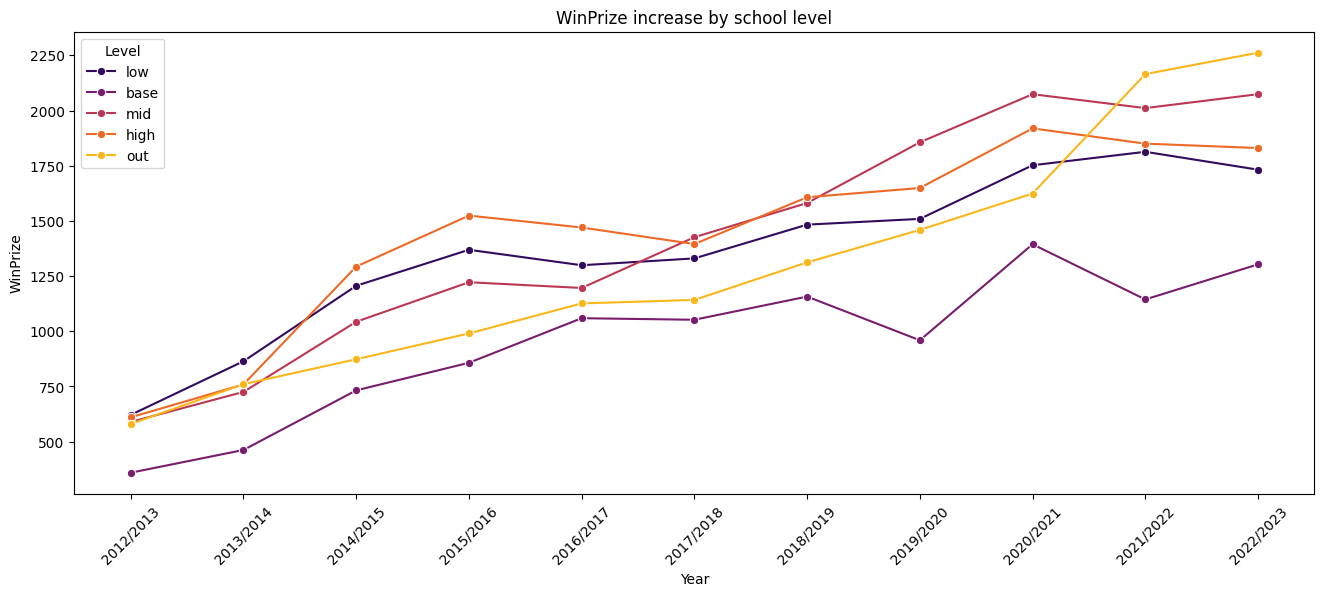

In [13]:
pl.figure(figsize=(16,6))
sns.lineplot(data=rpo3_grouped.groupby(['Year', 'Level'])['WinPrize'].sum().reset_index(), 
             x="Year", y="WinPrize", hue='Level', palette="inferno", style='Level', markers='o', dashes=False)
pl.xticks(rotation=45) 
pl.title('WinPrize increase by school level')

## Validation

In [14]:
def rmse(x:pd.Series, y:pd.Series) -> np.float64:
    return np.sqrt(((x - y)**2).mean())

In [15]:
def mape(forecasted:pd.Series, origin:pd.Series) -> np.float64:
    return abs((forecasted - origin)/origin).mean()*100

In [16]:
def mae(forecasted:pd.Series, origin:pd.Series) -> np.float64:
    return abs(forecasted - origin).mean()

In [17]:
def prophet_plot_diagnostics(x, resid, lags=10, fig=None, figsize=None):
        """
        Diagnostic plots for standardized residuals

        Parameters
        ----------
        lags : int, optional
            Number of lags to include in the correlogram. Default is 10.
        fig : Figure, optional
            If given, subplots are created in this figure instead of in a new
            figure. Note that the 2x2 grid will be created in the provided
            figure using `fig.add_subplot()`.
        figsize : tuple, optional
            If a figure is created, this argument allows specifying a size.
            The tuple is (width, height).

        Notes
        -----
        Produces a 2x2 plot grid with the following plots (ordered clockwise
        from top left):

        1. Standardized residuals over time
        2. Histogram plus estimated density of standardized residuals, along
           with a Normal(0,1) density plotted for reference.
        3. Normal Q-Q plot, with Normal reference line.
        4. Correlogram

        See Also
        --------
        statsmodels.graphics.gofplots.qqplot
        statsmodels.graphics.tsaplots.plot_acf
        """
        # from statsmodels.graphics.utils import _import_mpl, create_mpl_fig

        # _import_mpl()
        # fig = create_mpl_fig(fig, figsize)
        # Eliminate residuals associated with burned or diffuse likelihoods
        # resid = model_result.resid

        # Top-left: residuals vs time
        ax = fig.add_subplot(221)
        
        nobs = resid.shape[0]
        # print(nobs)
        sigma2 = 1.0 / nobs * np.sum(resid**2, axis=0)
        std_resid = resid / np.sqrt(sigma2)
        ax.plot(x, std_resid)
        ax.hlines(0, x[0], x[-1], alpha=0.5)
        ax.set_xlim(x[0], x[-1])
        ax.set_title("Standardized residual")

        # Top-right: histogram, Gaussian kernel density, Normal density
        # Can only do histogram and Gaussian kernel density on the non-null
        # elements
        std_resid_nonmissing = std_resid[~(np.isnan(resid))]
        ax = fig.add_subplot(222)

        ax.hist(std_resid_nonmissing, density=True, label="Hist")

        kde = gaussian_kde(std_resid)
        xlim = (-1.96 * 2, 1.96 * 2)
        x = np.linspace(xlim[0], xlim[1])
        ax.plot(x, kde(x), label="KDE")
        ax.plot(x, norm.pdf(x), label="N(0,1)")
        ax.set_xlim(xlim)
        ax.legend()
        ax.set_title("Histogram plus estimated density")

        # Bottom-left: QQ plot
        ax = fig.add_subplot(223)
        from statsmodels.graphics.gofplots import qqplot

        qqplot(std_resid, line="s", ax=ax)
        ax.set_title("Normal Q-Q")

        # Bottom-right: Correlogram
        ax = fig.add_subplot(224)
        from statsmodels.graphics.tsaplots import plot_acf

        plot_acf(resid, ax=ax, lags=4)
        ax.set_title("Correlogram")

        ax.set_ylim(-1, 1)

        return fig

In [18]:
 def my_plot_diagnostics(model_result, lags=10, fig=None, figsize=None):
        """
        Diagnostic plots for standardized residuals

        Parameters
        ----------
        lags : int, optional
            Number of lags to include in the correlogram. Default is 10.
        fig : Figure, optional
            If given, subplots are created in this figure instead of in a new
            figure. Note that the 2x2 grid will be created in the provided
            figure using `fig.add_subplot()`.
        figsize : tuple, optional
            If a figure is created, this argument allows specifying a size.
            The tuple is (width, height).

        Notes
        -----
        Produces a 2x2 plot grid with the following plots (ordered clockwise
        from top left):

        1. Standardized residuals over time
        2. Histogram plus estimated density of standardized residuals, along
           with a Normal(0,1) density plotted for reference.
        3. Normal Q-Q plot, with Normal reference line.
        4. Correlogram

        See Also
        --------
        statsmodels.graphics.gofplots.qqplot
        statsmodels.graphics.tsaplots.plot_acf
        """
        from statsmodels.graphics.utils import _import_mpl, create_mpl_fig

        _import_mpl()
        fig = create_mpl_fig(fig, figsize)
        # Eliminate residuals associated with burned or diffuse likelihoods
        resid = model_result.resid

        # Top-left: residuals vs time
        ax = fig.add_subplot(221)
        if hasattr(model_result.model.data, "dates") and model_result.data.dates is not None:
            x = model_result.model.data.dates._mpl_repr()
            # x = x[model_result.model.hold_back :]
        else:
            print('alarmaaaaaaa-------------------------------------')
            # hold_back = model_result.model.hold_back
            # x = hold_back + np.arange(model_result.resid.shape[0])
     
        nobs = model_result.resid.shape[0]
        # print(nobs)
        sigma2 = 1.0 / nobs * np.sum(model_result.resid**2, axis=0)
        std_resid = resid / np.sqrt(sigma2)
        ax.plot(x, std_resid)
        ax.hlines(0, x[0], x[-1], alpha=0.5)
        ax.set_xlim(x[0], x[-1])
        ax.set_title("Standardized residual")

        # Top-right: histogram, Gaussian kernel density, Normal density
        # Can only do histogram and Gaussian kernel density on the non-null
        # elements
        std_resid_nonmissing = std_resid[~(np.isnan(resid))]
        ax = fig.add_subplot(222)

        ax.hist(std_resid_nonmissing, density=True, label="Hist")

        kde = gaussian_kde(std_resid)
        xlim = (-1.96 * 2, 1.96 * 2)
        x = np.linspace(xlim[0], xlim[1])
        ax.plot(x, kde(x), label="KDE")
        ax.plot(x, norm.pdf(x), label="N(0,1)")
        ax.set_xlim(xlim)
        ax.legend()
        ax.set_title("Histogram plus estimated density")

        # Bottom-left: QQ plot
        ax = fig.add_subplot(223)
        from statsmodels.graphics.gofplots import qqplot

        qqplot(std_resid, line="s", ax=ax)
        ax.set_title("Normal Q-Q")

        # Bottom-right: Correlogram
        ax = fig.add_subplot(224)
        from statsmodels.graphics.tsaplots import plot_acf

        plot_acf(resid, ax=ax, lags=4)
        ax.set_title("Correlogram")

        ax.set_ylim(-1, 1)

        return fig

In [19]:
s = np.array([0, 1, 4, -1])
t = np.array([s for _ in range(6)])
t

array([[ 0,  1,  4, -1],
       [ 0,  1,  4, -1],
       [ 0,  1,  4, -1],
       [ 0,  1,  4, -1],
       [ 0,  1,  4, -1],
       [ 0,  1,  4, -1]])

In [20]:
sps.shapiro(t)

ShapiroResult(statistic=0.8015149735102423, pvalue=0.00031189215929082074)

In [21]:
sps.ttest_1samp(t, popmean=0, axis=None)

TtestResult(statistic=2.563479777846623, pvalue=0.01737002672376727, df=23)

In [162]:
def validation_metrics(model, ts_data_vector, min_train_size=5, **model_kwargs):
    
    train_rmse = np.array([])
    test_rmse = np.array([])
    _aic = np.array([])
    test_mape = np.array([])
    test_mae = np.array([])
    test_conf = np.array([])
    alpha = 0.05
    resid_autocorr = np.array([])
    resid_mean_zero = np.array([])
    resid_norm = np.array([])
    resid_statty_adf = np.array([])
    resid_statty_kpss = np.array([])
    

    
    if model == DeepAREstimator:
        for end in range(min_train_size, ts_data_vector.shape[1]):

            rmse_arr = np.array([])
            mape_arr = np.array([])
            mae_arr = np.array([])
            conf_arr = np.array([])
            resid_arr = np.array([])
            
            train_df = ts_data_vector.iloc[:, :end]
            test_df = ts_data_vector.iloc[:, :end+1]

            train_ds = ListDataset([
                {
                    FieldName.TARGET: train_df.loc[level_idx].values,
                    FieldName.START: test_df.columns.min(),
                    FieldName.FEAT_STATIC_CAT: [level_idx]
                }
                for level_idx in train_df.index
            ], freq=model_kwargs['freq'])
            
            test_ds = ListDataset([
                {
                    FieldName.TARGET: test_df.loc[level_idx].values,
                    FieldName.START: test_df.columns.min(),
                    FieldName.FEAT_STATIC_CAT: [level_idx]
                }
                for level_idx in test_df.index
            ], freq=model_kwargs['freq'])


            estimator = model(**model_kwargs)
            predictor = estimator.train(train_ds)
            
            origin_test_ds = copy.deepcopy(test_ds)

            # Collecting fitted values and metrics on them 
            for loop in range(end):
                
                forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds, predictor=predictor)
                forecasts = list(forecast_it)
                tss = list(ts_it)
                evaluator = Evaluator(quantiles=[0.9])
                agg_metrics, item_metrics = evaluator(tss, forecasts)
                rmse_arr = np.append(rmse_arr, agg_metrics['RMSE'])
                mape_arr = np.append(mape_arr, agg_metrics['MAPE'])
                mae_arr = np.append(mae_arr, agg_metrics['abs_error'] / ts_data_vector.shape[0])
                conf = np.array([((np.quantile(forecasts[i].samples, .975) - np.quantile(forecasts[i].samples, .025)) / forecasts[i].samples.mean()) for i in range(len(forecasts))]).mean()
                conf_arr = np.append(conf_arr, conf*100)

                resid =  [forecasts[i].samples.mean() - test_ds[i]['target'][-1] for i in range(len(forecasts))]
                length = len(resid)
                if not resid_arr.size:
                    resid_arr = resid_arr.reshape(0, length)
                resid_arr = np.append(resid_arr, [resid], axis=0)

                for i in range(len(test_ds)):
                    test_ds[i]['target'] = test_ds[i]['target'][:-1]
                    
            resid_arr = resid_arr[::-1].T

            resid_mean_zero_pval = sps.ttest_1samp(resid_arr.T[:-1], popmean=0, axis=None)[1] > alpha
            resid_norm_pval = sps.shapiro(resid_arr.T[:-1])[1] > alpha
            resid_mean_zero = np.append(resid_mean_zero, resid_mean_zero_pval)
            resid_norm = np.append(resid_norm, resid_norm_pval)
            
            for ts_resid in resid_arr:
                resid_autocorr_pval = np.array([acorr_ljungbox(ts_resid[:-1], lags=2)['lb_pvalue'] > alpha]).all()
                resid_statty_adf_pval = adfuller(ts_resid[:-1])[1] < alpha
                resid_statty_kpss_pval = kpss(ts_resid[:-1])[1] > alpha

                resid_autocorr = np.append(resid_autocorr, resid_autocorr_pval)
                resid_statty_adf = np.append(resid_statty_adf, resid_statty_adf_pval)
                resid_statty_kpss = np.append(resid_statty_kpss, resid_statty_kpss_pval)

            test_rmse = np.append(test_rmse, rmse_arr[0])
            train_rmse = np.append(train_rmse, rmse_arr[1:].mean())
            test_mape = np.append(test_mape, mape_arr[0]*100)
            test_mae = np.append(test_mae, mae_arr[0])
            test_conf = np.append(test_conf, conf_arr[0])

            # # Just to draw plots
            # if end == ts_data_vector.shape[1]-1:
            #     fcast_group = []
            #     fcast_group_q = []
                

            #     forecast_it, ts_it = make_evaluation_predictions(dataset=origin_test_ds, predictor=predictor)
            #     forecasts = list(forecast_it)
            #     tss = list(ts_it)

            #     origin_tss = copy.deepcopy(tss)
            #     for _ in range(end):

            #         # for item in range(len(fcast_group)):
            #         #     for time in range(len(origin_test_ds)-1):
                    
            #         curr_fcast = [forecasts[i].samples.mean() for i in range(len(forecasts))]
            #         fcast_group.append(curr_fcast)
                    
            #         curr_fcast_q = [[np.quantile(forecasts[i].samples, .025), np.quantile(forecasts[i].samples, .975)] for i in range(len(forecasts))]
            #         fcast_group_q.append(curr_fcast_q)
                    

            #         for i in range(len(origin_test_ds)):
            #             origin_test_ds[i]['target'] = origin_test_ds[i]['target'][:-1]

            #         forecast_it, ts_it = make_evaluation_predictions(dataset=origin_test_ds, predictor=predictor)
            #         forecasts = list(forecast_it)
            #         tss = list(ts_it)

            #     fcast_group = np.array(fcast_group[::-1]).T

            #     #Draw plots
            #     for i in range(len(forecasts)):
            #         fig = pl.figure(figsize=(14, 7))
            #         fig = prophet_plot_diagnostics(origin_tss[i].index[:-1].to_timestamp(), fcast_group[i]-origin_tss[i].values.flatten()[:-1], fig=fig)
            #         pl.show()

            #     plot_prob_forecasts(origin_tss, fcast_group, np.array(fcast_group_q[::-1]).T)

    else:
        for ts in ts_data_vector:
            ts_train_rmse = np.array([])
            ts_test_rmse = np.array([])
            ts_test_mape = np.array([])
            ts_aic = np.array([])
            ts_test_mae = np.array([])
            ts_test_conf = np.array([])
            
            ts_resid_autocorr = np.array([])
            ts_resid_mean_zero = np.array([])
            ts_resid_norm = np.array([])
            ts_resid_statty_adf = np.array([])
            ts_resid_statty_kpss = np.array([])
            
                    
            for end in range(min_train_size, len(ts)):
                train = ts.iloc[:end]
                test = ts.iloc[end]
                    
                if model == Prophet:
                    model_fit = model(**model_kwargs).fit(train)
                    future = model_fit.make_future_dataframe(periods=1, freq='YS')
                    
                    forecast_df = model_fit.predict(future)
                    forecast = forecast_df.set_index('ds').iloc[-1, -1]
                    fittedvalues = forecast_df.set_index('ds').iloc[:-1, -1]
                    resid = fittedvalues - train.set_index('ds')['y']
    
                    train = train.set_index('ds')['y']
                    test = test['y']
                    conf = (forecast_df['yhat_upper'].iloc[-1] - forecast_df['yhat_lower'].iloc[-1]) / forecast_df.iloc[-1, -1] * 100
                    
                else:
                    # model_fit = model(train, **model_kwargs).model.fit()
                    pre_model = model(train, **model_kwargs)
                    if model == SARIMAX:
                        pre_model.initialize_approximate_diffuse()
                    
                    model_fit = pre_model.fit()
                    forecast = model_fit.forecast(1)  
                    fittedvalues = model_fit.fittedvalues
                    if model == SARIMAX:
                        fittedvalues = model_fit.fittedvalues[1:]

                    resid = fittedvalues - train                    
                    
                    if model == ExponentialSmoothing:
                        df_simul = model_fit.simulate(nsimulations=1, repetitions=200)
                        conf = (np.quantile(df_simul, .975) - np.quantile(df_simul, .025)) / forecast * 100
                        # if np.isnan(conf.values):
                        #     print(df_simul)
                        #     print(df_simul.isna().sum(axis=1))
                        #     print(np.quantile(df_simul, .975))
                        #     print(np.quantile(df_simul, .025))
                            
                            

                    else:
                        ci = model_fit.get_prediction(start=end, end=end).conf_int(alpha=0.05)
                        conf = (ci.iloc[0, 1] - ci.iloc[0, 0]) / forecast * 100
                
                
                ts_train_rmse = np.append(ts_train_rmse, rmse(train, fittedvalues))
                ts_test_rmse = np.append(ts_test_rmse, rmse(test, forecast))
                ts_test_mape = np.append(ts_test_mape, mape(forecast, test))
                ts_test_mae = np.append(ts_test_mae, mae(test, forecast))
                ts_test_conf = np.append(ts_test_conf, conf)
                
                #Residuals
                resid = resid.dropna()
                resid_mean_zero_pval = sps.ttest_1samp(resid, popmean=0)[1] > alpha
                resid_autocorr_pval = np.array([acorr_ljungbox(resid, lags=2)['lb_pvalue'] > alpha]).all()
                resid_norm_pval = sps.shapiro(resid)[1] > alpha
                resid_statty_adf_pval = adfuller(resid)[1] < alpha
                resid_statty_kpss_pval = kpss(resid)[1] > alpha
                
                ts_resid_autocorr = np.append(ts_resid_autocorr, resid_autocorr_pval)
                ts_resid_mean_zero = np.append(ts_resid_mean_zero, resid_mean_zero_pval)
                ts_resid_norm = np.append(ts_resid_norm, resid_norm_pval)
                ts_resid_statty_adf = np.append(ts_resid_statty_adf, resid_statty_adf_pval)
                ts_resid_statty_kpss = np.append(ts_resid_statty_kpss, resid_statty_kpss_pval)
                
                
                if model != Prophet:
                    ts_aic = np.append(ts_aic, model_fit.aic)
                
                # print(model_fit.params)
    
                if end == len(ts)-1:                    
                    
                    # print(model_fit.summary())
                    # print(model_fit.model_orders)
                    
                    
                    # print(model_fit.params)
                    
                    
                    if model == Prophet:
                        fig = pl.figure(figsize=(14, 7))
                        fig = prophet_plot_diagnostics(forecast_df['ds'][:-1].values, forecast_df.set_index('ds')['yhat'][:-1]-train, fig=fig)
                        pl.show()
                    
                        pl.plot(ts.set_index('ds')['y'], marker="o", color="black", label='origin')
                        # print(ts)
                        pl.plot(fittedvalues, marker="o", color="c", label='Prophet_fit', alpha=0.5)
                        pl.plot(forecast_df.iloc[-1, 0], forecast, marker="o", color="c", label='Prophet_forcast')
                        pl.title('Prophet model')
                        pl.ylabel('WinPrize')
                        pl.xlabel('Year')
                        pl.legend()
                        pl.show()
                        model_fit.plot(forecast_df)
                        pass
                    elif model == AutoReg:
                        # fig = pl.figure(figsize=(14, 7))
                        # fig = model_fit.plot_diagnostics(fig=fig, lags=model_kwargs['lags']+3)
                        # pl.show()

                        # pl.plot(ts, marker="o", color="black", label='origin')
                        # # print(ts)
                        # pl.plot(fittedvalues, marker="o", color="c", label='AR_fit', alpha=0.5)
                        # pl.plot(ts.index[-1], forecast, marker="o", color="c", label='AR_forcast')
                        # pl.title('AR model')
                        # pl.ylabel('WinPrize')
                        # pl.xlabel('Year')
                        # pl.legend()
                        # pl.show()
                        pass

                    elif model == SARIMAX:
                        # fig = pl.figure(figsize=(14, 7))
                        # fig = my_plot_diagnostics(model_fit, fig=fig)
                        # pl.show()
                    
                    
                        # # pl.plot(ts.set_index('ds')['y'], marker="o", color="black", label='origin')
                        # pl.plot(ts, marker="o", color="black", label='origin')
                        # # print(ts)
                        # pl.plot(fittedvalues[1:], marker="o", color="c", label='ARIMA_fit', alpha=0.5)
                        # pl.plot(ts.index[-1], forecast, marker="o", color="c", label='ARIMA_forcast')
                        # pl.title('ARIMA model')
                        # pl.ylabel('WinPrize')
                        # pl.xlabel('Year')
                        # pl.legend()
                        # pl.show()
                        pass
                        
                    else:
                        # fig = pl.figure(figsize=(14, 7))
                        # fig = my_plot_diagnostics(model_fit, fig=fig)
                        # pl.show()
                    
                    
                        # # pl.plot(ts.set_index('ds')['y'], marker="o", color="black", label='origin')
                        # pl.plot(ts, marker="o", color="black", label='origin')
                        # # print(ts)
                        # pl.plot(fittedvalues, marker="o", color="c", label='ES_fit', alpha=0.5)
                        # pl.plot(ts.index[-1], forecast, marker="o", color="c", label='Es_forcast')
                        # pl.title('ES model')
                        # pl.ylabel('WinPrize')
                        # pl.xlabel('Year')
                        # pl.legend()
                        # pl.show()
                        pass
    
            if not test_rmse.size:
                length = len(ts_train_rmse)
                train_rmse = train_rmse.reshape(0, length)
                test_rmse = test_rmse.reshape(0, length)
                test_mape = test_mape.reshape(0, length)
                _aic = _aic.reshape(0, length)
                test_conf = test_conf.reshape(0, length)
                test_mae = test_mae.reshape(0, length)
                
                resid_autocorr = resid_autocorr.reshape(0, length) 
                resid_mean_zero = resid_mean_zero.reshape(0, length) 
                resid_norm = resid_norm.reshape(0, length) 
                resid_statty_adf = resid_statty_adf.reshape(0, length) 
                resid_statty_kpss = resid_statty_kpss.reshape(0, length) 
                
                
            train_rmse = np.append(train_rmse, [ts_train_rmse], axis=0)
            test_rmse = np.append(test_rmse, [ts_test_rmse], axis=0)
            test_mape = np.append(test_mape, [ts_test_mape], axis=0)
            test_conf = np.append(test_conf, [ts_test_conf], axis=0)
            test_mae = np.append(test_mae, [ts_test_mae], axis=0)

            resid_autocorr = np.append(resid_autocorr, [ts_resid_autocorr], axis=0)
            resid_mean_zero = np.append(resid_mean_zero, [ts_resid_mean_zero], axis=0)
            resid_norm = np.append(resid_norm, [ts_resid_norm], axis=0)
            resid_statty_adf = np.append(resid_statty_adf, [ts_resid_statty_adf], axis=0)
            resid_statty_kpss = np.append(resid_statty_kpss, [ts_resid_statty_kpss], axis=0)
            
            if model != Prophet:
                _aic = np.append(_aic, [ts_aic], axis=0)
            
    # print('.........................Train RMSE............................................')
    # print(train_rmse)
    # print('.........................Test RMSE............................................')
    # print(test_rmse)
    # print('.........................AIC............................................')
    # print(_aic)
    # print('.........................Test MAPE............................................')
    # print(test_mape)
    # print('.........................Test MAE............................................')
    # print(test_mae)
    # print('.........................Test conf............................................')
    # print(test_conf)
    # print('.........................Residuals............................................')
    # print('.........................Autocorr............................................')
    # print(resid_autocorr)
    # print('.........................Mean zero............................................')
    # print(resid_mean_zero)
    # print('.........................Norm............................................')
    # print(resid_norm)
    # print('.........................Statty ADF............................................')
    # print(resid_statty_adf)
    # print('.........................Statty KPSS............................................')
    # print(resid_statty_kpss)
    
    
    
    
    return np.median(train_rmse), test_rmse.mean(), _aic.mean(), np.mean(test_mape), test_mae.mean(), test_conf[~np.isnan(test_conf)].mean(),  \
            resid_autocorr.mean(), resid_mean_zero.mean(), resid_norm.mean(), resid_statty_adf.mean(), resid_statty_kpss.mean()
            
    

In [23]:
def plot_prob_forecasts(ts_entries, fcast_group, fcast_group_q):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"]
    prediction_index = ts_entries[0].index[1:]
    fig, axes = pl.subplots(3, 2, figsize=(20, 8))
    axes = axes.ravel()
    for idx, ax in enumerate(axes):
        if idx == 5:
            continue
        ts_entries[idx].plot(ax=ax)  # plot the time series
        ax.plot(prediction_index, fcast_group[idx], color="r")        
        ax.fill_between(prediction_index, fcast_group_q[0][idx], fcast_group_q[1][idx], alpha=0.5, color='r')
        # ax.axvline(prediction_index[], color="r")
        # ax.text(prediction_index[0], 0.99, forecast_entries[idx].start_date, color='r', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())
        ax.legend(legend, loc="upper left")
        ax.grid(True)
    pl.show()

# np.random.seed(7)
# plot_indices = [np.random.choice(len(tss)) for _ in range(6)]
# ts_entries = [tss[idx] for idx in range()]
# forecast_entries = [forecasts[idx] for idx in plot_indices]
# plot_prob_forecasts(
#     tss,
#     forecasts
# )

In [24]:
temp = rpo3_grouped.groupby(['Year', 'Level'], observed=False)['WinPrize'].sum().reset_index()
temp['Year'] = temp['Year'].str[-4:]
temp['Year'] = temp['Year'].apply(lambda x: pd.to_datetime(x, format='%Y'))
ts_data = [temp[temp.Level == level].drop('Level', axis=1).set_index('Year').WinPrize for level in temp.Level.unique()]

for ts in ts_data:
    ts.index.freq = 'YS'

# ts_data

In [25]:
temp.columns = ['ds', 'Level', 'y']
prophet_ts_data = [temp[temp['Level'] == level].drop('Level', axis=1).reset_index(drop=True) for level in temp.Level.unique()]
# prophet_ts_data

### AR validation

!Note:

Добавить регрессоры, добавить Box-cox, добавить интеграцию, смотреть предсказательные интервалы

In [175]:
# validation_metrics(ar_select_order, ts_data, min_train_size=7, maxlag=1, trend='n', old_names=False)
# Best
# validation_metrics(AutoReg, ts_data, min_train_size=6, lags=1, trend='c', old_names=False)

ar_metrics = validation_metrics(AutoReg, ts_data, min_train_size=6, lags=1, trend='n', old_names=False)
ar_metrics

(146.74564498719548,
 160.47864973704156,
 93.04616757364447,
 10.3143656942649,
 160.47864973704156,
 35.78295078038951,
 1.0,
 1.0,
 1.0,
 0.36,
 0.96)

In [86]:
ar_test_rmse_df = pd.DataFrame(columns=['lag1', 'lag2', 'lag3'], index=['n', 'c', 't', 'ct'])
ar_aic_df = pd.DataFrame(columns=['lag1', 'lag2', 'lag3'], index=['n', 'c', 't', 'ct'])
ar_test_mape_df = pd.DataFrame(columns=['lag1', 'lag2', 'lag3'], index=['n', 'c', 't', 'ct'])
ar_autocorr_df = pd.DataFrame(columns=['lag1', 'lag2', 'lag3'], index=['n', 'c', 't', 'ct'])
ar_mean_zero_df = pd.DataFrame(columns=['lag1', 'lag2', 'lag3'], index=['n', 'c', 't', 'ct'])
ar_norm_df = pd.DataFrame(columns=['lag1', 'lag2', 'lag3'], index=['n', 'c', 't', 'ct'])
ar_kpss_df = pd.DataFrame(columns=['lag1', 'lag2', 'lag3'], index=['n', 'c', 't', 'ct'])



for trend in ['n', 'c', 't', 'ct']:
    for lag in range(1, 4):
        model_score = validation_metrics(AutoReg, ts_data, min_train_size=5+lag+int('t' in trend), lags=lag, trend=trend, old_names=False)

        ar_test_rmse_df.loc[trend, f'lag{lag}'] = model_score[1]
        ar_aic_df.loc[trend, f'lag{lag}'] = model_score[2]
        ar_test_mape_df.loc[trend, f'lag{lag}'] = model_score[3]
        ar_autocorr_df.loc[trend, f'lag{lag}'] = model_score[6]
        ar_mean_zero_df.loc[trend, f'lag{lag}'] = model_score[7]
        ar_norm_df.loc[trend, f'lag{lag}'] = model_score[8]
        ar_kpss_df.loc[trend, f'lag{lag}'] = model_score[10]
        
    

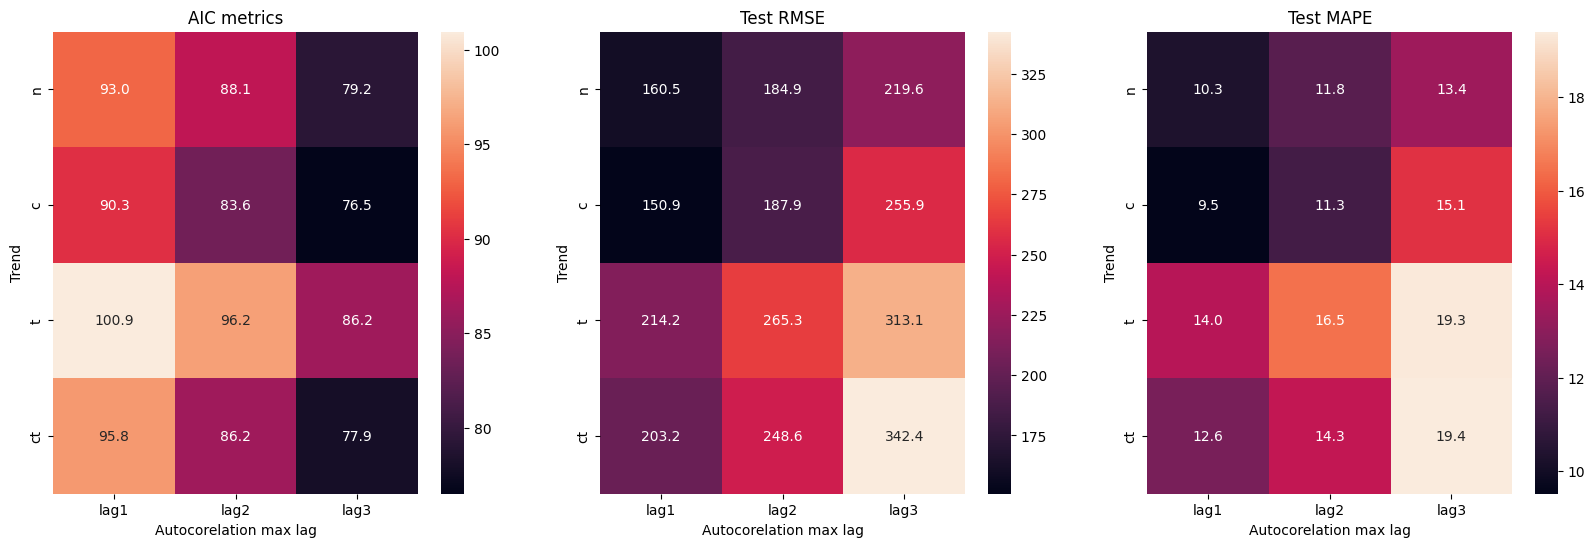

In [87]:
# fig = create_mpl_fig(fig, figsize)
pl.figure(figsize=(20, 6))

pl.subplot(1, 3, 1)
sns.heatmap(data = ar_aic_df.astype(np.float64), annot=True, fmt='.1f')
pl.title('AIC metrics')
pl.xlabel('Autocorelation max lag')
pl.ylabel('Trend')

pl.subplot(1, 3, 2)
sns.heatmap(data = ar_test_rmse_df.astype(np.float64), annot=True, fmt='.1f')
pl.title('Test RMSE')
pl.xlabel('Autocorelation max lag')
pl.ylabel('Trend')

pl.subplot(1, 3, 3)
sns.heatmap(data = ar_test_mape_df.astype(np.float64), annot=True, fmt='.1f')
pl.title('Test MAPE')
pl.xlabel('Autocorelation max lag')
pl.ylabel('Trend')

pl.show()

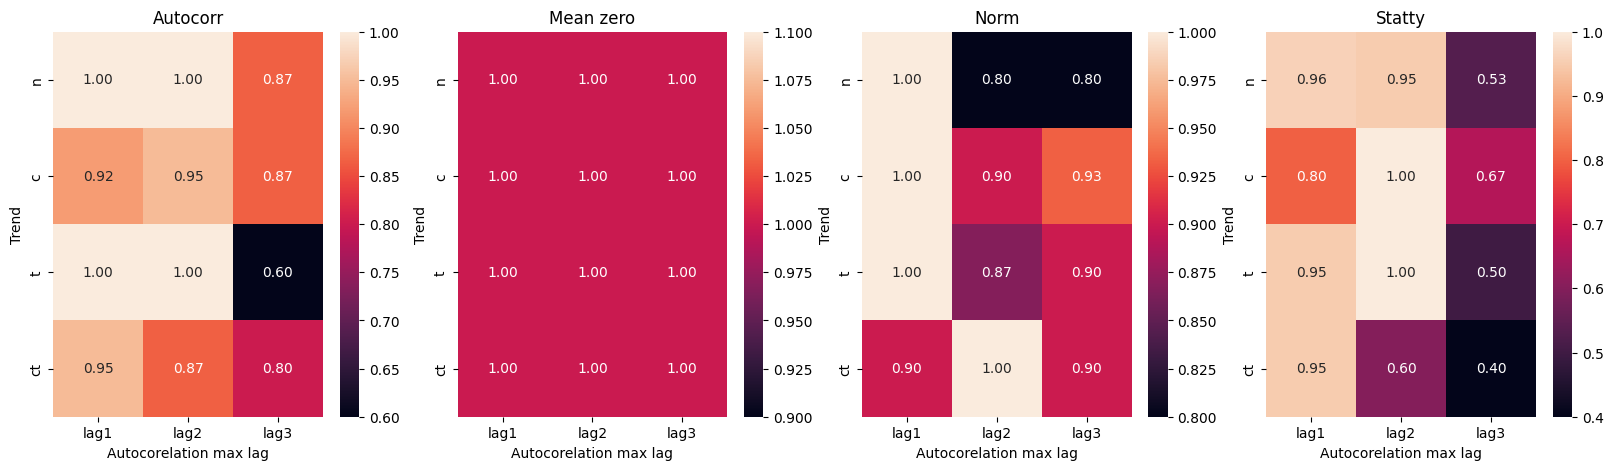

In [89]:
pl.figure(figsize=(20, 5))

pl.subplot(1, 4, 1)
sns.heatmap(data = ar_autocorr_df.astype(np.float64), annot=True, fmt='.2f')
pl.title('Autocorr')
pl.xlabel('Autocorelation max lag')
pl.ylabel('Trend')

pl.subplot(1, 4, 2)
sns.heatmap(data = ar_mean_zero_df.astype(np.float64), annot=True, fmt='.2f')
pl.title('Mean zero')
pl.xlabel('Autocorelation max lag')
pl.ylabel('Trend')

pl.subplot(1, 4, 3)
sns.heatmap(data = ar_norm_df.astype(np.float64), annot=True, fmt='.2f')
pl.title('Norm')
pl.xlabel('Autocorelation max lag')
pl.ylabel('Trend')

pl.subplot(1, 4, 4)
sns.heatmap(data = ar_kpss_df.astype(np.float64), annot=True, fmt='.2f')
pl.title('Statty')
pl.xlabel('Autocorelation max lag')
pl.ylabel('Trend')

pl.show()

### ES validation

!Note:

Добавить регрессоры, добавить интеграцию, смотреть предсказательные интервалы

In [176]:
#Best
# validation_metrics(ExponentialSmoothing, ts_data, min_train_size=6, trend='add', damped_trend=False, use_boxcox=True, initialization_method='estimated')

es_metrics = validation_metrics(ExponentialSmoothing, ts_data, min_train_size=6, trend='add', damped_trend=False, use_boxcox=True, initialization_method='estimated')
es_metrics

C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

(101.01313176365144,
 145.75515506026193,
 81.13138693211958,
 9.275581058967209,
 145.75515506026193,
 27.408308165012965,
 1.0,
 1.0,
 1.0,
 0.48,
 1.0)

In [62]:
es_test_rmse_df = pd.DataFrame(columns=['simple', 'bc', 'dt', 'dt_bc'], index=[None, 'add', 'mul'])
es_aic_df = pd.DataFrame(columns=['simple', 'bc', 'dt', 'dt_bc'], index=[None, 'add', 'mul'])
es_test_mape_df = pd.DataFrame(columns=['simple', 'bc', 'dt', 'dt_bc'], index=[None, 'add', 'mul'])

for trend in [None, 'add', 'mul']:
    rmse_trend_list = []
    aic_trend_list = []
    mape_trend_list = []
    
    for dumped_trend in [False, True]:
        if not trend and dumped_trend:
            rmse_trend_list.append(None)
            rmse_trend_list.append(None)
            aic_trend_list.append(None)
            aic_trend_list.append(None)
            mape_trend_list.append(None)
            mape_trend_list.append(None)
            continue
            
        for boxcox in [False, True]:
            model_score = validation_metrics(ExponentialSmoothing, ts_data, min_train_size=6, trend=trend, damped_trend=dumped_trend, use_boxcox=boxcox, initialization_method='estimated')
            rmse_trend_list.append(model_score[1])
            aic_trend_list.append(model_score[2])
            mape_trend_list.append(model_score[3])

    es_test_rmse_df.loc[trend] = rmse_trend_list
    es_aic_df.loc[trend] = aic_trend_list
    es_test_mape_df.loc[trend] = mape_trend_list
    
    

C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

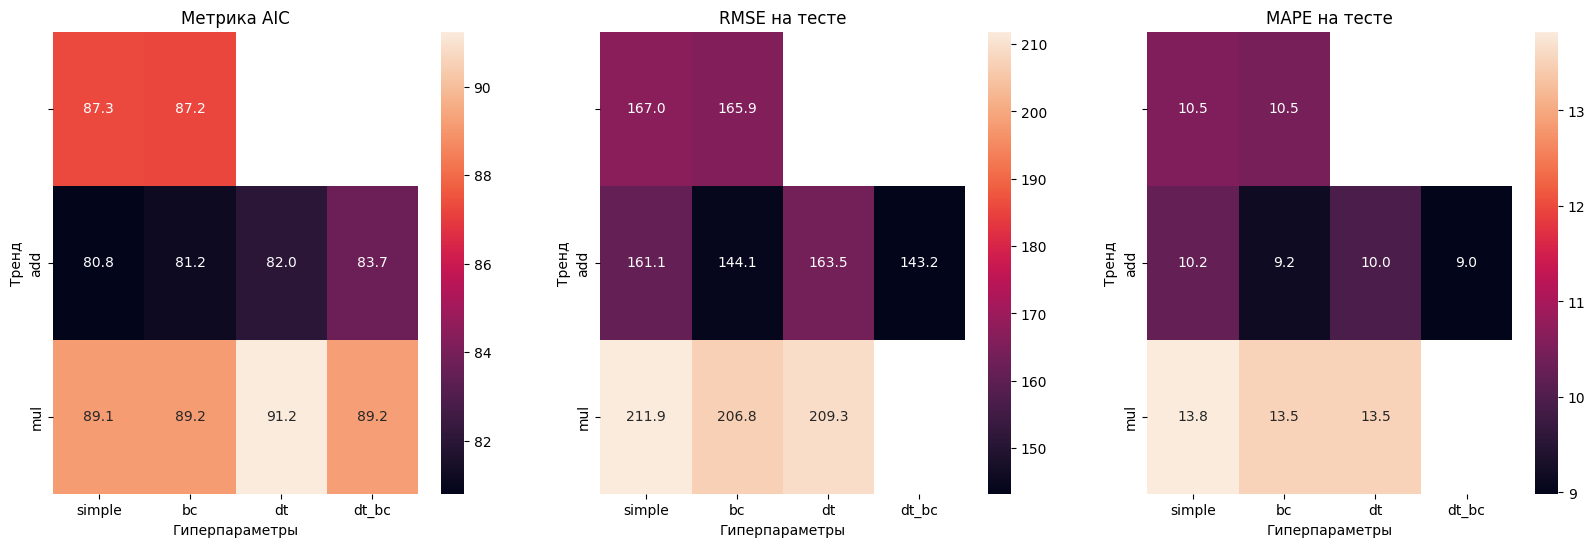

In [63]:
pl.figure(figsize=(20, 6))

pl.subplot(1, 3, 1)
sns.heatmap(data = es_aic_df.astype(np.float64), annot=True, fmt='.1f')
pl.title('Метрика AIC')
pl.xlabel('Гиперпараметры')
pl.ylabel('Тренд')

pl.subplot(1, 3, 2)
es_test_rmse_df.iloc[2, 3] = None
sns.heatmap(data = es_test_rmse_df.astype(np.float64), annot=True, fmt='.1f')
pl.title('RMSE на тесте')
pl.xlabel('Гиперпараметры')
pl.ylabel('Тренд')

pl.subplot(1, 3, 3)
es_test_mape_df.iloc[2, 3] = None
sns.heatmap(data = es_test_mape_df.astype(np.float64), annot=True, fmt='.1f')
pl.title('MAPE на тесте')
pl.xlabel('Гиперпараметры')
pl.ylabel('Тренд')

pl.show()

### ARIMA validation

!Note:

Добавить регрессоры, добавить Box-cox, смотреть доверительные интевалы

#### Brute force

In [177]:
##### Best
# validation_metrics(SARIMAX, ts_data, min_train_size=5, order=(0, 1, 0), trend=[1, 0, 0], time_varying_regression=False, concentrate_scale=False)

arima_metrics = validation_metrics(SARIMAX, ts_data, min_train_size=6, order=(0, 0, 0), trend=[1, 1, 0], time_varying_regression=False, concentrate_scale=False)
arima_metrics

(96.13042983175983,
 145.67635216202547,
 104.67378681719143,
 9.28347876833719,
 145.67635216202547,
 23.027405910719462,
 1.0,
 1.0,
 1.0,
 0.2,
 0.96)

In [76]:
pd.set_option('display.max_columns', 32)
arima_test_rmse_df = pd.DataFrame(columns=[f'({p}, {d}, {q})' for p in range(4) for d in range(2) for q in range(4)], index=['n', 'c', 't', 'ct'])
arima_train_rmse_df = pd.DataFrame(columns=[f'({p}, {d}, {q})' for p in range(4) for d in range(2) for q in range(4)], index=['n', 'c', 't', 'ct'])
arima_aic_df = pd.DataFrame(columns=[f'({p}, {d}, {q})' for p in range(4) for d in range(2) for q in range(4)], index=['n', 'c', 't', 'ct'])
arima_test_mape_df = pd.DataFrame(columns=[f'({p}, {d}, {q})' for p in range(4) for d in range(2) for q in range(4)], index=['n', 'c', 't', 'ct'])
arima_autocorr_df = pd.DataFrame(columns=[f'({p}, {d}, {q})' for p in range(4) for d in range(2) for q in range(4)], index=['n', 'c', 't', 'ct'])
arima_mean_zero_rmse_df = pd.DataFrame(columns=[f'({p}, {d}, {q})' for p in range(4) for d in range(2) for q in range(4)], index=['n', 'c', 't', 'ct'])
arima_norm_df = pd.DataFrame(columns=[f'({p}, {d}, {q})' for p in range(4) for d in range(2) for q in range(4)], index=['n', 'c', 't', 'ct'])
arima_kpss_mape_df = pd.DataFrame(columns=[f'({p}, {d}, {q})' for p in range(4) for d in range(2) for q in range(4)], index=['n', 'c', 't', 'ct'])


i = 0
# arima_test_rmse_df
for trend in ['n', 'c', 't', 'ct']:
    for p in range(4):
        for d in range(2):
            for q in range(4):
                # print(i)
                # i += 1

                # if (p, d, q) == (2, 1, 2) and trend in ['c', 't']

                model_score = validation_metrics(SARIMAX, ts_data, min_train_size=6, order=(p, d, q), trend=trend, time_varying_regression=False, concentrate_scale=False)
        
                arima_train_rmse_df.loc[trend, f'({p}, {d}, {q})'] = model_score[0]
                arima_test_rmse_df.loc[trend, f'({p}, {d}, {q})'] = model_score[1]
                arima_aic_df.loc[trend, f'({p}, {d}, {q})'] = model_score[2]
                arima_test_mape_df.loc[trend, f'({p}, {d}, {q})'] = model_score[3]
                arima_autocorr_df.loc[trend, f'({p}, {d}, {q})'] = model_score[6] 
                arima_mean_zero_rmse_df.loc[trend, f'({p}, {d}, {q})'] = model_score[7] 
                arima_norm_df.loc[trend, f'({p}, {d}, {q})'] = model_score[8] 
                arima_kpss_mape_df.loc[trend, f'({p}, {d}, {q})'] = model_score[10] 
                
                
        
    

C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters

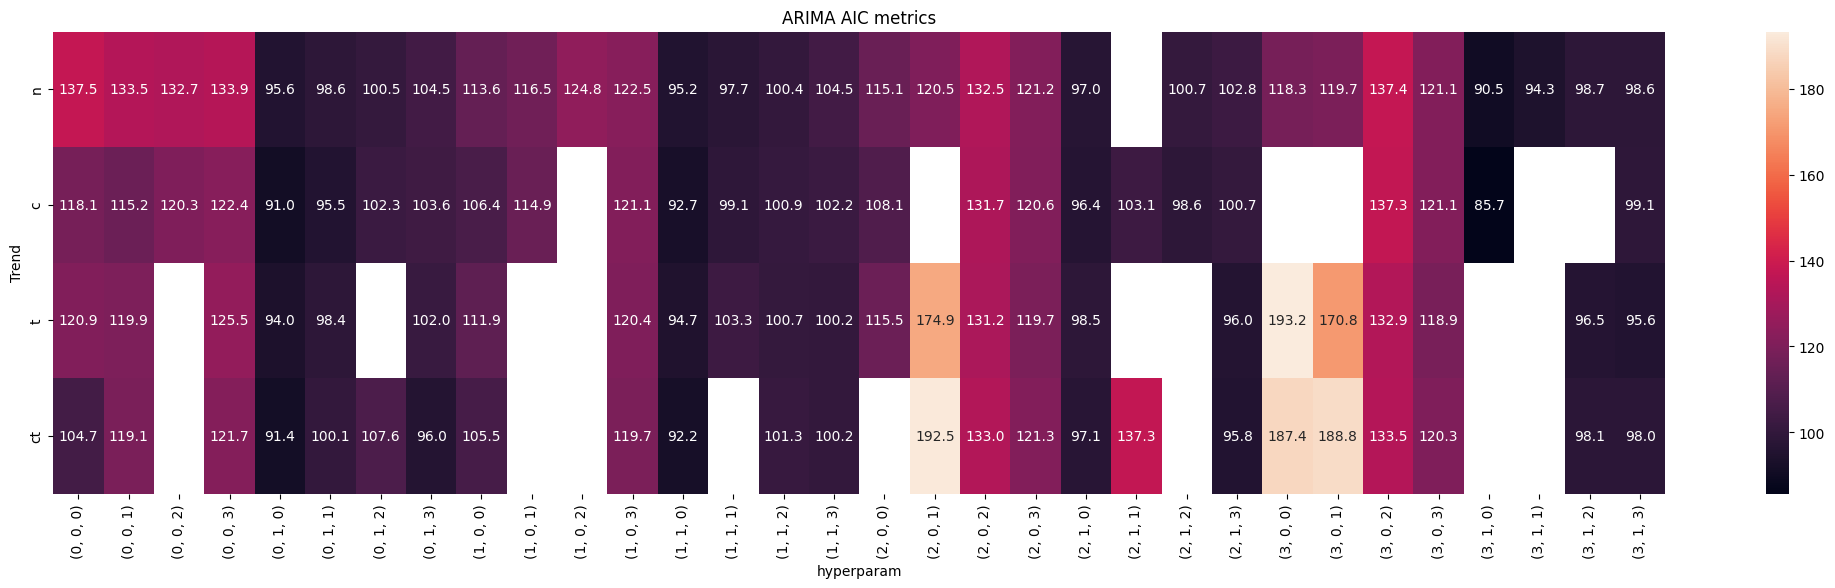

In [77]:
pl.figure(figsize=(26, 6))

data = arima_aic_df[arima_aic_df < 200]

# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.1f')
pl.title('ARIMA AIC metrics')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

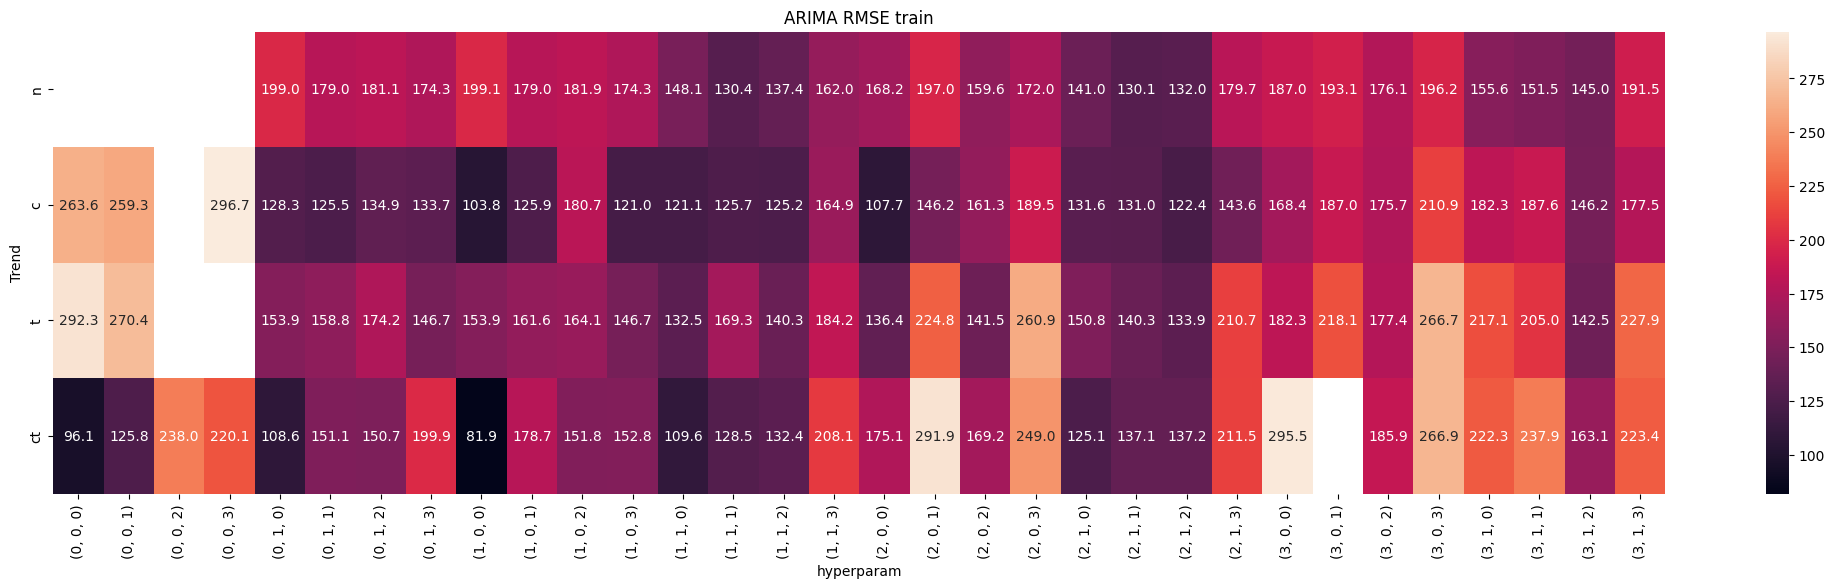

In [111]:
pl.figure(figsize=(26, 6))

data = arima_train_rmse_df[arima_train_rmse_df < 300]

# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.1f')
pl.title('ARIMA RMSE train')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

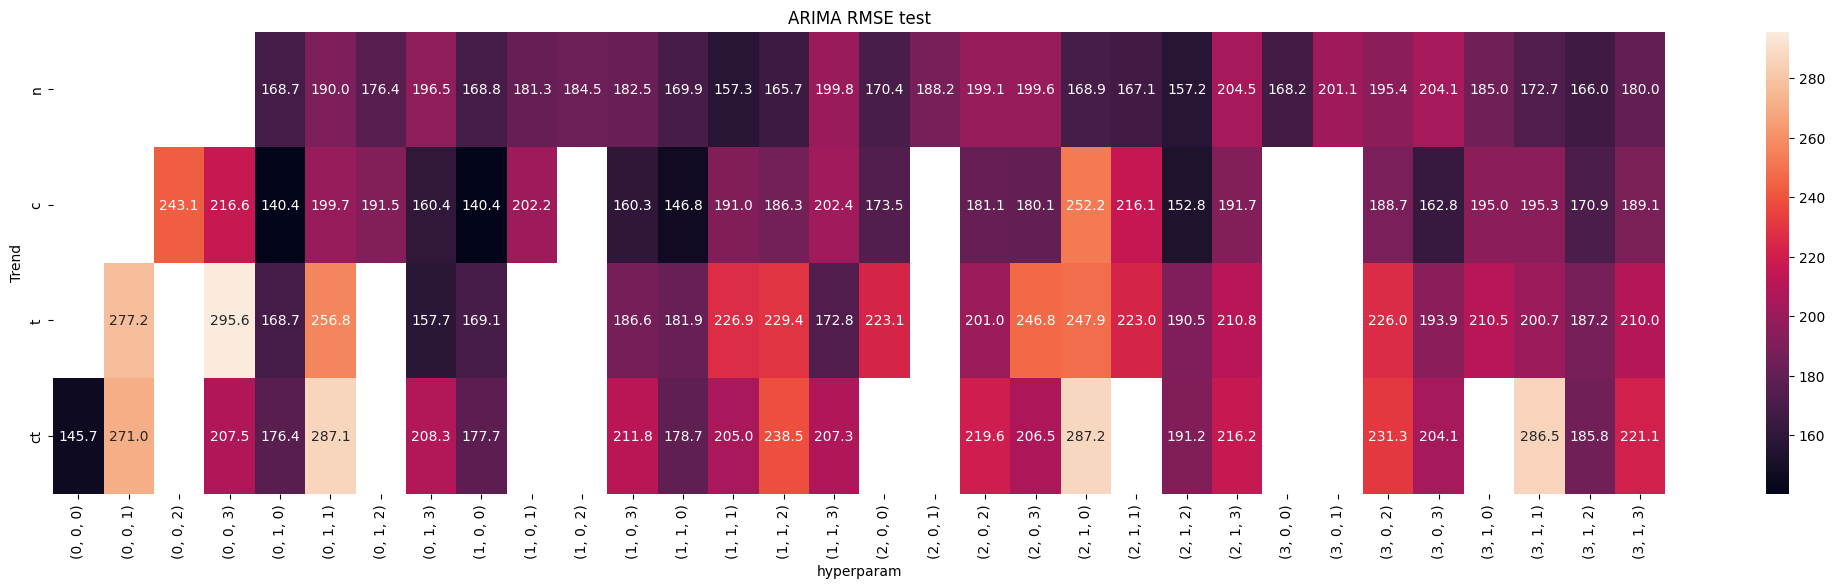

In [113]:
pl.figure(figsize=(26, 6))


# pl.subplot(1, 3, 1)
data = arima_test_rmse_df[arima_test_rmse_df < 300]
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.1f')
pl.title('ARIMA RMSE test')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

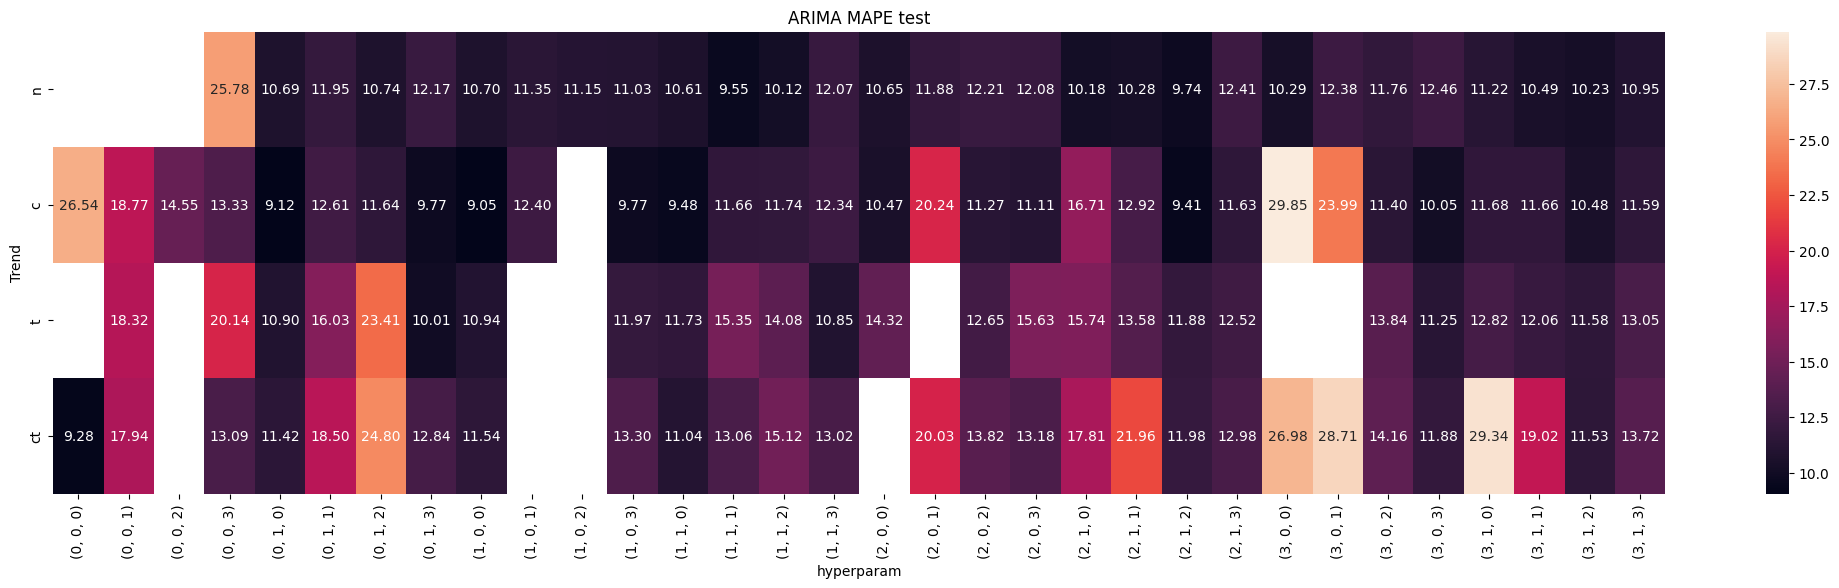

In [80]:
pl.figure(figsize=(26, 6))
# arima_test_mape_df.loc['ct', '(1, 0, 2)'] = None
# arima_test_mape_df.loc['t', '(1, 0, 2)'] = None
# arima_test_mape_df.loc['c', '(1, 0, 2)'] = None
# arima_test_mape_df.loc['ct', '(0, 0, 2)'] = None
# arima_test_mape_df.loc['t', '(0, 0, 2)'] = None
# arima_test_mape_df.loc['n', '(0, 0, 0)'] = None
# arima_test_mape_df.loc['n', '(0, 0, 1)'] = None

data = arima_test_mape_df[arima_test_mape_df < 30]
# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.2f')
pl.title('ARIMA MAPE test')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

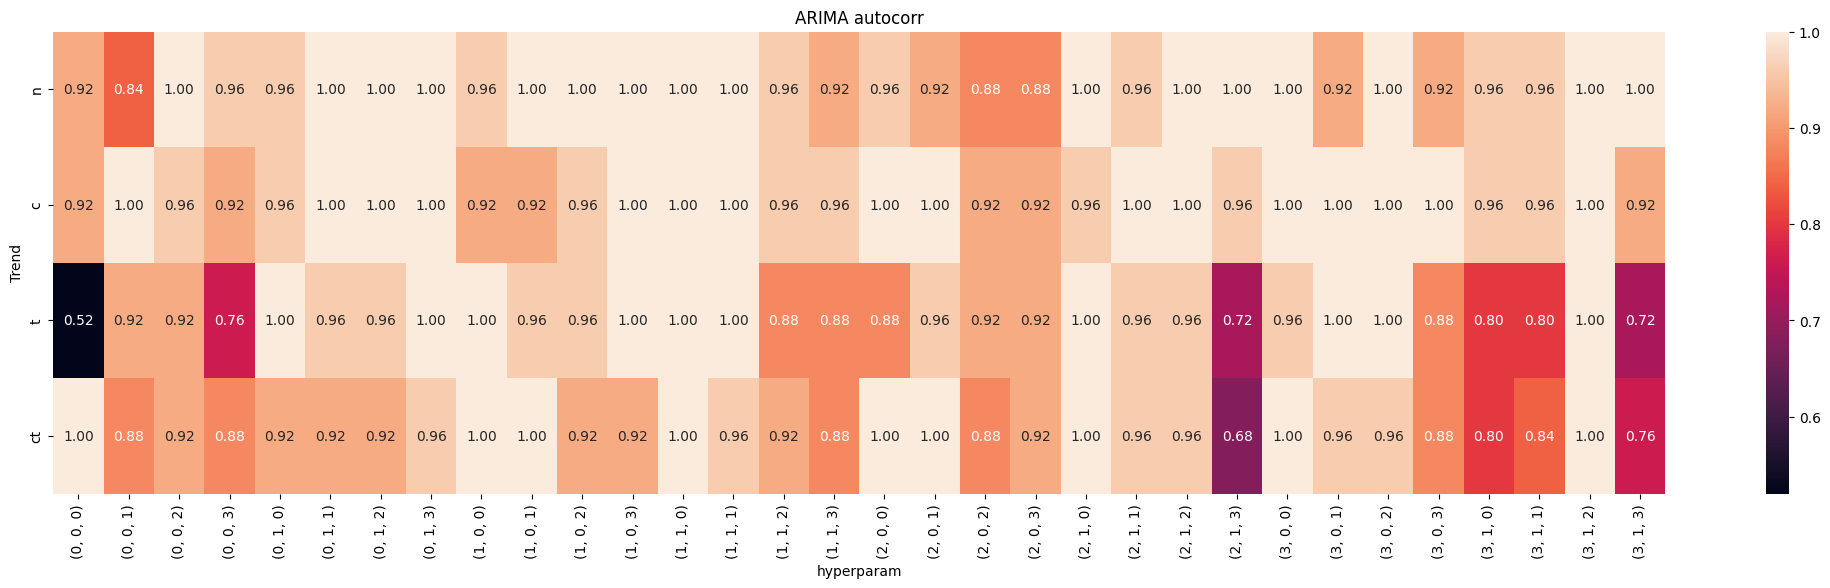

In [81]:
pl.figure(figsize=(26, 6))

data = arima_autocorr_df
# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.2f')
pl.title('ARIMA autocorr')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

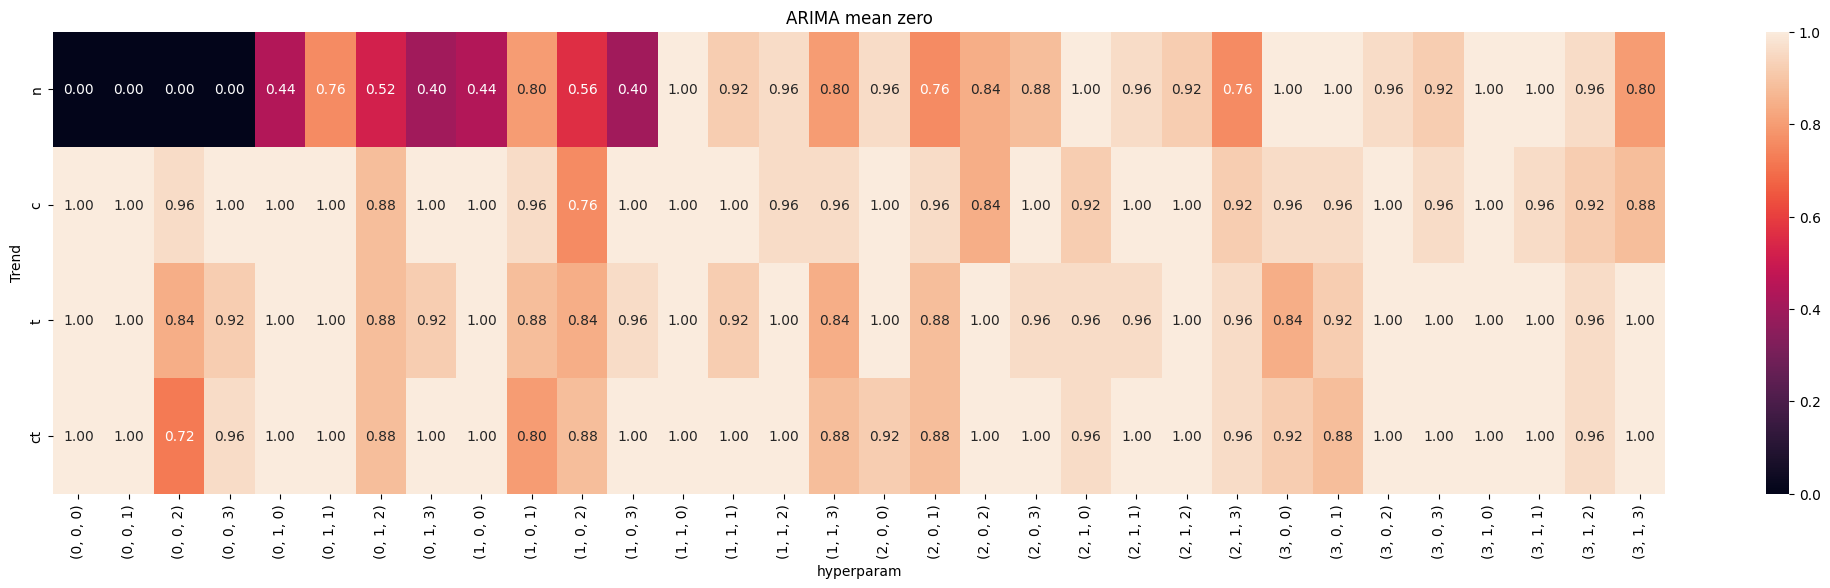

In [82]:
pl.figure(figsize=(26, 6))

data = arima_mean_zero_rmse_df
# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.2f')
pl.title('ARIMA mean zero')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

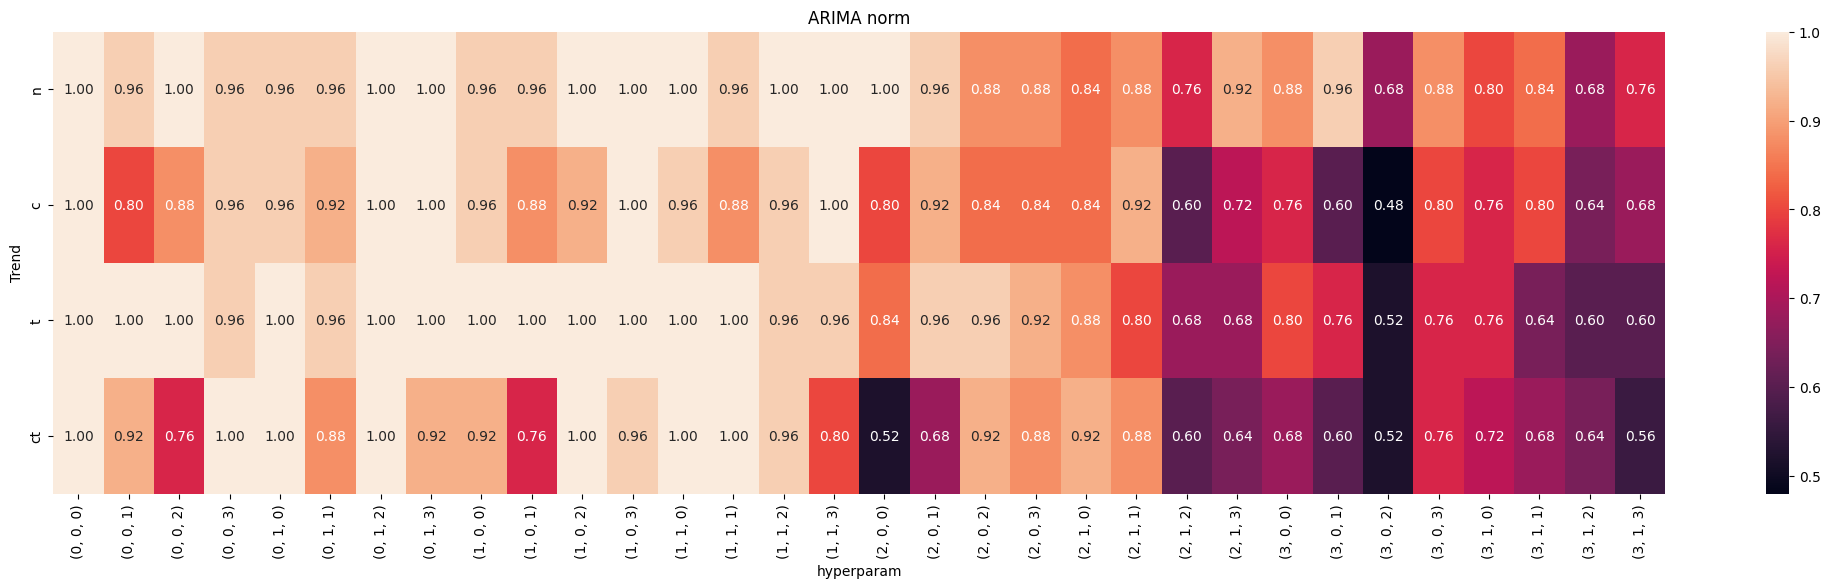

In [83]:
pl.figure(figsize=(26, 6))

data = arima_norm_df
# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.2f')
pl.title('ARIMA norm')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

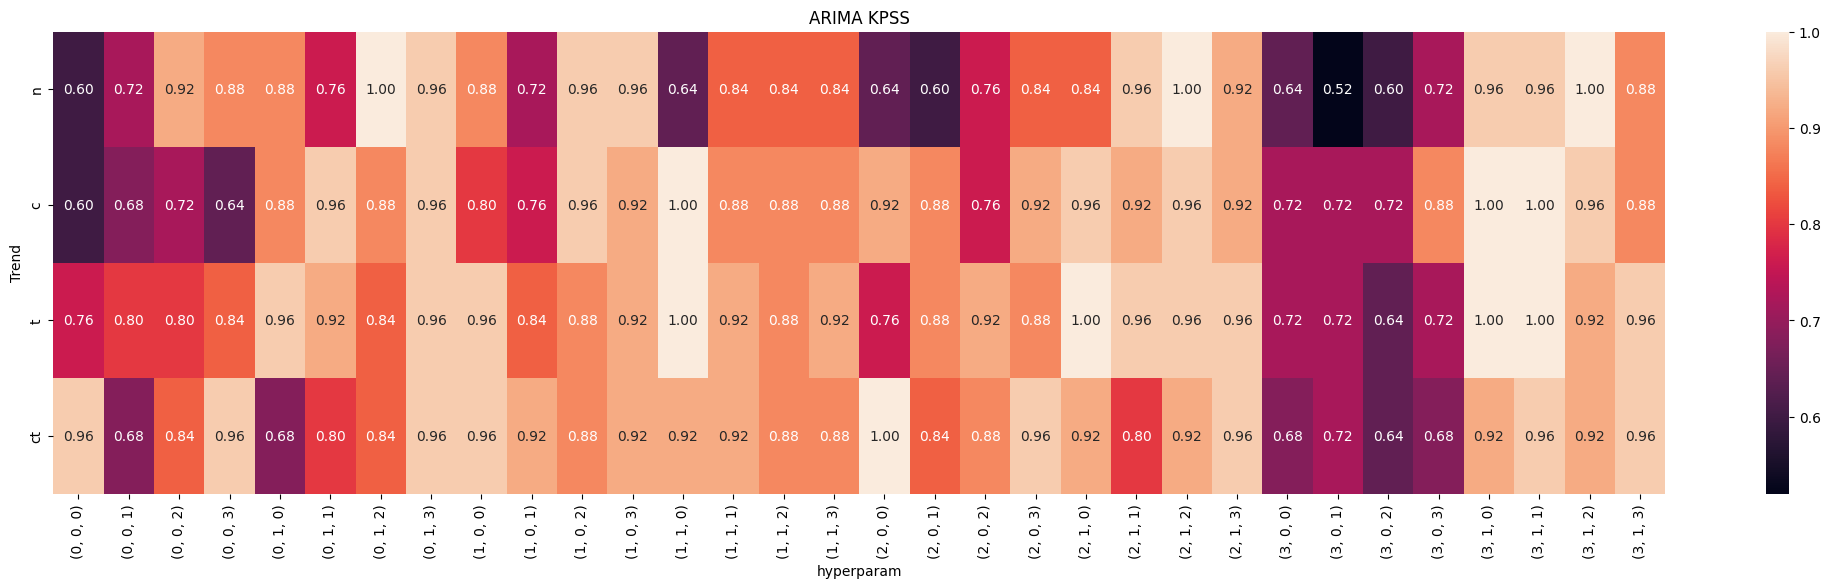

In [84]:
pl.figure(figsize=(26, 6))

data = arima_kpss_mape_df
# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.2f')
pl.title('ARIMA KPSS')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

#### Auto arima

In [39]:
for ts in ts_data:
    model = auto_arima(ts, start_p=0, start_q=0, d=None, max_p=3, max_d=1, max_q=3, stepwise=False, n_jobs=-1, trend='t', with_intercept='auto')
    print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   11
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -63.570
Date:                Tue, 18 Jun 2024   AIC                            133.139
Time:                        16:32:52   BIC                            134.047
Sample:                    01-01-2013   HQIC                           132.144
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          9.2237     13.091      0.705      0.481     -16.434      34.881
ma.L1          0.6229      0.340      1.834      0.067      -0.043       1.288
sigma2      1.866e+04   1.46e+04      1.276      0.2

### Prophet

!Note:

Валидация роста с насыщением, добавить регрессоры, добавить Box-cox, смотреть предсказательные интервалы

16:29:01 - cmdstanpy - INFO - Chain [1] start processing
16:29:02 - cmdstanpy - INFO - Chain [1] done processing
16:29:02 - cmdstanpy - INFO - Chain [1] start processing
16:29:02 - cmdstanpy - INFO - Chain [1] done processing
16:29:02 - cmdstanpy - INFO - Chain [1] start processing
16:29:02 - cmdstanpy - INFO - Chain [1] done processing
16:29:03 - cmdstanpy - INFO - Chain [1] start processing
16:29:03 - cmdstanpy - INFO - Chain [1] done processing
16:29:03 - cmdstanpy - INFO - Chain [1] start processing
16:29:03 - cmdstanpy - INFO - Chain [1] done processing


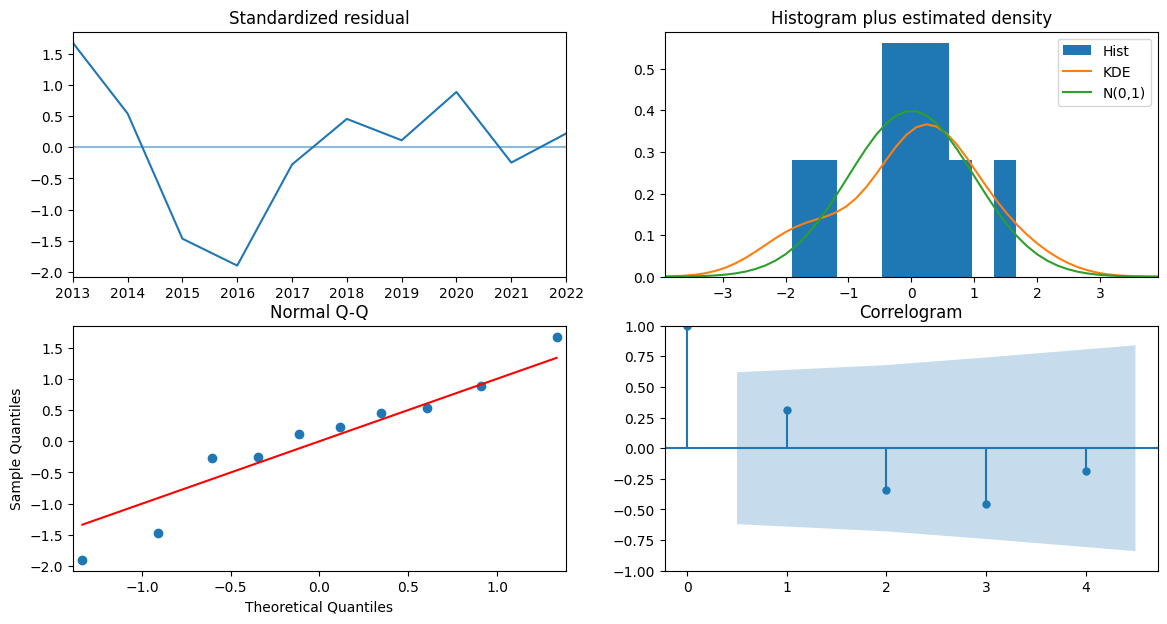

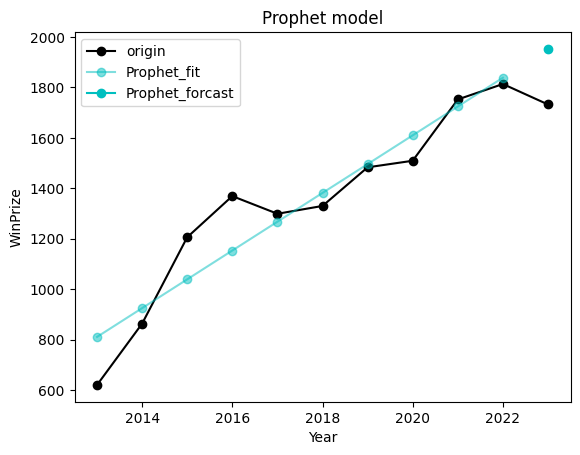

16:29:05 - cmdstanpy - INFO - Chain [1] start processing
16:29:05 - cmdstanpy - INFO - Chain [1] done processing
16:29:05 - cmdstanpy - INFO - Chain [1] start processing
16:29:05 - cmdstanpy - INFO - Chain [1] done processing
16:29:05 - cmdstanpy - INFO - Chain [1] start processing
16:29:05 - cmdstanpy - INFO - Chain [1] done processing
16:29:05 - cmdstanpy - INFO - Chain [1] start processing
16:29:06 - cmdstanpy - INFO - Chain [1] done processing
16:29:06 - cmdstanpy - INFO - Chain [1] start processing
16:29:06 - cmdstanpy - INFO - Chain [1] done processing


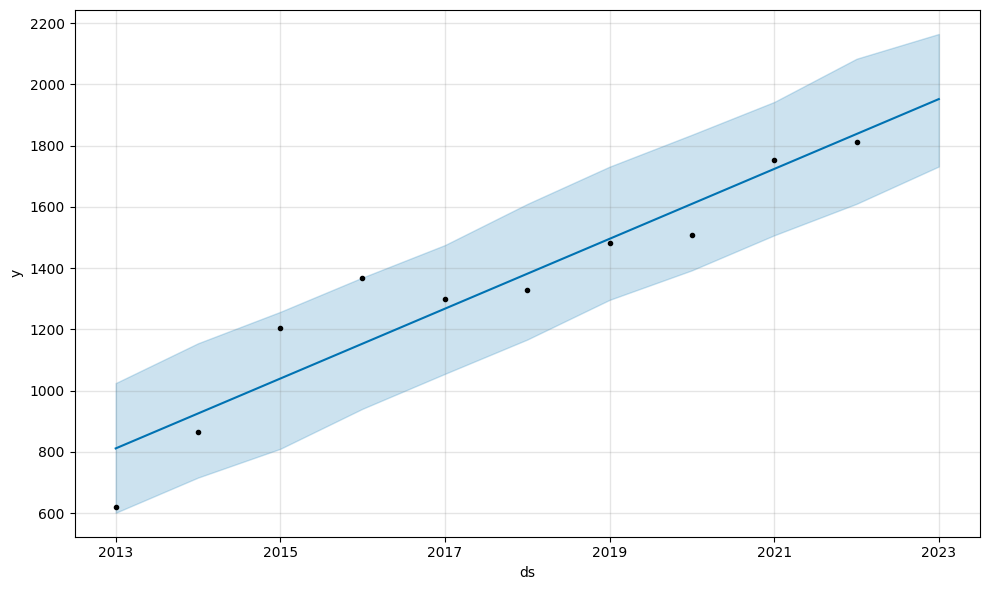

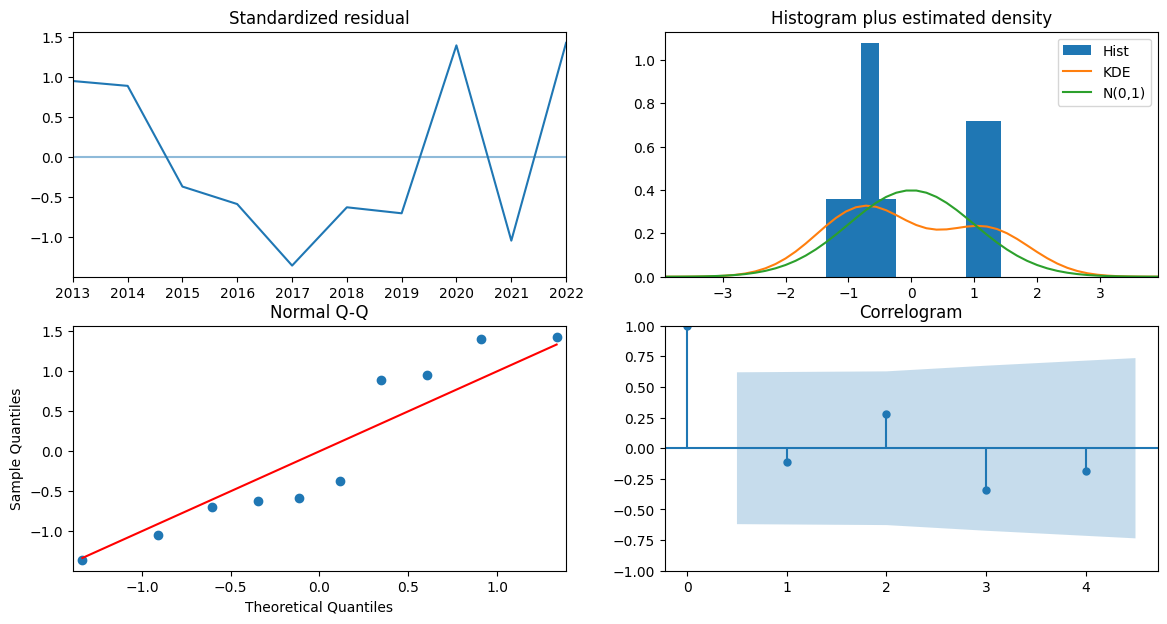

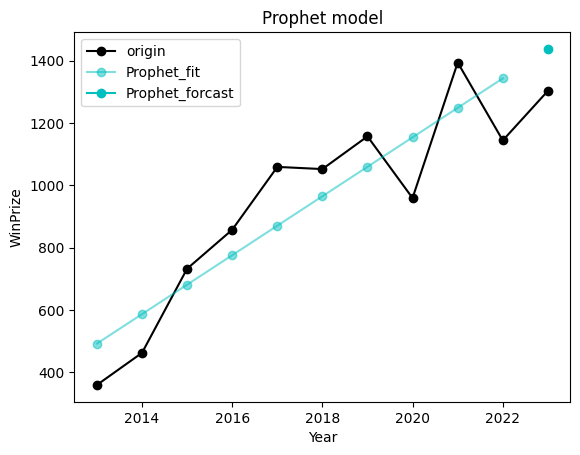

16:29:07 - cmdstanpy - INFO - Chain [1] start processing
16:29:08 - cmdstanpy - INFO - Chain [1] done processing
16:29:08 - cmdstanpy - INFO - Chain [1] start processing
16:29:08 - cmdstanpy - INFO - Chain [1] done processing
16:29:08 - cmdstanpy - INFO - Chain [1] start processing
16:29:08 - cmdstanpy - INFO - Chain [1] done processing
16:29:08 - cmdstanpy - INFO - Chain [1] start processing
16:29:08 - cmdstanpy - INFO - Chain [1] done processing
16:29:08 - cmdstanpy - INFO - Chain [1] start processing
16:29:09 - cmdstanpy - INFO - Chain [1] done processing


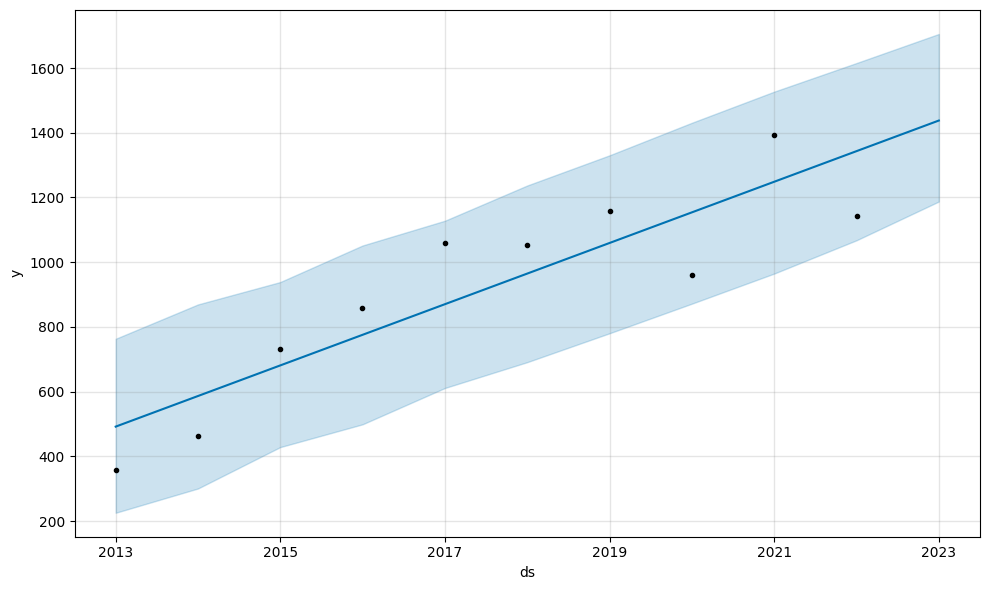

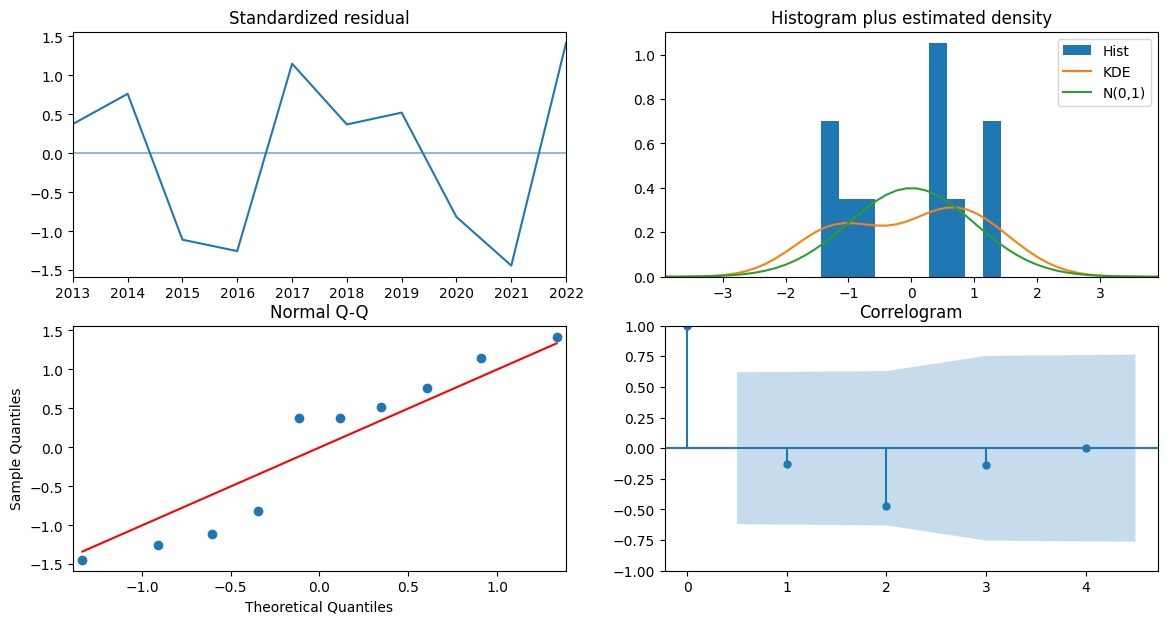

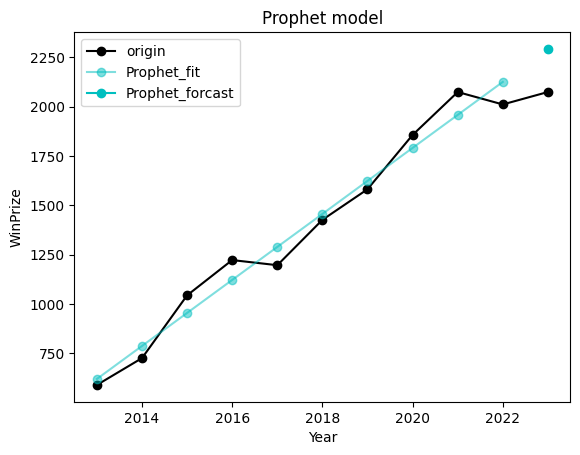

16:29:10 - cmdstanpy - INFO - Chain [1] start processing
16:29:10 - cmdstanpy - INFO - Chain [1] done processing
16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing
16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing
16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing
16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing


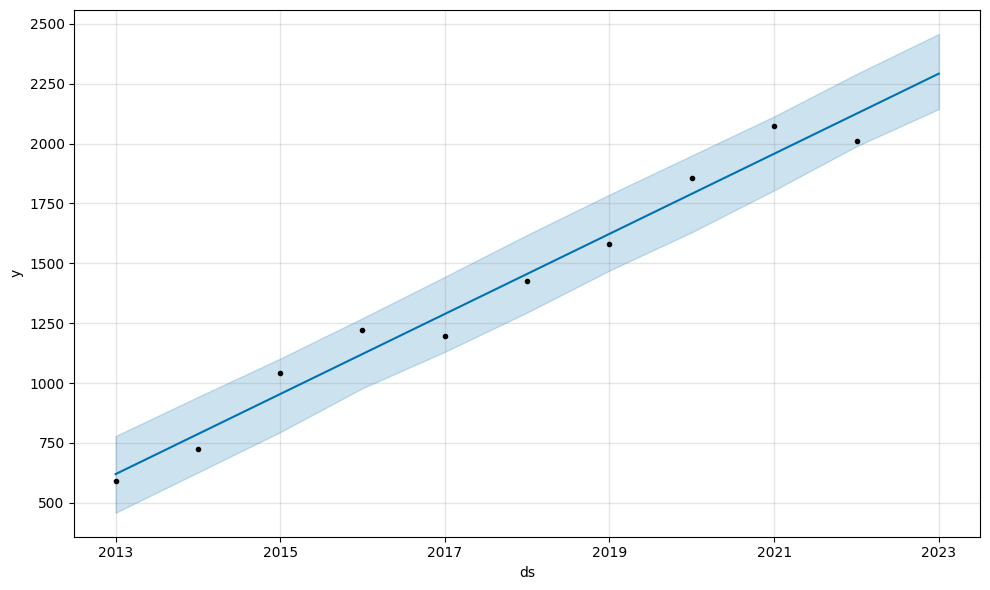

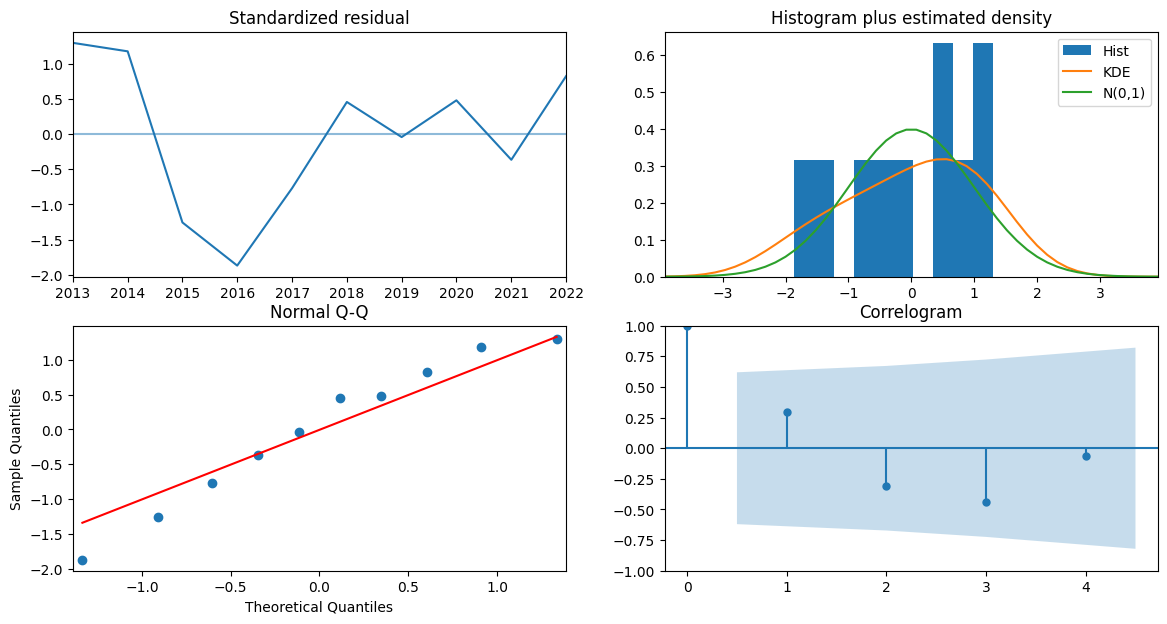

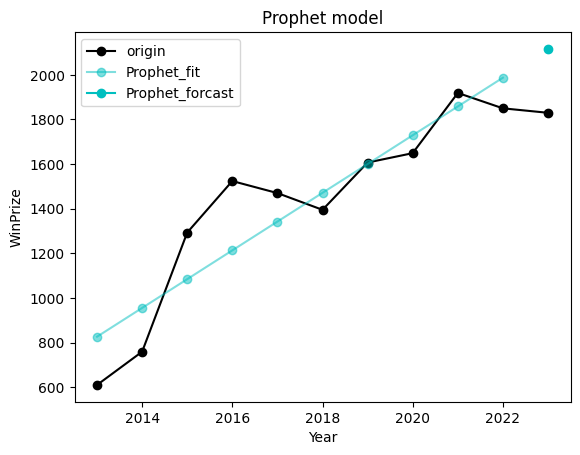

16:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:13 - cmdstanpy - INFO - Chain [1] done processing
16:29:14 - cmdstanpy - INFO - Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processing
16:29:14 - cmdstanpy - INFO - Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processing
16:29:14 - cmdstanpy - INFO - Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processing
16:29:15 - cmdstanpy - INFO - Chain [1] start processing
16:29:15 - cmdstanpy - INFO - Chain [1] done processing


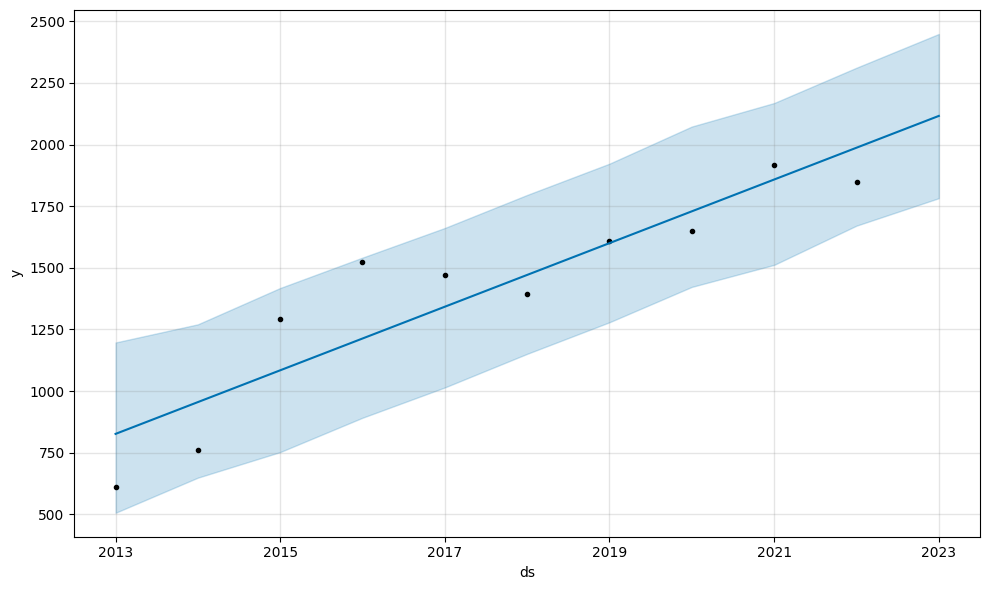

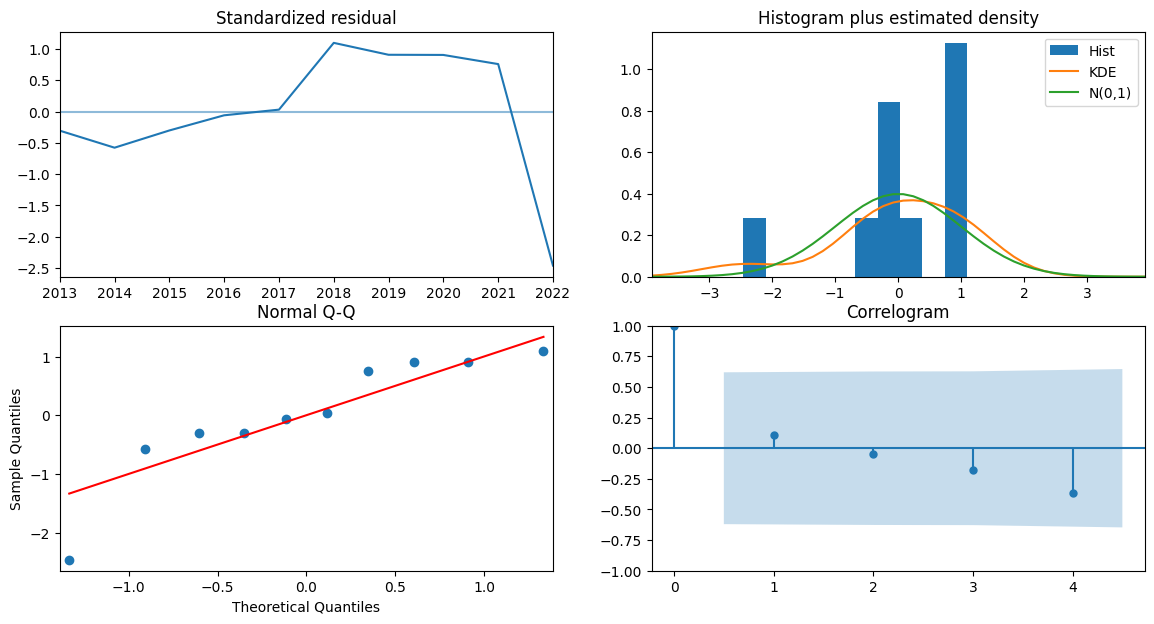

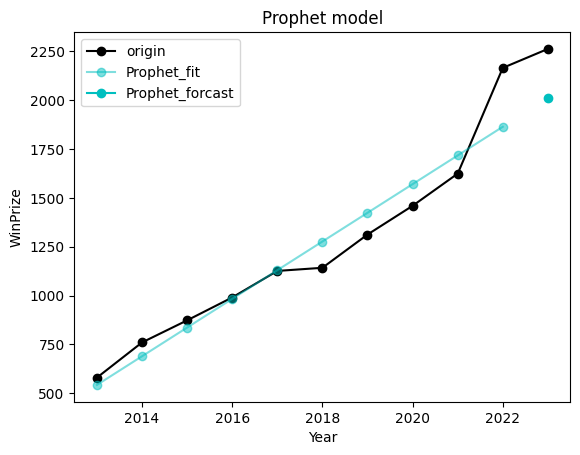

C:\Users\i9629\AppData\Local\Temp\ipykernel_2980\4240319585.py:363: RuntimeWarning: Mean of empty slice.
  return np.median(train_rmse), test_rmse.mean(), _aic.mean(), np.mean(test_mape), test_mae.mean(), test_conf[~np.isnan(test_conf)].mean(),  \
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(119.56211916584178,
 160.26685710694565,
 nan,
 10.27272190606749,
 160.26685710694565,
 23.544035243854452,
 1.0,
 1.0,
 1.0,
 0.48,
 1.0)

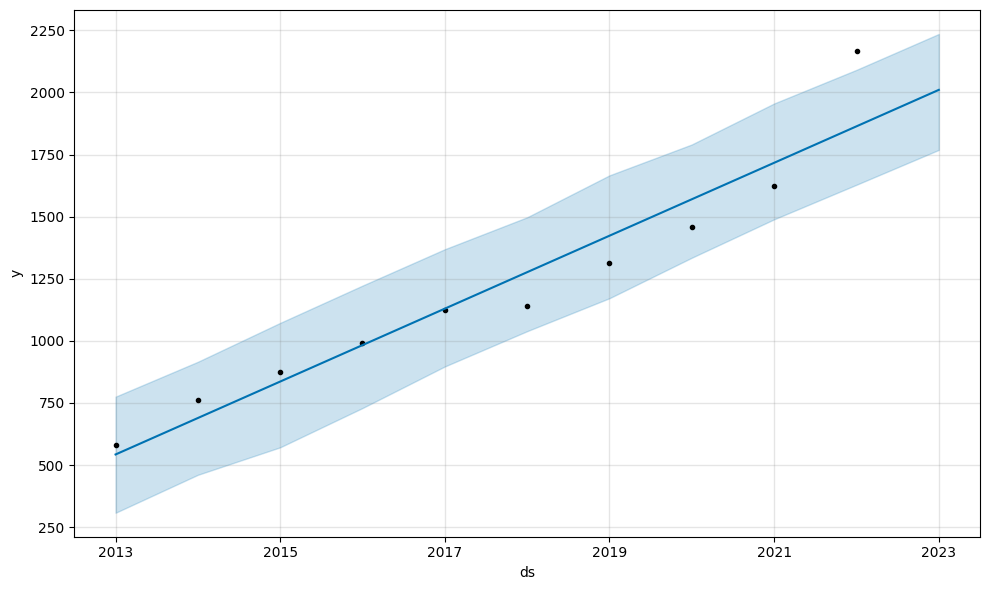

In [178]:
prophet_metrics = validation_metrics(Prophet, prophet_ts_data, min_train_size=6, yearly_seasonality=False, interval_width=0.95)
prophet_metrics

### DeepAR

#### Model test

In [92]:
deepar_df = pd.pivot_table(data=rpo3_grouped, columns='Year', index='Level', values='WinPrize', observed=False, aggfunc='sum')
deepar_df.index = deepar_df.index.values.astype('category').codes
deepar_df.columns = pd.Series(deepar_df.columns.str[-4:]).apply(lambda x: pd.to_datetime(x, format='%Y'))
freq='YE'
train_df = deepar_df.iloc[:, :-1]
test_df =  deepar_df
# deep
test_df.shape

(5, 11)

In [152]:
estimator = DeepAREstimator(freq=freq, 
                           context_length=3,
                           prediction_length=1, 
                           num_feat_static_cat=1,
                           cardinality=[5],
                           num_layers=2,
                           hidden_size=8,
                           lr=1e-1,
                           dropout_rate=0.1,
                           trainer_kwargs={'max_epochs':1}
                           )

In [153]:
train_ds = ListDataset([
    {
        FieldName.TARGET: train_df.loc[level_idx].values,
        FieldName.START: test_df.columns.min(),
        FieldName.FEAT_STATIC_CAT: [level_idx]
    }
    for level_idx in train_df.index
], freq=freq)


test_ds = ListDataset([
    {
        FieldName.TARGET: deepar_df.loc[level_idx].values,
        FieldName.START: test_df.columns.min(),
        FieldName.FEAT_STATIC_CAT: [level_idx]
    }
    for level_idx in test_df.index
], freq=freq)


test_ds

[{'target': array([ 621.,  864., 1206., 1369., 1299., 1330., 1483., 1509., 1752.,
         1813., 1732.], dtype=float32),
  'start': Period('2013', 'Y-DEC'),
  'feat_static_cat': array([0])},
 {'target': array([ 359.,  462.,  732.,  857., 1059., 1052., 1157.,  959., 1394.,
         1144., 1303.], dtype=float32),
  'start': Period('2013', 'Y-DEC'),
  'feat_static_cat': array([1])},
 {'target': array([ 589.,  725., 1043., 1222., 1196., 1426., 1581., 1856., 2074.,
         2011., 2074.], dtype=float32),
  'start': Period('2013', 'Y-DEC'),
  'feat_static_cat': array([2])},
 {'target': array([ 610.,  759., 1293., 1524., 1470., 1395., 1607., 1649., 1919.,
         1850., 1830.], dtype=float32),
  'start': Period('2013', 'Y-DEC'),
  'feat_static_cat': array([3])},
 {'target': array([ 580.,  760.,  873.,  990., 1126., 1142., 1312., 1459., 1624.,
         2165., 2262.], dtype=float32),
  'start': Period('2013', 'Y-DEC'),
  'feat_static_cat': array([4])}]

In [154]:
predictor = estimator.train(train_ds)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.4 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.16047 (best 6.16047), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_196\\checkpoints\\epoch=0-step=50.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


In [155]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,
    num_samples=100
    
)
forecasts = list(forecast_it)
tss = list(ts_it)

In [157]:
[forecasts[i].samples.mean() for i in range(len(forecasts))]

[1885.5381, 1372.0479, 2330.8818, 2058.7021, 2070.7686]

In [49]:
evaluator = Evaluator(quantiles=[0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 5it [00:00, 138.89it/s]


In [50]:
agg_metrics

{'MSE': 72497.78087005616,
 'abs_error': 1063.0283203125,
 'abs_target_sum': 9201.0,
 'abs_target_mean': 1840.2,
 'seasonal_error': 174.4,
 'MASE': 1.2148324408074624,
 'MAPE': 0.12402892298123333,
 'sMAPE': 0.1132147488067858,
 'MSIS': 36.08156357454517,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.9]': 245.26645507812492,
 'Coverage[0.9]': 1.0,
 'RMSE': 269.25411950433767,
 'NRMSE': 0.14631785648534815,
 'ND': 0.11553399851238996,
 'wQuantileLoss[0.9]': 0.02665649984546516,
 'mean_absolute_QuantileLoss': 245.26645507812492,
 'mean_wQuantileLoss': 0.02665649984546516,
 'MAE_Coverage': 0.09999999999999998,
 'OWA': nan}

In [51]:
item_metrics

item_id forecast_start            MSE   abs_error  abs_target_sum  \
0    None           2023   30625.597656  177.107056          1732.0   
1    None           2023   85376.242188  294.347778          1303.0   
2    None           2023  235231.390625  485.845947          2074.0   
3    None           2023   11191.791016  105.331055          1830.0   
4    None           2023      63.882866    0.396484          2262.0   

   abs_target_mean  seasonal_error      MASE      MAPE     sMAPE  \
0           1732.0      148.000000  1.196669  0.102256  0.097282   
1           1303.0      188.333333  1.562909  0.225900  0.202974   
2           2074.0      177.777778  2.732883  0.234256  0.209694   
3           1830.0      181.777778  0.579450  0.057558  0.055948   
4           2262.0      176.111111  0.002251  0.000175  0.000175   

   num_masked_target_values        ND       MSIS  QuantileLoss[0.9]  \
0                       0.0  0.102256  35.449677          38.392627   
1                       0.0  0.225900  40.436695          66.639111   
2                       0.0  0.234256  94.520358         103.575146   
3                       0.0  0.057558   8.557508          26.070752   
4                       0.0  0.000175   1.443580          10.588818   

   Coverage[0.9]  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0

In [75]:
fcast = np.array([forecasts[i].samples.mean() for i in range(len(forecasts))])
origin = np.array([tss[i].iloc[-1, -1] for i in range(len(forecasts))])
print(fcast - origin)
print(origin)

[175.00171  292.19214  485.0066   105.79126   -7.992676]
[1732. 1303. 2074. 1830. 2262.]


In [53]:
# x = []
# x.append([[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]])
# x.append([[1, -1], [2, -2], [3, -3], [4, -4], [5, -5]])
# x.append([[1, -1], [2, -2], [3, -3], [4, -4], [5, -5]])
# x.append([[1, -1], [2, -2], [3, -3], [4, -4], [5, -5]])
# x.append([[90, -1], [2, -2], [3, -3], [4, -4], [5, -5]])
# x.append([[1, -1], [2, -2], [3, -3], [4, -4], [5, -5]])
# y = np.array(x[::-1]).T
# y[0]

#### Model validation

In [179]:
deepar_metrics = validation_metrics(DeepAREstimator, deepar_df, min_train_size=6,
                                   freq=freq, 
                                   context_length=2,
                                   prediction_length=1, 
                                   num_feat_static_cat=1,
                                   cardinality=[5],
                                   num_layers=2,
                                   hidden_size=5,
                                   lr=1e-3,
                                   dropout_rate=0.1,
                                   trainer_kwargs={'max_epochs':10}
                                   )
deepar_metrics

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.52037 (best 7.52037), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3902\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.23963 (best 7.23963), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3902\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.89357 (best 6.89357), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3902\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.62570 (best 6.62570), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3902\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.45690 (best 6.45690), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.04988 (best 8.04988), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3903\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.62084 (best 7.62084), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3903\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.27716 (best 7.27716), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3903\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.94515 (best 6.94515), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3903\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.74232 (best 6.74232), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.71564 (best 8.71564), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3904\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.42207 (best 8.42207), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3904\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.00037 (best 8.00037), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3904\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.64425 (best 7.64425), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3904\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.33286 (best 7.33286), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.36628 (best 8.36628), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3905\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.14174 (best 8.14174), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3905\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.85193 (best 7.85193), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3905\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.48685 (best 7.48685), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3905\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.15663 (best 7.15663), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.90495 (best 7.90495), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3906\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.63887 (best 7.63887), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3906\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.30170 (best 7.30170), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3906\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.94302 (best 6.94302), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_3906\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.72962 (best 6.72962), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

(167.05515350684723,
 170.4818628376307,
 nan,
 9.30589906964451,
 146.3169970703125,
 82.37584217393234,
 1.0,
 1.0,
 1.0,
 0.36,
 1.0)

#### Model search

In [95]:
deepar_test_rmse_df = pd.DataFrame(index=[f'({layer+1}, {size})' for layer in range(2) for size in [5, 10, 20]], 
                                   columns=[f'({cont+1}, {lr}, {epoch})' for cont in range(3) for lr in [1e-1, 1e-2, 1e-3] for epoch in [50, 10]])
deepar_test_mape_df = pd.DataFrame(index=[f'({layer+1}, {size})' for layer in range(2) for size in [5, 10, 20]], 
                                   columns=[f'({cont+1}, {lr}, {epoch})' for cont in range(3) for lr in [1e-1, 1e-2, 1e-3] for epoch in [50, 10]])
deepar_train_rmse_df = pd.DataFrame(index=[f'({layer+1}, {size})' for layer in range(2) for size in [5, 10, 20]], 
                                    columns=[f'({cont+1}, {lr}, {epoch})' for cont in range(3) for lr in [1e-1, 1e-2, 1e-3] for epoch in [50, 10]])
deepar_autocorr_df = pd.DataFrame(index=[f'({layer+1}, {size})' for layer in range(2) for size in [5, 10, 20]], 
                                  columns=[f'({cont+1}, {lr}, {epoch})' for cont in range(3) for lr in [1e-1, 1e-2, 1e-3] for epoch in [50, 10]])
deepar_mean_zero_df = pd.DataFrame(index=[f'({layer+1}, {size})' for layer in range(2) for size in [5, 10, 20]], 
                                   columns=[f'({cont+1}, {lr}, {epoch})' for cont in range(3) for lr in [1e-1, 1e-2, 1e-3] for epoch in [50, 10]])
deepar_norm_df = pd.DataFrame(index=[f'({layer+1}, {size})' for layer in range(2) for size in [5, 10, 20]], 
                              columns=[f'({cont+1}, {lr}, {epoch})' for cont in range(3) for lr in [1e-1, 1e-2, 1e-3] for epoch in [50, 10]])
deepar_kpss_df = pd.DataFrame(index=[f'({layer+1}, {size})' for layer in range(2) for size in [5, 10, 20]], 
                              columns=[f'({cont+1}, {lr}, {epoch})' for cont in range(3) for lr in [1e-1, 1e-2, 1e-3] for epoch in [50, 10]])

i = 0
for cont in range(3):
    cont += 1
    for layer in range(2):
        layer += 1
        for size in [5, 10, 20]:
            for lr in [1e-1, 1e-2, 1e-3]:
                for epoch in [50, 10]:
                    print(i)
                    

                    model_score=validation_metrics(DeepAREstimator, deepar_df, min_train_size=6,
                                                   freq=freq, 
                                                   context_length=cont,
                                                   prediction_length=1, 
                                                   num_feat_static_cat=1,
                                                   cardinality=[5],
                                                   num_layers=layer,
                                                   hidden_size=size,
                                                   lr=lr,
                                                   dropout_rate=0.1,
                                                   trainer_kwargs={'max_epochs': epoch}
                                                   )

                    deepar_test_rmse_df.loc[f'({layer}, {size})', f'({cont}, {lr}, {epoch})'] = model_score[1]
                    deepar_test_mape_df.loc[f'({layer}, {size})', f'({cont}, {lr}, {epoch})'] = model_score[3]
                    deepar_train_rmse_df.loc[f'({layer}, {size})', f'({cont}, {lr}, {epoch})'] = model_score[0]
                    deepar_autocorr_df.loc[f'({layer}, {size})', f'({cont}, {lr}, {epoch})'] = model_score[6]
                    deepar_mean_zero_df.loc[f'({layer}, {size})', f'({cont}, {lr}, {epoch})'] = model_score[7]
                    deepar_norm_df.loc[f'({layer}, {size})', f'({cont}, {lr}, {epoch})'] = model_score[8]
                    deepar_kpss_df.loc[f'({layer}, {size})', f'({cont}, {lr}, {epoch})'] = model_score[10]

                    i += 1


C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


0



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.97434 (best 6.97434), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1100\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.34408 (best 6.34408), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1100\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.99558 (best 5.99558), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1100\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.94344 (best 5.94344), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1100\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.92597 (best 5.92597), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.85386 (best 6.85386), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1101\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.07414 (best 6.07414), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1101\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.80230 (best 5.80230), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1101\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.75094 (best 5.75094), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1101\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.65832 (best 5.65832), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.12412 (best 7.12412), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1102\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.59398 (best 6.59398), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1102\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.52724 (best 6.52724), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1102\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'train_loss' reached 6.46944 (best 6.46944), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\sc

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.17722 (best 7.17722), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1103\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.71439 (best 6.71439), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1103\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.57161 (best 6.57161), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1103\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.52873 (best 6.52873), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1103\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.21470 (best 6.21470), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.35693 (best 7.35693), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1104\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.73212 (best 6.73212), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1104\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.70481 (best 6.70481), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1104\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.69532 (best 6.69532), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1104\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.68726 (best 6.68726), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

1


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.43220 (best 7.43220), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1105\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.33596 (best 6.33596), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1105\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.92572 (best 5.92572), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1105\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.80716 (best 5.80716), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1105\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.20457 (best 7.20457), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1106\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.59104 (best 6.59104), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1106\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.49876 (best 6.49876), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1106\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.39030 (best 6.39030), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1106\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.35823 (best 6.35823), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.01300 (best 7.01300), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1107\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.31079 (best 6.31079), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1107\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.10007 (best 6.10007), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1107\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.88915 (best 5.88915), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1107\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.87044 (best 5.87044), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.13472 (best 7.13472), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1108\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.49043 (best 6.49043), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1108\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.31811 (best 6.31811), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1108\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.29126 (best 6.29126), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1108\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.04182 (best 6.04182), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.14840 (best 7.14840), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1109\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.45245 (best 6.45245), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1109\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.37656 (best 6.37656), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1109\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.21467 (best 6.21467), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1109\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.21030 (best 6.21030), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

2


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.82220 (best 7.82220), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1110\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.72484 (best 6.72484), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1110\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.11833 (best 6.11833), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1110\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.76838 (best 5.76838), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1110\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.48455 (best 5.48455), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.96085 (best 7.96085), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1111\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.85650 (best 6.85650), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1111\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.43564 (best 6.43564), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1111\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.98315 (best 5.98315), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1111\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.81381 (best 5.81381), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.00508 (best 8.00508), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1112\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.79924 (best 6.79924), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1112\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.18915 (best 6.18915), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1112\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.93490 (best 5.93490), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1112\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.74210 (best 5.74210), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.26414 (best 7.26414), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1113\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.71716 (best 6.71716), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1113\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.45055 (best 6.45055), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1113\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.24737 (best 6.24737), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1113\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.98326 (best 5.98326), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.89297 (best 7.89297), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1114\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.88481 (best 6.88481), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1114\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.66235 (best 6.66235), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1114\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.41819 (best 6.41819), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1114\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.19391 (best 6.19391), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

3


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.86503 (best 7.86503), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1115\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.78431 (best 6.78431), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1115\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.24216 (best 6.24216), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1115\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.89428 (best 5.89428), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1115\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.73444 (best 5.73444), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.55436 (best 7.55436), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1116\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.81076 (best 6.81076), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1116\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.37682 (best 6.37682), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1116\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.00133 (best 6.00133), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1116\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.76363 (best 5.76363), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.20730 (best 7.20730), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1117\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.55931 (best 6.55931), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1117\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.13694 (best 6.13694), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1117\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.90393 (best 5.90393), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1117\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.69678 (best 5.69678), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.72150 (best 7.72150), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1118\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.81451 (best 6.81451), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1118\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.46850 (best 6.46850), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1118\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.26996 (best 6.26996), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1118\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.12223 (best 6.12223), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.88765 (best 7.88765), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1119\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.86810 (best 6.86810), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1119\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.62848 (best 6.62848), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1119\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.41397 (best 6.41397), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1119\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.26952 (best 6.26952), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

4


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.72677 (best 8.72677), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1120\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.35068 (best 8.35068), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1120\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.03274 (best 8.03274), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1120\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.72301 (best 7.72301), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1120\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.38898 (best 7.38898), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.22762 (best 8.22762), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1121\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.00633 (best 8.00633), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1121\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.75242 (best 7.75242), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1121\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.39609 (best 7.39609), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1121\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.16487 (best 7.16487), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.67520 (best 8.67520), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1122\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.08500 (best 8.08500), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1122\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.66848 (best 7.66848), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1122\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.41381 (best 7.41381), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1122\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.24075 (best 7.24075), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.61838 (best 8.61838), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1123\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.34330 (best 8.34330), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1123\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.89515 (best 7.89515), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1123\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.47882 (best 7.47882), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1123\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.27439 (best 7.27439), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.85760 (best 8.85760), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1124\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.59170 (best 8.59170), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1124\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.32081 (best 8.32081), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1124\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.99200 (best 7.99200), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1124\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.71085 (best 7.71085), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

5


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.11242 (best 8.11242), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1125\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.56943 (best 7.56943), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1125\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.23718 (best 7.23718), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1125\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.07163 (best 7.07163), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1125\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.02299 (best 7.02299), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.45652 (best 8.45652), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1126\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.15022 (best 8.15022), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1126\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.77165 (best 7.77165), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1126\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.20329 (best 7.20329), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1126\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.00065 (best 7.00065), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.63552 (best 8.63552), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1127\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.38066 (best 8.38066), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1127\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.08349 (best 8.08349), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1127\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.74904 (best 7.74904), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1127\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.37834 (best 7.37834), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.91791 (best 7.91791), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1128\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.62628 (best 7.62628), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1128\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.36354 (best 7.36354), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1128\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.13504 (best 7.13504), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1128\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.98590 (best 6.98590), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.80477 (best 8.80477), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1129\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.24917 (best 8.24917), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1129\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.77801 (best 7.77801), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1129\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.55300 (best 7.55300), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1129\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.40341 (best 7.40341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

6


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.81403 (best 6.81403), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1130\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.03304 (best 6.03304), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1130\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.63496 (best 5.63496), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1130\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.61374 (best 5.61374), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1130\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.54015 (best 5.54015), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.76972 (best 6.76972), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1131\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.11295 (best 6.11295), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1131\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.95519 (best 5.95519), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1131\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.77991 (best 5.77991), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1131\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.63181 (best 5.63181), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.88693 (best 6.88693), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1132\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.22277 (best 6.22277), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1132\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.91825 (best 5.91825), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1132\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.83942 (best 5.83942), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1132\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.75634 (best 5.75634), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.80698 (best 6.80698), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1133\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.20169 (best 6.20169), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1133\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.19514 (best 6.19514), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1133\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.97715 (best 5.97715), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1133\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.97046 (best 5.97046), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.06371 (best 7.06371), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1134\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.32899 (best 6.32899), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1134\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.28683 (best 6.28683), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1134\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 6.05392 (best 6.05392), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1134\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

7


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.02135 (best 7.02135), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1135\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.68531 (best 6.68531), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1135\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.58972 (best 6.58972), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1135\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.57867 (best 6.57867), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1135\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.51948 (best 6.51948), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.01865 (best 7.01865), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1136\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.53061 (best 6.53061), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1136\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.39542 (best 6.39542), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1136\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.36033 (best 6.36033), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1136\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.03077 (best 6.03077), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.82007 (best 6.82007), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1137\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.26561 (best 6.26561), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1137\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.14349 (best 6.14349), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1137\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.87557 (best 5.87557), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1137\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.70425 (best 5.70425), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.82415 (best 6.82415), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1138\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.30840 (best 6.30840), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1138\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.05928 (best 6.05928), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1138\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.96999 (best 5.96999), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1138\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.81922 (best 5.81922), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.05749 (best 7.05749), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1139\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.76044 (best 6.76044), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1139\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.51522 (best 6.51522), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1139\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.34538 (best 6.34538), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1139\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.29588 (best 6.29588), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

8


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.23012 (best 7.23012), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1140\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.42236 (best 6.42236), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1140\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.91368 (best 5.91368), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1140\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.70137 (best 5.70137), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1140\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.50863 (best 5.50863), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.37593 (best 7.37593), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1141\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.48012 (best 6.48012), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1141\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.93766 (best 5.93766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1141\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.73737 (best 5.73737), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1141\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.53686 (best 5.53686), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.22238 (best 7.22238), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1142\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.29882 (best 6.29882), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1142\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.76536 (best 5.76536), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1142\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.52820 (best 5.52820), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1142\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.42256 (best 5.42256), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.43722 (best 7.43722), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1143\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.59781 (best 6.59781), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1143\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.35445 (best 6.35445), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1143\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.08134 (best 6.08134), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1143\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.93831 (best 5.93831), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.54746 (best 7.54746), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1144\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.66974 (best 6.66974), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1144\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.38572 (best 6.38572), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1144\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.16352 (best 6.16352), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1144\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.03286 (best 6.03286), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

9



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.52803 (best 7.52803), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1145\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.54347 (best 6.54347), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1145\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.04554 (best 6.04554), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1145\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.58902 (best 5.58902), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1145\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.16149 (best 5.16149), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.46237 (best 7.46237), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1146\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.41347 (best 6.41347), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1146\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.96650 (best 5.96650), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1146\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.76898 (best 5.76898), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1146\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.63945 (best 5.63945), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.69554 (best 7.69554), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1147\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.69302 (best 6.69302), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1147\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.46912 (best 6.46912), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1147\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.26376 (best 6.26376), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1147\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.87354 (best 5.87354), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.71438 (best 7.71438), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1148\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.59397 (best 6.59397), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1148\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.15761 (best 6.15761), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1148\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.94336 (best 5.94336), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1148\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.81570 (best 5.81570), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.71839 (best 7.71839), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1149\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.77465 (best 6.77465), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1149\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.47575 (best 6.47575), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1149\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.20732 (best 6.20732), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1149\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.01366 (best 6.01366), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

10



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.58043 (best 8.58043), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1150\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.25083 (best 8.25083), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1150\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.83295 (best 7.83295), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1150\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.45182 (best 7.45182), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1150\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.18431 (best 7.18431), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.40613 (best 8.40613), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1151\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.80092 (best 7.80092), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1151\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.44291 (best 7.44291), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1151\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.14308 (best 7.14308), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1151\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.93049 (best 6.93049), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.10613 (best 8.10613), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1152\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.56186 (best 7.56186), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1152\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.22636 (best 7.22636), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1152\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.99385 (best 6.99385), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1152\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.84038 (best 6.84038), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.76198 (best 8.76198), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1153\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.43037 (best 8.43037), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1153\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.98335 (best 7.98335), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1153\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.54815 (best 7.54815), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1153\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.20806 (best 7.20806), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.44240 (best 8.44240), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1154\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.92356 (best 7.92356), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1154\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.47907 (best 7.47907), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1154\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.11460 (best 7.11460), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1154\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.95294 (best 6.95294), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

11



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.38064 (best 8.38064), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1155\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.93296 (best 7.93296), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1155\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.42539 (best 7.42539), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1155\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.09721 (best 7.09721), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1155\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.91333 (best 6.91333), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.34887 (best 8.34887), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1156\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.89673 (best 7.89673), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1156\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.38899 (best 7.38899), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1156\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.06600 (best 7.06600), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1156\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.80754 (best 6.80754), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.94848 (best 8.94848), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1157\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.40744 (best 8.40744), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1157\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.97638 (best 7.97638), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1157\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.55039 (best 7.55039), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1157\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.16699 (best 7.16699), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.82022 (best 8.82022), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1158\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.34887 (best 8.34887), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1158\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.85957 (best 7.85957), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1158\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.38674 (best 7.38674), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1158\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.11368 (best 7.11368), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.23068 (best 8.23068), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1159\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.81510 (best 7.81510), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1159\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.47845 (best 7.47845), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1159\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.12099 (best 7.12099), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1159\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.84853 (best 6.84853), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

12


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.64803 (best 6.64803), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1160\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.02065 (best 6.02065), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1160\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.86081 (best 5.86081), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1160\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.66650 (best 5.66650), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1160\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.37487 (best 5.37487), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.88256 (best 6.88256), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1161\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.14099 (best 6.14099), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1161\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.11242 (best 6.11242), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1161\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.99589 (best 5.99589), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1161\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.91999 (best 5.91999), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.80574 (best 6.80574), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1162\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.18725 (best 6.18725), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1162\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.01060 (best 6.01060), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1162\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.82303 (best 5.82303), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1162\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.91982 (best 6.91982), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1163\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.43750 (best 6.43750), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1163\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.27949 (best 6.27949), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1163\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.07079 (best 6.07079), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1163\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.03130 (best 6.03130), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.04356 (best 7.04356), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1164\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.63497 (best 6.63497), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1164\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.34314 (best 6.34314), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1164\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.28371 (best 6.28371), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1164\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.17648 (best 6.17648), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

13


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.83620 (best 6.83620), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1165\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.10122 (best 6.10122), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1165\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.08622 (best 6.08622), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1165\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.83159 (best 5.83159), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1165\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.67179 (best 5.67179), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.87451 (best 6.87451), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1166\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.08003 (best 6.08003), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1166\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.79325 (best 5.79325), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1166\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.76833 (best 5.76833), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1166\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.96753 (best 6.96753), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1167\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.18291 (best 6.18291), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1167\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 5.94757 (best 5.94757), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1167\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.78674 (best 5.78674), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1167\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.96324 (best 6.96324), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1168\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.40283 (best 6.40283), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1168\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.40001 (best 6.40001), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1168\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 6.10268 (best 6.10268), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1168\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.15993 (best 7.15993), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1169\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.46564 (best 6.46564), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1169\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.39642 (best 6.39642), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1169\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.17755 (best 6.17755), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1169\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.08673 (best 6.08673), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

14


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.19304 (best 7.19304), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1170\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.28463 (best 6.28463), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1170\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.83799 (best 5.83799), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1170\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.43592 (best 5.43592), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1170\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.36535 (best 5.36535), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.15597 (best 7.15597), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1171\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.35092 (best 6.35092), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1171\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.84099 (best 5.84099), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1171\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.48005 (best 5.48005), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1171\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.23009 (best 5.23009), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.27420 (best 7.27420), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1172\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.36936 (best 6.36936), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1172\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.20674 (best 6.20674), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1172\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.82138 (best 5.82138), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1172\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.66018 (best 5.66018), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.28592 (best 7.28592), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1173\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.44845 (best 6.44845), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1173\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.15791 (best 6.15791), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1173\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.87639 (best 5.87639), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1173\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.74404 (best 5.74404), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.41127 (best 7.41127), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1174\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.63551 (best 6.63551), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1174\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.34835 (best 6.34835), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1174\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.04335 (best 6.04335), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1174\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.78688 (best 5.78688), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

15


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.32015 (best 7.32015), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1175\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.30844 (best 6.30844), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1175\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.96738 (best 5.96738), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1175\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.77802 (best 5.77802), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1175\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.69158 (best 5.69158), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.52774 (best 7.52774), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1176\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.49160 (best 6.49160), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1176\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.97127 (best 5.97127), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1176\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.72165 (best 5.72165), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1176\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.46630 (best 5.46630), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.37173 (best 7.37173), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1177\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.51757 (best 6.51757), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1177\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.12452 (best 6.12452), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1177\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.82050 (best 5.82050), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1177\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.51338 (best 5.51338), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.23636 (best 7.23636), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1178\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.44179 (best 6.44179), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1178\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.13814 (best 6.13814), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1178\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.98192 (best 5.98192), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1178\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.73203 (best 5.73203), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.25364 (best 7.25364), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1179\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.63262 (best 6.63262), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1179\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.29773 (best 6.29773), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1179\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.10850 (best 6.10850), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1179\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.09561 (best 6.09561), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

16


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.23241 (best 8.23241), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1180\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.56242 (best 7.56242), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1180\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.99316 (best 6.99316), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1180\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.80595 (best 6.80595), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1180\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.57925 (best 6.57925), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.27789 (best 8.27789), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1181\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.53602 (best 7.53602), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1181\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.99927 (best 6.99927), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1181\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.76668 (best 6.76668), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1181\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.52415 (best 6.52415), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.41604 (best 8.41604), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1182\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.79462 (best 7.79462), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1182\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.14585 (best 7.14585), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1182\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.82678 (best 6.82678), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1182\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.67264 (best 6.67264), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.20118 (best 8.20118), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1183\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.41249 (best 7.41249), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1183\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.97212 (best 6.97212), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1183\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.78818 (best 6.78818), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1183\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.66652 (best 6.66652), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.56614 (best 8.56614), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1184\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.87424 (best 7.87424), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1184\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.27442 (best 7.27442), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1184\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.93061 (best 6.93061), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1184\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.80145 (best 6.80145), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

17



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.49243 (best 8.49243), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1185\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.92128 (best 7.92128), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1185\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.23149 (best 7.23149), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1185\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.84339 (best 6.84339), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1185\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.60552 (best 6.60552), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.64295 (best 8.64295), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1186\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.82992 (best 7.82992), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1186\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.22966 (best 7.22966), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1186\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.94785 (best 6.94785), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1186\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.77331 (best 6.77331), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.23387 (best 8.23387), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1187\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.54648 (best 7.54648), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1187\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.11298 (best 7.11298), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1187\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.85423 (best 6.85423), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1187\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.66940 (best 6.66940), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.62382 (best 8.62382), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1188\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.74665 (best 7.74665), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1188\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.33188 (best 7.33188), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1188\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.00454 (best 7.00454), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1188\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.81016 (best 6.81016), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.69422 (best 8.69422), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1189\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.02252 (best 8.02252), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1189\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.44794 (best 7.44794), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1189\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.08062 (best 7.08062), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1189\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.88446 (best 6.88446), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

18



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.08197 (best 7.08197), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1190\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.65125 (best 6.65125), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1190\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.59455 (best 6.59455), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1190\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.31983 (best 6.31983), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1190\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.11849 (best 6.11849), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.32834 (best 7.32834), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1191\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.99686 (best 6.99686), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1191\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 6.93751 (best 6.93751), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1191\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.92807 (best 6.92807), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1191\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.08358 (best 7.08358), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1192\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.61119 (best 6.61119), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1192\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.44018 (best 6.44018), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1192\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.25122 (best 6.25122), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1192\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.15775 (best 6.15775), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.25149 (best 7.25149), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1193\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.86475 (best 6.86475), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1193\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.64830 (best 6.64830), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1193\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.54245 (best 6.54245), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1193\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.50784 (best 6.50784), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.25539 (best 7.25539), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1194\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.09537 (best 7.09537), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1194\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.03513 (best 7.03513), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1194\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.90960 (best 6.90960), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1194\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.69708 (best 6.69708), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

19



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.21155 (best 7.21155), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1195\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.97483 (best 6.97483), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1195\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.65770 (best 6.65770), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1195\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.53994 (best 6.53994), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1195\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.40909 (best 6.40909), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.95472 (best 6.95472), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1196\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.53242 (best 6.53242), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1196\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.29637 (best 6.29637), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1196\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.21665 (best 6.21665), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1196\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.19753 (best 7.19753), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1197\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.54653 (best 6.54653), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1197\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.34278 (best 6.34278), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1197\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.31374 (best 6.31374), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1197\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.27160 (best 6.27160), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.29850 (best 7.29850), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1198\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.96126 (best 6.96126), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1198\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'train_loss' was not in top 1
Epoch 8, global step 450: 'train_loss' was not in top 1
Epoch 9, global step 500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
Running evaluation: 5it [00:00, 128.33it/s]
Running evaluation: 5it [0

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.17471 (best 7.17471), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1199\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.82995 (best 6.82995), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1199\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.73456 (best 6.73456), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1199\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.67602 (best 6.67602), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1199\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

20


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.38844 (best 7.38844), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1200\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.76309 (best 6.76309), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1200\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.33481 (best 6.33481), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1200\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.13949 (best 6.13949), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1200\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.97867 (best 5.97867), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.56532 (best 7.56532), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1201\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.70808 (best 6.70808), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1201\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.07505 (best 6.07505), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1201\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.86131 (best 5.86131), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1201\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.69129 (best 5.69129), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.90503 (best 7.90503), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1202\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.84033 (best 6.84033), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1202\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.53352 (best 6.53352), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1202\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.37600 (best 6.37600), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1202\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.27820 (best 6.27820), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.71591 (best 7.71591), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1203\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.86659 (best 6.86659), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1203\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.64724 (best 6.64724), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1203\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.62154 (best 6.62154), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1203\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.45353 (best 6.45353), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.70956 (best 7.70956), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1204\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.03481 (best 7.03481), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1204\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.81412 (best 6.81412), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1204\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.59852 (best 6.59852), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1204\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.34872 (best 6.34872), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

21


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.99199 (best 7.99199), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1205\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.86392 (best 6.86392), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1205\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.49879 (best 6.49879), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1205\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.24122 (best 6.24122), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1205\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.08701 (best 6.08701), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.28271 (best 8.28271), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1206\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.98901 (best 6.98901), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1206\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.51583 (best 6.51583), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1206\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.23255 (best 6.23255), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1206\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.05724 (best 6.05724), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.10531 (best 8.10531), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1207\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.99249 (best 6.99249), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1207\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.65412 (best 6.65412), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1207\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.39187 (best 6.39187), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1207\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.19807 (best 6.19807), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.14936 (best 8.14936), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1208\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.05293 (best 7.05293), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1208\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.84943 (best 6.84943), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1208\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.56132 (best 6.56132), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1208\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.38364 (best 6.38364), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.93652 (best 7.93652), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1209\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.03630 (best 7.03630), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1209\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.74561 (best 6.74561), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1209\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.55872 (best 6.55872), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1209\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.46136 (best 6.46136), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

22



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.36096 (best 8.36096), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1210\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.10608 (best 8.10608), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1210\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.81512 (best 7.81512), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1210\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.53203 (best 7.53203), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1210\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.29037 (best 7.29037), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.81905 (best 9.81905), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1211\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.50892 (best 9.50892), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1211\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 9.15659 (best 9.15659), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1211\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.80290 (best 8.80290), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1211\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.49829 (best 8.49829), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.47468 (best 8.47468), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1212\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.22777 (best 8.22777), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1212\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.98591 (best 7.98591), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1212\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.70321 (best 7.70321), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1212\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.48393 (best 7.48393), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.17299 (best 9.17299), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1213\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.00225 (best 9.00225), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1213\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.75184 (best 8.75184), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1213\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.40971 (best 8.40971), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1213\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.08854 (best 8.08854), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.02942 (best 9.02942), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1214\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.61734 (best 8.61734), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1214\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.15446 (best 8.15446), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1214\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.78764 (best 7.78764), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1214\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.52148 (best 7.52148), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

23


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.31304 (best 9.31304), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1215\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.99601 (best 8.99601), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1215\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.62720 (best 8.62720), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1215\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.23335 (best 8.23335), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1215\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.94843 (best 7.94843), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.68268 (best 8.68268), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1216\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.37161 (best 8.37161), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1216\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.01567 (best 8.01567), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1216\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.70076 (best 7.70076), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1216\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.48252 (best 7.48252), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.00495 (best 9.00495), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1217\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.71325 (best 8.71325), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1217\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.35394 (best 8.35394), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1217\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.95722 (best 7.95722), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1217\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.63532 (best 7.63532), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.06443 (best 9.06443), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1218\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.68619 (best 8.68619), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1218\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.28340 (best 8.28340), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1218\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.90789 (best 7.90789), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1218\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.58826 (best 7.58826), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.26729 (best 9.26729), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1219\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.94316 (best 8.94316), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1219\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.62341 (best 8.62341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1219\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.39349 (best 8.39349), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1219\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.17522 (best 8.17522), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

24



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.04341 (best 7.04341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1220\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.51014 (best 6.51014), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1220\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.28823 (best 6.28823), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1220\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.12979 (best 6.12979), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1220\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.12860 (best 6.12860), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.90340 (best 6.90340), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1221\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.39203 (best 6.39203), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1221\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.12951 (best 6.12951), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1221\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.98645 (best 5.98645), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1221\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.84734 (best 5.84734), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.09149 (best 7.09149), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1222\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.46829 (best 6.46829), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1222\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.17586 (best 6.17586), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1222\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.07682 (best 6.07682), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1222\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.03313 (best 6.03313), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.12369 (best 7.12369), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1223\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.79795 (best 6.79795), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1223\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.60958 (best 6.60958), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1223\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.50855 (best 6.50855), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1223\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.41470 (best 6.41470), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.99328 (best 6.99328), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1224\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.57651 (best 6.57651), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1224\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.37846 (best 6.37846), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1224\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.34673 (best 6.34673), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1224\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.21023 (best 6.21023), sav

25


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.01406 (best 7.01406), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1225\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.36390 (best 6.36390), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1225\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.13193 (best 6.13193), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1225\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.10784 (best 6.10784), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1225\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.85440 (best 5.85440), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.88818 (best 6.88818), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1226\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.35416 (best 6.35416), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1226\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.09276 (best 6.09276), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1226\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.96428 (best 5.96428), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1226\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.80943 (best 5.80943), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.18644 (best 7.18644), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1227\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.61551 (best 6.61551), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1227\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.48516 (best 6.48516), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1227\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.34279 (best 6.34279), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1227\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.33598 (best 6.33598), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.13676 (best 7.13676), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1228\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.54631 (best 6.54631), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1228\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.28221 (best 6.28221), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1228\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.27886 (best 6.27886), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1228\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.23135 (best 6.23135), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.24492 (best 7.24492), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1229\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.72608 (best 6.72608), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1229\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.48175 (best 6.48175), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1229\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.44634 (best 6.44634), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1229\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.44592 (best 6.44592), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

26


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.45802 (best 7.45802), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1230\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.76393 (best 6.76393), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1230\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.33494 (best 6.33494), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1230\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.81988 (best 5.81988), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1230\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.63674 (best 5.63674), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.41052 (best 7.41052), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1231\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.68879 (best 6.68879), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1231\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.22921 (best 6.22921), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1231\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.97995 (best 5.97995), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1231\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.84635 (best 5.84635), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.78348 (best 7.78348), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1232\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.64490 (best 6.64490), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1232\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.14658 (best 6.14658), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1232\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.08261 (best 6.08261), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1232\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.86204 (best 5.86204), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.55723 (best 7.55723), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1233\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.72853 (best 6.72853), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1233\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.30587 (best 6.30587), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1233\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.05664 (best 6.05664), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1233\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.94660 (best 5.94660), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.51112 (best 7.51112), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1234\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.92144 (best 6.92144), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1234\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.68746 (best 6.68746), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1234\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.52739 (best 6.52739), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1234\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.30294 (best 6.30294), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

27


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.41312 (best 7.41312), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1235\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.61605 (best 6.61605), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1235\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.26035 (best 6.26035), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1235\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.04702 (best 6.04702), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1235\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.88965 (best 5.88965), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.71364 (best 7.71364), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1236\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.62766 (best 6.62766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1236\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.10285 (best 6.10285), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1236\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.91873 (best 5.91873), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1236\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.87098 (best 5.87098), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.55676 (best 7.55676), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1237\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.64869 (best 6.64869), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1237\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.18081 (best 6.18081), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1237\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.06584 (best 6.06584), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1237\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.87500 (best 5.87500), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.37586 (best 7.37586), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1238\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.70366 (best 6.70366), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1238\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.30286 (best 6.30286), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1238\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.14295 (best 6.14295), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1238\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.94293 (best 5.94293), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.05299 (best 8.05299), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1239\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.99052 (best 6.99052), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1239\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.55367 (best 6.55367), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1239\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.40158 (best 6.40158), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1239\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.23928 (best 6.23928), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

28



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.29829 (best 8.29829), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1240\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.86007 (best 7.86007), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1240\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.41423 (best 7.41423), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1240\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.14256 (best 7.14256), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1240\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.95736 (best 6.95736), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.08320 (best 9.08320), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1241\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.54193 (best 8.54193), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1241\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.79389 (best 7.79389), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1241\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.34953 (best 7.34953), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1241\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.10878 (best 7.10878), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.72056 (best 8.72056), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1242\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.16923 (best 8.16923), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1242\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.51791 (best 7.51791), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1242\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.18286 (best 7.18286), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1242\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.98600 (best 6.98600), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.40521 (best 8.40521), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1243\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.02765 (best 8.02765), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1243\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.43974 (best 7.43974), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1243\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.10169 (best 7.10169), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1243\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.99374 (best 6.99374), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.65629 (best 8.65629), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1244\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.42228 (best 8.42228), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1244\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.95018 (best 7.95018), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1244\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.47114 (best 7.47114), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1244\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.19350 (best 7.19350), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

29



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.81285 (best 8.81285), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1245\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.25161 (best 8.25161), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1245\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.59515 (best 7.59515), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1245\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.18107 (best 7.18107), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1245\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.98254 (best 6.98254), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.90132 (best 8.90132), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1246\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.52110 (best 8.52110), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1246\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.06232 (best 8.06232), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1246\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.62796 (best 7.62796), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1246\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.29395 (best 7.29395), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.01881 (best 9.01881), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1247\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.32135 (best 8.32135), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1247\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.72494 (best 7.72494), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1247\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.43565 (best 7.43565), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1247\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.24325 (best 7.24325), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.40664 (best 8.40664), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1248\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.93781 (best 7.93781), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1248\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.47202 (best 7.47202), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1248\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.22016 (best 7.22016), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1248\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.09087 (best 7.09087), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.79135 (best 8.79135), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1249\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.20448 (best 8.20448), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1249\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.51849 (best 7.51849), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1249\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.21181 (best 7.21181), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1249\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.06604 (best 7.06604), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

30


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.87617 (best 6.87617), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1250\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.18805 (best 6.18805), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1250\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.95218 (best 5.95218), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1250\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.79511 (best 5.79511), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1250\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.00181 (best 7.00181), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1251\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.37516 (best 6.37516), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1251\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.11494 (best 6.11494), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1251\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.92858 (best 5.92858), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1251\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.88242 (best 5.88242), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.89822 (best 6.89822), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1252\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.27652 (best 6.27652), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1252\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.19976 (best 6.19976), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1252\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.05342 (best 6.05342), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1252\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.99466 (best 5.99466), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.04766 (best 7.04766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1253\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.69100 (best 6.69100), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1253\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.30576 (best 6.30576), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1253\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.13898 (best 6.13898), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1253\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.12656 (best 6.12656), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.95866 (best 6.95866), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1254\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.40234 (best 6.40234), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1254\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.31870 (best 6.31870), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1254\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.22346 (best 6.22346), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1254\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.07314 (best 6.07314), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

31


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.15719 (best 7.15719), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1255\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.39733 (best 6.39733), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1255\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.05296 (best 6.05296), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1255\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.95564 (best 5.95564), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1255\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.89722 (best 5.89722), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.85563 (best 6.85563), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1256\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.31175 (best 6.31175), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1256\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.00672 (best 6.00672), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1256\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.94316 (best 5.94316), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1256\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.59735 (best 5.59735), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.98048 (best 6.98048), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1257\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.32923 (best 6.32923), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1257\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.24053 (best 6.24053), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1257\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.87044 (best 5.87044), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1257\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.71556 (best 5.71556), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.01872 (best 7.01872), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1258\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.37124 (best 6.37124), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1258\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.19168 (best 6.19168), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1258\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.12195 (best 6.12195), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1258\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.01835 (best 6.01835), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.01217 (best 7.01217), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1259\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.58645 (best 6.58645), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1259\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.49452 (best 6.49452), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1259\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.46331 (best 6.46331), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1259\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.28444 (best 6.28444), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

32


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.31322 (best 7.31322), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1260\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.45986 (best 6.45986), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1260\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.03223 (best 6.03223), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1260\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.85029 (best 5.85029), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1260\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.66038 (best 5.66038), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.47805 (best 7.47805), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1261\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.42942 (best 6.42942), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1261\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.01711 (best 6.01711), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1261\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.86202 (best 5.86202), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1261\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.72796 (best 5.72796), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.29070 (best 7.29070), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1262\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.50379 (best 6.50379), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1262\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.10162 (best 6.10162), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1262\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.02702 (best 6.02702), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1262\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.80781 (best 5.80781), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.33997 (best 7.33997), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1263\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.47898 (best 6.47898), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1263\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.24075 (best 6.24075), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1263\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.07174 (best 6.07174), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1263\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.96903 (best 5.96903), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.47452 (best 7.47452), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1264\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.84843 (best 6.84843), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1264\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.46074 (best 6.46074), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1264\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.22958 (best 6.22958), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1264\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.08041 (best 6.08041), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

33



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 7, 1], [1, 7], [1, 7], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.40410 (best 7.40410), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1265\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.55419 (best 6.55419), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1265\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.21724 (best 6.21724), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1265\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.94796 (best 5.94796), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1265\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.78602 (best 5.78602), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.30822 (best 7.30822), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1266\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.47341 (best 6.47341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1266\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.02747 (best 6.02747), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1266\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.81623 (best 5.81623), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1266\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.72041 (best 5.72041), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.31376 (best 7.31376), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1267\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.59732 (best 6.59732), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1267\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.19026 (best 6.19026), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1267\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.01345 (best 6.01345), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1267\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.79109 (best 5.79109), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.48980 (best 7.48980), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1268\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.72913 (best 6.72913), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1268\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.48118 (best 6.48118), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1268\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.17509 (best 6.17509), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1268\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.99896 (best 5.99896), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.62604 (best 7.62604), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1269\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.72986 (best 6.72986), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1269\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.46008 (best 6.46008), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1269\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.30531 (best 6.30531), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1269\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.20978 (best 6.20978), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

34


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.13400 (best 8.13400), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1270\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.54484 (best 7.54484), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1270\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.14879 (best 7.14879), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1270\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.84438 (best 6.84438), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1270\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.56008 (best 6.56008), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.31515 (best 8.31515), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1271\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.66408 (best 7.66408), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1271\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.06971 (best 7.06971), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1271\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.89649 (best 6.89649), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1271\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.74317 (best 6.74317), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.74107 (best 8.74107), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1272\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.73227 (best 7.73227), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1272\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.19795 (best 7.19795), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1272\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.92394 (best 6.92394), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1272\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.87632 (best 6.87632), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.52229 (best 8.52229), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1273\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.75057 (best 7.75057), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1273\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.12801 (best 7.12801), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1273\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.89599 (best 6.89599), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1273\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.79493 (best 6.79493), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.46743 (best 8.46743), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1274\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.70460 (best 7.70460), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1274\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.14190 (best 7.14190), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1274\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.99791 (best 6.99791), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1274\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.91264 (best 6.91264), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

35


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.51708 (best 8.51708), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1275\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.82815 (best 7.82815), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1275\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.11424 (best 7.11424), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1275\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.85463 (best 6.85463), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1275\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.79221 (best 6.79221), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.33577 (best 8.33577), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1276\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.60995 (best 7.60995), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1276\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.08220 (best 7.08220), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1276\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.84935 (best 6.84935), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1276\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.70985 (best 6.70985), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.19398 (best 8.19398), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1277\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.51444 (best 7.51444), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1277\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.03330 (best 7.03330), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1277\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.83252 (best 6.83252), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1277\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.61873 (best 6.61873), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.55040 (best 8.55040), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1278\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.76243 (best 7.76243), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1278\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.13455 (best 7.13455), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1278\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.91021 (best 6.91021), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1278\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.80394 (best 6.80394), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.60513 (best 8.60513), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1279\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.94273 (best 7.94273), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1279\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.23187 (best 7.23187), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1279\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.98490 (best 6.98490), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1279\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.94769 (best 6.94769), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

36



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.16602 (best 6.16602), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1280\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.60739 (best 5.60739), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1280\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 5.44764 (best 5.44764), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1280\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.37448 (best 5.37448), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1280\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.29954 (best 5.29954), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.23476 (best 6.23476), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1281\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.85569 (best 5.85569), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1281\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.75075 (best 5.75075), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1281\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.71092 (best 5.71092), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1281\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.65675 (best 5.65675), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.21029 (best 6.21029), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1282\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.60566 (best 5.60566), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1282\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.54846 (best 5.54846), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1282\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.33958 (best 5.33958), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1282\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.20207 (best 5.20207), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.24920 (best 6.24920), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1283\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.81743 (best 5.81743), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1283\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.48835 (best 5.48835), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1283\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.28276 (best 5.28276), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1283\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.53596 (best 6.53596), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1284\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.15998 (best 6.15998), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1284\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.92069 (best 5.92069), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1284\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.85558 (best 5.85558), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1284\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.73917 (best 5.73917), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

37



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.42824 (best 6.42824), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1285\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.14074 (best 6.14074), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1285\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.10505 (best 6.10505), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1285\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.04559 (best 6.04559), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1285\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.01267 (best 6.01267), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.35443 (best 6.35443), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1286\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.89250 (best 5.89250), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1286\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.77442 (best 5.77442), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1286\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.56600 (best 5.56600), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1286\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.29053 (best 5.29053), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.53712 (best 6.53712), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1287\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.13718 (best 6.13718), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1287\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.87765 (best 5.87765), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1287\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.76688 (best 5.76688), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1287\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.72489 (best 5.72489), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.59584 (best 6.59584), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1288\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.07425 (best 6.07425), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1288\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.85838 (best 5.85838), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1288\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.63043 (best 5.63043), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1288\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.46259 (best 5.46259), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.64062 (best 6.64062), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1289\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.26632 (best 6.26632), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1289\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.02537 (best 6.02537), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1289\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.00748 (best 6.00748), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1289\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.91311 (best 5.91311), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

38



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.74705 (best 6.74705), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1290\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.96324 (best 5.96324), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1290\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.34061 (best 5.34061), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1290\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.06654 (best 5.06654), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1290\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.73365 (best 4.73365), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.79038 (best 6.79038), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1291\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.93804 (best 5.93804), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1291\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.52935 (best 5.52935), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1291\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.20932 (best 5.20932), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1291\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.07165 (best 5.07165), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.19166 (best 7.19166), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1292\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.33275 (best 6.33275), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1292\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.00451 (best 6.00451), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1292\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.48415 (best 5.48415), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1292\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.08364 (best 5.08364), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.53023 (best 7.53023), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1293\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.38333 (best 6.38333), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1293\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.97873 (best 5.97873), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1293\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.62143 (best 5.62143), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1293\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.39161 (best 5.39161), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.12969 (best 7.12969), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1294\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.21382 (best 6.21382), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1294\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.88156 (best 5.88156), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1294\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.63634 (best 5.63634), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1294\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.51989 (best 5.51989), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

39



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.80409 (best 6.80409), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1295\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.91367 (best 5.91367), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1295\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.26016 (best 5.26016), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1295\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.84577 (best 4.84577), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1295\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.63386 (best 4.63386), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.54234 (best 7.54234), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1296\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.31385 (best 6.31385), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1296\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.85567 (best 5.85567), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1296\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.36280 (best 5.36280), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1296\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.17243 (best 5.17243), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.76469 (best 7.76469), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1297\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.27372 (best 6.27372), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1297\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.75042 (best 5.75042), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1297\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.49146 (best 5.49146), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1297\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.26036 (best 5.26036), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.38387 (best 7.38387), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1298\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.38573 (best 6.38573), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1298\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.06312 (best 6.06312), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1298\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.71929 (best 5.71929), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1298\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.41278 (best 5.41278), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.48740 (best 7.48740), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1299\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.39959 (best 6.39959), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1299\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.83735 (best 5.83735), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1299\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.54617 (best 5.54617), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1299\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.36047 (best 5.36047), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

40


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.32310 (best 7.32310), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1300\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.07794 (best 7.07794), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1300\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.76350 (best 6.76350), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1300\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.56333 (best 6.56333), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1300\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.32922 (best 6.32922), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.40849 (best 7.40849), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1301\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.25081 (best 7.25081), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1301\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.89063 (best 6.89063), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1301\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.65559 (best 6.65559), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1301\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.42014 (best 6.42014), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.01648 (best 8.01648), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1302\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.52006 (best 7.52006), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1302\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.16359 (best 7.16359), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1302\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.84734 (best 6.84734), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1302\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.54289 (best 6.54289), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.17537 (best 8.17537), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1303\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.70778 (best 7.70778), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1303\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.38611 (best 7.38611), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1303\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.09714 (best 7.09714), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1303\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.89046 (best 6.89046), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.04051 (best 8.04051), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1304\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.69450 (best 7.69450), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1304\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.21341 (best 7.21341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1304\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.94121 (best 6.94121), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1304\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.67106 (best 6.67106), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

41



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.66751 (best 7.66751), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1305\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.38976 (best 7.38976), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1305\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.91812 (best 6.91812), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1305\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.59222 (best 6.59222), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1305\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.44695 (best 6.44695), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.47147 (best 8.47147), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1306\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.04729 (best 8.04729), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1306\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.69652 (best 7.69652), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1306\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.40115 (best 7.40115), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1306\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.00754 (best 7.00754), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.90468 (best 7.90468), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1307\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.60602 (best 7.60602), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1307\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.25424 (best 7.25424), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1307\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.93702 (best 6.93702), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1307\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.80948 (best 6.80948), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.58469 (best 8.58469), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1308\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.37935 (best 8.37935), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1308\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.07453 (best 8.07453), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1308\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.79759 (best 7.79759), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1308\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.44339 (best 7.44339), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.44810 (best 8.44810), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1309\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.98512 (best 7.98512), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1309\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.67574 (best 7.67574), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1309\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.39908 (best 7.39908), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1309\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.11636 (best 7.11636), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

42


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.02912 (best 6.02912), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1310\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.27753 (best 5.27753), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1310\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.05547 (best 5.05547), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1310\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 4.94368 (best 4.94368), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1310\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.17225 (best 6.17225), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1311\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.41363 (best 5.41363), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1311\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 5.22780 (best 5.22780), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1311\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.17008 (best 5.17008), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1311\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.84174 (best 4.84174), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.45737 (best 6.45737), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1312\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.69683 (best 5.69683), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1312\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.46588 (best 5.46588), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1312\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 5.30247 (best 5.30247), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1312\\checkpo

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.39969 (best 6.39969), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1313\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.94647 (best 5.94647), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1313\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 5.48541 (best 5.48541), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1313\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.21975 (best 5.21975), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1313\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.59772 (best 6.59772), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1314\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.08325 (best 6.08325), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1314\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.71612 (best 5.71612), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1314\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.65729 (best 5.65729), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1314\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.58301 (best 5.58301), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

43



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.10847 (best 6.10847), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1315\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.33374 (best 5.33374), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1315\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.07114 (best 5.07114), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1315\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 4.91929 (best 4.91929), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1315\\checkpo

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.32413 (best 6.32413), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1316\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.67738 (best 5.67738), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1316\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.47510 (best 5.47510), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1316\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.37159 (best 5.37159), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1316\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.36324 (best 5.36324), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.37089 (best 6.37089), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1317\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.77710 (best 5.77710), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1317\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.46562 (best 5.46562), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1317\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.39317 (best 5.39317), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1317\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.30171 (best 6.30171), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1318\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.64761 (best 5.64761), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1318\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.63189 (best 5.63189), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1318\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.49064 (best 5.49064), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1318\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.49307 (best 6.49307), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1319\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.02779 (best 6.02779), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1319\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.78275 (best 5.78275), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1319\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.55537 (best 5.55537), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1319\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.52328 (best 5.52328), sav

44



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.69168 (best 6.69168), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1320\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.72284 (best 5.72284), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1320\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.28855 (best 5.28855), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1320\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.92891 (best 4.92891), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1320\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.60134 (best 4.60134), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.83713 (best 6.83713), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1321\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.91375 (best 5.91375), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1321\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.50042 (best 5.50042), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1321\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.19634 (best 5.19634), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1321\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.12177 (best 5.12177), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.19131 (best 7.19131), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1322\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.07410 (best 6.07410), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1322\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.50104 (best 5.50104), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1322\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.19003 (best 5.19003), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1322\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.08816 (best 5.08816), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.06431 (best 7.06431), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1323\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.93399 (best 5.93399), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1323\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.52947 (best 5.52947), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1323\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.40535 (best 5.40535), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1323\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.24124 (best 5.24124), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.91457 (best 6.91457), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1324\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.13347 (best 6.13347), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1324\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.64199 (best 5.64199), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1324\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.46222 (best 5.46222), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1324\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.22607 (best 5.22607), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

45



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.61580 (best 6.61580), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1325\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.81539 (best 5.81539), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1325\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.19680 (best 5.19680), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1325\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.87583 (best 4.87583), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1325\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.82142 (best 4.82142), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.50649 (best 6.50649), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1326\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.66015 (best 5.66015), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1326\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.25947 (best 5.25947), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1326\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.90847 (best 4.90847), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1326\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.70836 (best 4.70836), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.72787 (best 6.72787), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1327\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.99625 (best 5.99625), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1327\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.41797 (best 5.41797), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1327\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.19974 (best 5.19974), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1327\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.02543 (best 5.02543), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.77364 (best 6.77364), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1328\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.85116 (best 5.85116), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1328\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.58544 (best 5.58544), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1328\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.43719 (best 5.43719), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1328\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.28868 (best 5.28868), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.83463 (best 6.83463), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1329\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.05659 (best 6.05659), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1329\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.72079 (best 5.72079), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1329\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.55109 (best 5.55109), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1329\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.45562 (best 5.45562), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

46


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.79521 (best 7.79521), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1330\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.18481 (best 7.18481), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1330\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.72678 (best 6.72678), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1330\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.48688 (best 6.48688), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1330\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.25903 (best 6.25903), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.31926 (best 8.31926), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1331\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.81982 (best 7.81982), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1331\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.42366 (best 7.42366), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1331\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.04089 (best 7.04089), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1331\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.69409 (best 6.69409), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.78083 (best 7.78083), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1332\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.27516 (best 7.27516), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1332\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.86416 (best 6.86416), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1332\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.63351 (best 6.63351), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1332\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.41110 (best 6.41110), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.38731 (best 8.38731), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1333\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.54954 (best 7.54954), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1333\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.04869 (best 7.04869), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1333\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.79449 (best 6.79449), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1333\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.53749 (best 6.53749), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.18210 (best 8.18210), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1334\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.79130 (best 7.79130), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1334\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.32917 (best 7.32917), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1334\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.94467 (best 6.94467), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1334\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.63784 (best 6.63784), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

47



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.94603 (best 7.94603), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1335\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.47407 (best 7.47407), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1335\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.04646 (best 7.04646), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1335\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.72149 (best 6.72149), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1335\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.49172 (best 6.49172), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.64496 (best 7.64496), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1336\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.23590 (best 7.23590), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1336\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.90537 (best 6.90537), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1336\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.59130 (best 6.59130), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1336\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.34524 (best 6.34524), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.29331 (best 8.29331), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1337\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.67754 (best 7.67754), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1337\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.09419 (best 7.09419), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1337\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.64878 (best 6.64878), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1337\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.33830 (best 6.33830), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.48059 (best 8.48059), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1338\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.74897 (best 7.74897), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1338\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.10954 (best 7.10954), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1338\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.76687 (best 6.76687), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1338\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.56323 (best 6.56323), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.66862 (best 7.66862), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1339\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.25261 (best 7.25261), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1339\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.90611 (best 6.90611), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1339\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.57493 (best 6.57493), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1339\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.36202 (best 6.36202), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

48


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.14749 (best 6.14749), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1340\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.42149 (best 5.42149), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1340\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.24128 (best 5.24128), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1340\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 4.91218 (best 4.91218), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1340\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.75987 (best 4.75987), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.04110 (best 6.04110), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1341\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.55936 (best 5.55936), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1341\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.31265 (best 5.31265), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1341\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.07195 (best 5.07195), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1341\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.89074 (best 4.89074), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.29027 (best 6.29027), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1342\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.66994 (best 5.66994), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1342\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.42518 (best 5.42518), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1342\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.13186 (best 5.13186), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1342\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.44178 (best 6.44178), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1343\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.85773 (best 5.85773), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1343\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.73297 (best 5.73297), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1343\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.64361 (best 5.64361), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1343\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.48001 (best 6.48001), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1344\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.98519 (best 5.98519), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1344\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.86049 (best 5.86049), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1344\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.79774 (best 5.79774), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1344\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.67247 (best 5.67247), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

49


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.75747 (best 5.75747), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1345\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.19248 (best 5.19248), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1345\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 4.88775 (best 4.88775), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1345\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'train_loss' was not in top 1
Epoch 8, global step 450: 'train_loss' reached 4.79532 (best 4.79532

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.11271 (best 6.11271), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1346\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.42798 (best 5.42798), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1346\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.30799 (best 5.30799), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1346\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.28027 (best 5.28027), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1346\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.25200 (best 5.25200), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.24660 (best 6.24660), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1347\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.52233 (best 5.52233), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1347\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 5.40978 (best 5.40978), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1347\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.39490 (best 5.39490), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1347\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.34935 (best 5.34935), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.29106 (best 6.29106), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1348\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.58965 (best 5.58965), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1348\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.51479 (best 5.51479), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1348\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.39988 (best 5.39988), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1348\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.67220 (best 6.67220), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1349\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.17259 (best 6.17259), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1349\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.86529 (best 5.86529), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1349\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.68685 (best 5.68685), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1349\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.51777 (best 5.51777), sav

50



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.16697 (best 6.16697), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1350\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.36274 (best 5.36274), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1350\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.82062 (best 4.82062), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1350\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.54151 (best 4.54151), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1350\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.47364 (best 6.47364), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1351\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.48825 (best 5.48825), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1351\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.16505 (best 5.16505), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1351\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.10558 (best 5.10558), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1351\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.07929 (best 5.07929), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.66407 (best 6.66407), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1352\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.69611 (best 5.69611), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1352\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.47382 (best 5.47382), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1352\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.11324 (best 5.11324), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1352\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.93583 (best 4.93583), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.68366 (best 6.68366), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1353\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.77946 (best 5.77946), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1353\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.39511 (best 5.39511), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1353\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.26684 (best 5.26684), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1353\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.15454 (best 5.15454), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.70001 (best 6.70001), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1354\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.78821 (best 5.78821), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1354\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.52535 (best 5.52535), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1354\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.37136 (best 5.37136), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1354\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.18168 (best 5.18168), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

51



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.49785 (best 6.49785), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1355\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.52165 (best 5.52165), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1355\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.18560 (best 5.18560), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1355\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.89925 (best 4.89925), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1355\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.83470 (best 4.83470), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.53042 (best 6.53042), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1356\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.52821 (best 5.52821), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1356\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.13547 (best 5.13547), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1356\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.92426 (best 4.92426), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1356\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.89915 (best 4.89915), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.68445 (best 6.68445), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1357\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.76597 (best 5.76597), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1357\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.33162 (best 5.33162), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1357\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.14956 (best 5.14956), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1357\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.07551 (best 5.07551), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.54880 (best 6.54880), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1358\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.61784 (best 5.61784), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1358\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.34786 (best 5.34786), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1358\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.15172 (best 5.15172), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1358\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.14149 (best 5.14149), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.70689 (best 6.70689), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1359\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.91651 (best 5.91651), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1359\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.67221 (best 5.67221), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1359\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.36106 (best 5.36106), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1359\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.23448 (best 5.23448), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

52



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.36595 (best 7.36595), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1360\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.78766 (best 6.78766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1360\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.44925 (best 6.44925), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1360\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.05020 (best 6.05020), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1360\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.69569 (best 5.69569), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.41904 (best 7.41904), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1361\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.81200 (best 6.81200), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1361\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.44565 (best 6.44565), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1361\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.16507 (best 6.16507), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1361\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.02305 (best 6.02305), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.49945 (best 7.49945), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1362\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.80816 (best 6.80816), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1362\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.42255 (best 6.42255), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1362\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.12945 (best 6.12945), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1362\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.87877 (best 5.87877), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.96727 (best 7.96727), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1363\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.28847 (best 7.28847), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1363\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.78072 (best 6.78072), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1363\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.41025 (best 6.41025), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1363\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.16262 (best 6.16262), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.91274 (best 7.91274), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1364\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.19842 (best 7.19842), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1364\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.70382 (best 6.70382), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1364\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.41856 (best 6.41856), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1364\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.21396 (best 6.21396), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

53



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.64033 (best 7.64033), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1365\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.98341 (best 6.98341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1365\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.49775 (best 6.49775), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1365\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.16138 (best 6.16138), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1365\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.80935 (best 5.80935), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.61026 (best 7.61026), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1366\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.78008 (best 6.78008), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1366\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.35957 (best 6.35957), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1366\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.08951 (best 6.08951), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1366\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.81941 (best 5.81941), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.48330 (best 7.48330), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1367\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.81852 (best 6.81852), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1367\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.40142 (best 6.40142), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1367\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.13097 (best 6.13097), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1367\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.90145 (best 5.90145), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.74859 (best 7.74859), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1368\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.05542 (best 7.05542), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1368\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.57800 (best 6.57800), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1368\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.33493 (best 6.33493), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1368\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.12233 (best 6.12233), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.53218 (best 7.53218), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1369\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.91077 (best 6.91077), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1369\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.42831 (best 6.42831), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1369\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.19247 (best 6.19247), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1369\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.01921 (best 6.01921), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

54



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.37429 (best 6.37429), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1370\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.90782 (best 5.90782), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1370\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.87763 (best 5.87763), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1370\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.84280 (best 5.84280), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1370\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.57450 (best 6.57450), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1371\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.06803 (best 6.06803), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1371\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.00620 (best 6.00620), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1371\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.96618 (best 5.96618), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1371\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.95972 (best 5.95972), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.48649 (best 6.48649), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1372\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.94036 (best 5.94036), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1372\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.81528 (best 5.81528), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1372\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.64565 (best 5.64565), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1372\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.57288 (best 5.57288), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.68101 (best 6.68101), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1373\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.00336 (best 6.00336), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1373\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.82505 (best 5.82505), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1373\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.79042 (best 5.79042), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1373\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.73770 (best 5.73770), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.70920 (best 6.70920), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1374\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.18685 (best 6.18685), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1374\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.96772 (best 5.96772), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1374\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.94119 (best 5.94119), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1374\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

55


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.23739 (best 6.23739), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1375\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.88743 (best 5.88743), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1375\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.81757 (best 5.81757), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1375\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.67689 (best 5.67689), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1375\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.63025 (best 5.63025), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.42465 (best 6.42465), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1376\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.79825 (best 5.79825), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1376\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.69196 (best 5.69196), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1376\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.53973 (best 5.53973), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1376\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.42974 (best 5.42974), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.42317 (best 6.42317), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1377\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.05664 (best 6.05664), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1377\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 5.79903 (best 5.79903), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1377\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.45886 (best 5.45886), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1377\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.43055 (best 6.43055), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1378\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.00606 (best 6.00606), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1378\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.95510 (best 5.95510), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1378\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.78038 (best 5.78038), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1378\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.44378 (best 6.44378), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1379\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.02115 (best 6.02115), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1379\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.92344 (best 5.92344), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1379\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.86809 (best 5.86809), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1379\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.80421 (best 5.80421), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

56



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.05799 (best 7.05799), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1380\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.20622 (best 6.20622), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1380\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.95968 (best 5.95968), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1380\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.59949 (best 5.59949), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1380\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.29788 (best 5.29788), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.78520 (best 6.78520), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1381\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.91376 (best 5.91376), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1381\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.48219 (best 5.48219), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1381\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.31328 (best 5.31328), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1381\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.21221 (best 5.21221), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.64044 (best 7.64044), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1382\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.53989 (best 6.53989), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1382\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.18477 (best 6.18477), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1382\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.00625 (best 6.00625), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1382\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.79105 (best 5.79105), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.28567 (best 7.28567), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1383\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.37132 (best 6.37132), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1383\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.05735 (best 6.05735), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1383\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.80787 (best 5.80787), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1383\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.57900 (best 5.57900), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.67012 (best 7.67012), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1384\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.48288 (best 6.48288), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1384\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.15275 (best 6.15275), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1384\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.96633 (best 5.96633), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1384\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.85223 (best 5.85223), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

57


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.31183 (best 7.31183), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1385\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.28942 (best 6.28942), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1385\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.89547 (best 5.89547), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1385\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.56057 (best 5.56057), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1385\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.49347 (best 5.49347), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.77452 (best 6.77452), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1386\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.15104 (best 6.15104), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1386\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.76068 (best 5.76068), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1386\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.49443 (best 5.49443), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1386\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.34716 (best 5.34716), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.24178 (best 7.24178), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1387\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.35549 (best 6.35549), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1387\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.22743 (best 6.22743), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1387\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.02356 (best 6.02356), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1387\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.75186 (best 5.75186), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.47725 (best 7.47725), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1388\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.49143 (best 6.49143), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1388\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.06535 (best 6.06535), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1388\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.68495 (best 5.68495), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1388\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.48350 (best 5.48350), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.65914 (best 7.65914), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1389\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.45816 (best 6.45816), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1389\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.12551 (best 6.12551), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1389\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.85990 (best 5.85990), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1389\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.65430 (best 5.65430), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

58



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.26940 (best 7.26940), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1390\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.18297 (best 7.18297), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1390\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.80247 (best 6.80247), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1390\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.67129 (best 6.67129), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1390\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.44877 (best 6.44877), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.37572 (best 8.37572), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1391\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.84851 (best 7.84851), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1391\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.36654 (best 7.36654), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1391\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.03232 (best 7.03232), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1391\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.89463 (best 6.89463), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.45520 (best 8.45520), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1392\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.25853 (best 8.25853), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1392\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.98502 (best 7.98502), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1392\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.65646 (best 7.65646), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1392\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.29749 (best 7.29749), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.87319 (best 8.87319), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1393\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.64691 (best 8.64691), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1393\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.29257 (best 8.29257), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1393\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.66757 (best 7.66757), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1393\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.21173 (best 7.21173), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.12210 (best 8.12210), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1394\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.98237 (best 7.98237), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1394\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.77902 (best 7.77902), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1394\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.37655 (best 7.37655), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1394\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.02906 (best 7.02906), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

59


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.53708 (best 7.53708), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1395\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.31189 (best 7.31189), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1395\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.92782 (best 6.92782), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1395\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.72163 (best 6.72163), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1395\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.49993 (best 6.49993), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.01859 (best 8.01859), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1396\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.93725 (best 7.93725), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1396\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.67261 (best 7.67261), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1396\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.24352 (best 7.24352), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1396\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.01188 (best 7.01188), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.23186 (best 8.23186), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1397\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.96448 (best 7.96448), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1397\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.71955 (best 7.71955), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1397\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.51383 (best 7.51383), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1397\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.31193 (best 7.31193), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.79331 (best 7.79331), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1398\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.51008 (best 7.51008), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1398\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.08901 (best 7.08901), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1398\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.77999 (best 6.77999), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1398\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.64573 (best 6.64573), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.22299 (best 8.22299), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1399\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.81247 (best 7.81247), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1399\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.43553 (best 7.43553), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1399\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.22697 (best 7.22697), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1399\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.09969 (best 7.09969), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

60



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.22886 (best 6.22886), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1400\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.59084 (best 5.59084), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1400\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.29628 (best 5.29628), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1400\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.09253 (best 5.09253), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1400\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.04730 (best 5.04730), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.26231 (best 6.26231), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1401\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.79967 (best 5.79967), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1401\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.41744 (best 5.41744), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1401\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.30589 (best 5.30589), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1401\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.29558 (best 5.29558), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.32628 (best 6.32628), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1402\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.93976 (best 5.93976), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1402\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.92302 (best 5.92302), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1402\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.72239 (best 5.72239), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1402\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.61393 (best 5.61393), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.43832 (best 6.43832), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1403\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.04550 (best 6.04550), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1403\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.73654 (best 5.73654), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1403\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.63753 (best 5.63753), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1403\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.43034 (best 6.43034), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1404\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.10999 (best 6.10999), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1404\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.01874 (best 6.01874), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1404\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.97262 (best 5.97262), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1404\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.67957 (best 5.67957), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

61



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.17119 (best 6.17119), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1405\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.53288 (best 5.53288), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1405\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.19831 (best 5.19831), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1405\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.09540 (best 5.09540), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1405\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.89785 (best 4.89785), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.23160 (best 6.23160), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1406\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.67380 (best 5.67380), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1406\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.33640 (best 5.33640), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1406\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.25526 (best 5.25526), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1406\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.93486 (best 4.93486), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.38494 (best 6.38494), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1407\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.96398 (best 5.96398), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1407\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.74679 (best 5.74679), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1407\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.52660 (best 5.52660), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1407\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.44054 (best 5.44054), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.50720 (best 6.50720), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1408\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.97076 (best 5.97076), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1408\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.66864 (best 5.66864), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1408\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.66517 (best 5.66517), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1408\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.45959 (best 5.45959), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.41327 (best 6.41327), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1409\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.80761 (best 5.80761), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1409\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.59585 (best 5.59585), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1409\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.47988 (best 5.47988), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1409\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.47610 (best 5.47610), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

62


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.66425 (best 6.66425), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1410\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.84540 (best 5.84540), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1410\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.35764 (best 5.35764), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1410\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.07379 (best 5.07379), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1410\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.89328 (best 4.89328), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.70064 (best 6.70064), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1411\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.92552 (best 5.92552), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1411\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.33763 (best 5.33763), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1411\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.11794 (best 5.11794), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1411\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.93221 (best 4.93221), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.75965 (best 6.75965), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1412\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.90485 (best 5.90485), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1412\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.44897 (best 5.44897), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1412\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.33180 (best 5.33180), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1412\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.18799 (best 5.18799), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.95163 (best 6.95163), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1413\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.23185 (best 6.23185), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1413\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.68283 (best 5.68283), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1413\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.36253 (best 5.36253), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1413\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.31384 (best 5.31384), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.00485 (best 7.00485), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1414\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.15381 (best 6.15381), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1414\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.81292 (best 5.81292), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1414\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.54820 (best 5.54820), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1414\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.45766 (best 5.45766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

63



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.53969 (best 6.53969), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1415\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.73723 (best 5.73723), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1415\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.31953 (best 5.31953), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1415\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.05754 (best 5.05754), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1415\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.95871 (best 4.95871), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.00632 (best 7.00632), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1416\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.99905 (best 5.99905), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1416\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.39191 (best 5.39191), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1416\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.11480 (best 5.11480), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1416\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.00290 (best 5.00290), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.87102 (best 6.87102), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1417\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.02845 (best 6.02845), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1417\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.55175 (best 5.55175), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1417\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.17047 (best 5.17047), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1417\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.01942 (best 5.01942), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.13967 (best 7.13967), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1418\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.16266 (best 6.16266), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1418\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.65239 (best 5.65239), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1418\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.39508 (best 5.39508), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1418\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.28196 (best 5.28196), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.95850 (best 6.95850), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1419\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.21100 (best 6.21100), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1419\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.85596 (best 5.85596), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1419\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.66049 (best 5.66049), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1419\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.54017 (best 5.54017), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

64


C:\Users\i9629\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.70750 (best 7.70750), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1420\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.04304 (best 7.04304), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1420\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.65967 (best 6.65967), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1420\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.39068 (best 6.39068), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1420\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.18716 (best 6.18716), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.45196 (best 7.45196), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1421\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.88502 (best 6.88502), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1421\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.53666 (best 6.53666), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1421\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.38378 (best 6.38378), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1421\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.23235 (best 6.23235), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.76309 (best 7.76309), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1422\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.25303 (best 7.25303), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1422\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.86493 (best 6.86493), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1422\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.57318 (best 6.57318), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1422\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.42974 (best 6.42974), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.00730 (best 8.00730), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1423\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.53186 (best 7.53186), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1423\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.05531 (best 7.05531), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1423\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.65026 (best 6.65026), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1423\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.42679 (best 6.42679), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.35316 (best 8.35316), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1424\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.03257 (best 8.03257), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1424\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.59157 (best 7.59157), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1424\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.17311 (best 7.17311), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1424\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.79790 (best 6.79790), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

65



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.60675 (best 7.60675), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1425\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.96583 (best 6.96583), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1425\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.67620 (best 6.67620), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1425\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.46766 (best 6.46766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1425\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.23704 (best 6.23704), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.30377 (best 8.30377), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1426\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.41610 (best 7.41610), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1426\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.94016 (best 6.94016), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1426\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.65171 (best 6.65171), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1426\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.38616 (best 6.38616), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.17538 (best 8.17538), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1427\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.76732 (best 7.76732), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1427\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.09555 (best 7.09555), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1427\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.76975 (best 6.76975), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1427\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.53514 (best 6.53514), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.03395 (best 8.03395), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1428\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.45681 (best 7.45681), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1428\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.99766 (best 6.99766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1428\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.67000 (best 6.67000), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1428\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.42044 (best 6.42044), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.52090 (best 8.52090), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1429\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.02334 (best 8.02334), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1429\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.45787 (best 7.45787), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1429\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.01602 (best 7.01602), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1429\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.76890 (best 6.76890), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

66


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.08689 (best 6.08689), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1430\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.42916 (best 5.42916), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1430\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.16286 (best 5.16286), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1430\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.06996 (best 5.06996), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1430\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.01134 (best 5.01134), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.20890 (best 6.20890), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1431\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.62450 (best 5.62450), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1431\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.38758 (best 5.38758), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1431\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.17342 (best 5.17342), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1431\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.00138 (best 5.00138), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.41710 (best 6.41710), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1432\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.99589 (best 5.99589), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1432\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.58072 (best 5.58072), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1432\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.48699 (best 5.48699), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1432\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.11409 (best 5.11409), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.50671 (best 6.50671), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1433\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.96136 (best 5.96136), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1433\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.67565 (best 5.67565), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1433\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.55024 (best 5.55024), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1433\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.45931 (best 5.45931), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.46074 (best 6.46074), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1434\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.84989 (best 5.84989), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1434\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.74129 (best 5.74129), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1434\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.51675 (best 5.51675), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1434\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.44133 (best 5.44133), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

67



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.27996 (best 6.27996), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1435\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.49724 (best 5.49724), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1435\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.13566 (best 5.13566), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1435\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.02912 (best 5.02912), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1435\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.01665 (best 5.01665), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.48635 (best 6.48635), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1436\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.95341 (best 5.95341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1436\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.72540 (best 5.72540), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1436\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.48740 (best 5.48740), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1436\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.40079 (best 5.40079), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.25935 (best 6.25935), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1437\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.72681 (best 5.72681), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1437\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.37627 (best 5.37627), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1437\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.20388 (best 5.20388), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1437\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.06150 (best 5.06150), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.29932 (best 6.29932), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1438\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.84859 (best 5.84859), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1438\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.73201 (best 5.73201), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1438\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.54260 (best 5.54260), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1438\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.50681 (best 5.50681), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.59252 (best 6.59252), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1439\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.07026 (best 6.07026), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1439\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.79438 (best 5.79438), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1439\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.53897 (best 5.53897), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1439\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.47341 (best 5.47341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

68



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.59290 (best 6.59290), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1440\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.63001 (best 5.63001), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1440\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.26766 (best 5.26766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1440\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.94074 (best 4.94074), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1440\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.73063 (best 4.73063), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.67446 (best 6.67446), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1441\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.66045 (best 5.66045), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1441\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.24827 (best 5.24827), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1441\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.02912 (best 5.02912), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1441\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.91752 (best 4.91752), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.65292 (best 6.65292), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1442\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.71487 (best 5.71487), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1442\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.37607 (best 5.37607), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1442\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.11880 (best 5.11880), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1442\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.96870 (best 4.96870), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.88444 (best 6.88444), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1443\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.88342 (best 5.88342), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1443\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.47403 (best 5.47403), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1443\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.27057 (best 5.27057), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1443\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.20104 (best 5.20104), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.86468 (best 6.86468), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1444\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.93219 (best 5.93219), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1444\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.61620 (best 5.61620), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1444\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.46928 (best 5.46928), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1444\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.38588 (best 5.38588), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

69



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.43648 (best 6.43648), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1445\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.43992 (best 5.43992), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1445\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.04952 (best 5.04952), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1445\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.74762 (best 4.74762), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1445\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.62369 (best 4.62369), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.61996 (best 6.61996), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1446\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.67152 (best 5.67152), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1446\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.28110 (best 5.28110), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1446\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.07315 (best 5.07315), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1446\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.97492 (best 4.97492), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.68387 (best 6.68387), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1447\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.96449 (best 5.96449), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1447\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.52294 (best 5.52294), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1447\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.22104 (best 5.22104), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1447\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.08247 (best 5.08247), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.92930 (best 6.92930), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1448\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.88984 (best 5.88984), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1448\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.43212 (best 5.43212), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1448\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.28485 (best 5.28485), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1448\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.18268 (best 5.18268), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.90563 (best 6.90563), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1449\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.97719 (best 5.97719), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1449\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.67633 (best 5.67633), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1449\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.46334 (best 5.46334), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1449\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.45660 (best 5.45660), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

70



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.31594 (best 7.31594), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1450\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.64406 (best 6.64406), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1450\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.28457 (best 6.28457), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1450\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.06558 (best 6.06558), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1450\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.80068 (best 5.80068), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.14117 (best 8.14117), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1451\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.33467 (best 7.33467), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1451\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.67798 (best 6.67798), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1451\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.33530 (best 6.33530), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1451\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.15769 (best 6.15769), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.90163 (best 7.90163), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1452\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.14425 (best 7.14425), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1452\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.58008 (best 6.58008), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1452\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.35901 (best 6.35901), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1452\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.23868 (best 6.23868), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.00355 (best 8.00355), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1453\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.21254 (best 7.21254), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1453\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.73058 (best 6.73058), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1453\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.40269 (best 6.40269), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1453\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.16130 (best 6.16130), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.20980 (best 8.20980), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1454\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.38846 (best 7.38846), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1454\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.80555 (best 6.80555), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1454\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.53100 (best 6.53100), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1454\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.35342 (best 6.35342), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

71



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 8, 1], [1, 8], [1, 8], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.66738 (best 7.66738), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1455\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.92242 (best 6.92242), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1455\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.41804 (best 6.41804), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1455\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.11552 (best 6.11552), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1455\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.81670 (best 5.81670), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.89619 (best 7.89619), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1456\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.12888 (best 7.12888), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1456\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.55311 (best 6.55311), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1456\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.28253 (best 6.28253), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1456\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.13609 (best 6.13609), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.63306 (best 7.63306), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1457\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.95377 (best 6.95377), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1457\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.49402 (best 6.49402), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1457\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.31562 (best 6.31562), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1457\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.11363 (best 6.11363), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.78316 (best 7.78316), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1458\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.15157 (best 7.15157), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1458\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.59523 (best 6.59523), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1458\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.43015 (best 6.43015), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1458\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.24176 (best 6.24176), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.84389 (best 7.84389), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1459\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.04071 (best 7.04071), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1459\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.54997 (best 6.54997), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1459\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.36306 (best 6.36306), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1459\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.21811 (best 6.21811), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

72



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.63798 (best 5.63798), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1460\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.09156 (best 5.09156), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1460\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.92522 (best 4.92522), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1460\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.84509 (best 4.84509), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1460\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 4.71388 (best 4.71388), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.70532 (best 5.70532), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1461\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.23802 (best 5.23802), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1461\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.01338 (best 5.01338), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1461\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 4.95051 (best 4.95051), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1461\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.87533 (best 4.87533), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.03149 (best 6.03149), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1462\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.57408 (best 5.57408), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1462\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.47057 (best 5.47057), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1462\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.44180 (best 5.44180), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1462\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.41107 (best 5.41107), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.08173 (best 6.08173), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1463\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.75399 (best 5.75399), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1463\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.73661 (best 5.73661), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1463\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.72028 (best 5.72028), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1463\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.68435 (best 5.68435), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.27241 (best 6.27241), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1464\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.85331 (best 5.85331), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1464\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.80228 (best 5.80228), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1464\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'train_loss' was not in top 1
Epoch 8, global step 450: 'train_loss' reached 5.72444 (best 5.72444

73



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.88857 (best 5.88857), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1465\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.53040 (best 5.53040), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1465\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.48670 (best 5.48670), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1465\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.45176 (best 5.45176), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1465\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.48643 (best 5.48643), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1466\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.97159 (best 4.97159), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1466\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.95808 (best 4.95808), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1466\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.93298 (best 4.93298), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1466\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.84538 (best 4.84538), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.90753 (best 5.90753), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1467\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.69086 (best 5.69086), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1467\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.58005 (best 5.58005), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1467\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.45242 (best 5.45242), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1467\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.34694 (best 5.34694), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.08373 (best 6.08373), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1468\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.48418 (best 5.48418), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1468\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.35683 (best 5.35683), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1468\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.19184 (best 5.19184), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1468\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.15583 (best 5.15583), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.12514 (best 6.12514), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1469\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.51496 (best 5.51496), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1469\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.33776 (best 5.33776), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1469\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.32892 (best 5.32892), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1469\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.28003 (best 5.28003), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

74


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.26077 (best 6.26077), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1470\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.53481 (best 5.53481), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1470\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.17468 (best 5.17468), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1470\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.85643 (best 4.85643), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1470\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.71375 (best 4.71375), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.34383 (best 6.34383), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1471\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.52823 (best 5.52823), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1471\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.17740 (best 5.17740), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1471\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.87092 (best 4.87092), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1471\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.81726 (best 4.81726), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.25340 (best 6.25340), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1472\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.53961 (best 5.53961), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1472\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.06079 (best 5.06079), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1472\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.87913 (best 4.87913), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1472\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.70154 (best 4.70154), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.28219 (best 6.28219), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1473\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.68337 (best 5.68337), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1473\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.51186 (best 5.51186), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1473\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.25702 (best 5.25702), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1473\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.13406 (best 5.13406), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.63740 (best 6.63740), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1474\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.93999 (best 5.93999), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1474\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.76223 (best 5.76223), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1474\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.36511 (best 5.36511), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1474\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.26721 (best 5.26721), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

75


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.37983 (best 6.37983), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1475\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.50536 (best 5.50536), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1475\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.12339 (best 5.12339), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1475\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.77523 (best 4.77523), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1475\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.58043 (best 4.58043), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.32537 (best 6.32537), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1476\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.50830 (best 5.50830), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1476\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.32751 (best 5.32751), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1476\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.89681 (best 4.89681), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1476\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.72246 (best 4.72246), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.41333 (best 6.41333), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1477\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.79563 (best 5.79563), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1477\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.41762 (best 5.41762), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1477\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.09773 (best 5.09773), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1477\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.88394 (best 4.88394), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.33320 (best 7.33320), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1478\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.86221 (best 5.86221), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1478\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.43806 (best 5.43806), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1478\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.15865 (best 5.15865), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1478\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.89095 (best 4.89095), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.35444 (best 6.35444), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1479\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.84442 (best 5.84442), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1479\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.59742 (best 5.59742), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1479\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.44691 (best 5.44691), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1479\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.34118 (best 5.34118), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

76



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.49564 (best 7.49564), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1480\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.18372 (best 7.18372), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1480\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.78113 (best 6.78113), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1480\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.44969 (best 6.44969), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1480\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.39240 (best 6.39240), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.44541 (best 7.44541), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1481\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.06521 (best 7.06521), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1481\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.65786 (best 6.65786), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1481\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.22059 (best 6.22059), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1481\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.06649 (best 6.06649), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.25212 (best 7.25212), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1482\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.86512 (best 6.86512), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1482\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.43655 (best 6.43655), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1482\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.12713 (best 6.12713), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1482\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.04047 (best 6.04047), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.06994 (best 7.06994), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1483\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.81570 (best 6.81570), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1483\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.72891 (best 6.72891), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1483\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.53791 (best 6.53791), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1483\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.32252 (best 6.32252), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.36872 (best 8.36872), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1484\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.86234 (best 7.86234), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1484\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.02946 (best 7.02946), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1484\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.63170 (best 6.63170), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1484\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.51839 (best 6.51839), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

77



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 433    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
433       Trainable params
0         Non-trainable params
433       Total params
0.002     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.82123 (best 6.82123), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1485\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.68372 (best 6.68372), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1485\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.20569 (best 6.20569), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1485\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.84419 (best 5.84419), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1485\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.69795 (best 5.69795), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.31721 (best 7.31721), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1486\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.96743 (best 6.96743), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1486\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.74287 (best 6.74287), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1486\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.34459 (best 6.34459), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1486\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.98042 (best 5.98042), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.78369 (best 7.78369), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1487\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.29688 (best 7.29688), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1487\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.76773 (best 6.76773), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1487\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.42684 (best 6.42684), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1487\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.34931 (best 6.34931), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.37908 (best 7.37908), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1488\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.22055 (best 7.22055), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1488\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.88242 (best 6.88242), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1488\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.46723 (best 6.46723), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1488\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.27054 (best 6.27054), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.81421 (best 7.81421), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1489\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.31854 (best 7.31854), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1489\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.04315 (best 7.04315), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1489\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.65994 (best 6.65994), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1489\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.29097 (best 6.29097), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

78



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.53223 (best 5.53223), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1490\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.07121 (best 5.07121), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1490\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.99409 (best 4.99409), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1490\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.73665 (best 4.73665), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1490\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.69627 (best 5.69627), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1491\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.10812 (best 5.10812), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1491\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.91086 (best 4.91086), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1491\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.70099 (best 4.70099), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1491\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.80005 (best 5.80005), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1492\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.42920 (best 5.42920), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1492\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.18873 (best 5.18873), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1492\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.96075 (best 4.96075), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1492\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.00259 (best 6.00259), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1493\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.53939 (best 5.53939), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1493\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.31086 (best 5.31086), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1493\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.30340 (best 5.30340), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1493\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 5.14135 (best 5.14135), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.96791 (best 5.96791), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1494\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.60277 (best 5.60277), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1494\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.43759 (best 5.43759), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1494\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.34987 (best 5.34987), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1494\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

79



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.58329 (best 5.58329), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1495\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.88770 (best 4.88770), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1495\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.58827 (best 4.58827), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1495\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.45376 (best 4.45376), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1495\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.87389 (best 5.87389), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1496\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.41321 (best 5.41321), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1496\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.20492 (best 5.20492), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1496\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 5.04316 (best 5.04316), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1496\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.89288 (best 4.89288), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.87152 (best 5.87152), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1497\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.46925 (best 5.46925), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1497\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.36374 (best 5.36374), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1497\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.15088 (best 5.15088), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1497\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.05589 (best 5.05589), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.03470 (best 6.03470), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1498\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.51120 (best 5.51120), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1498\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.15919 (best 5.15919), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1498\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 5.07978 (best 5.07978), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1498\\checkpo

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.04214 (best 6.04214), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1499\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.55514 (best 5.55514), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1499\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.35750 (best 5.35750), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1499\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.34550 (best 5.34550), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1499\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

80



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.98687 (best 5.98687), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1500\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.11944 (best 5.11944), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1500\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.59788 (best 4.59788), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1500\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.32763 (best 4.32763), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1500\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.12070 (best 4.12070), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.16465 (best 6.16465), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1501\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.30281 (best 5.30281), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1501\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.89288 (best 4.89288), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1501\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.69215 (best 4.69215), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1501\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.49562 (best 4.49562), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.40005 (best 6.40005), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1502\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.56194 (best 5.56194), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1502\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.28726 (best 5.28726), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1502\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.07311 (best 5.07311), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1502\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.84990 (best 4.84990), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.55660 (best 6.55660), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1503\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.74354 (best 5.74354), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1503\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.35350 (best 5.35350), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1503\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.20885 (best 5.20885), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1503\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.03310 (best 5.03310), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.41749 (best 6.41749), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1504\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.73684 (best 5.73684), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1504\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.41657 (best 5.41657), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1504\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.22053 (best 5.22053), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1504\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.07215 (best 5.07215), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

81



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.13206 (best 6.13206), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1505\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.17258 (best 5.17258), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1505\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.91033 (best 4.91033), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1505\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.58341 (best 4.58341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1505\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.23653 (best 4.23653), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.20956 (best 6.20956), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1506\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.45898 (best 5.45898), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1506\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.02877 (best 5.02877), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1506\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.71715 (best 4.71715), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1506\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.56652 (best 4.56652), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.21427 (best 6.21427), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1507\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.41599 (best 5.41599), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1507\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.11949 (best 5.11949), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1507\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.90013 (best 4.90013), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1507\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.70397 (best 4.70397), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.16328 (best 6.16328), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1508\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.56455 (best 5.56455), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1508\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.34995 (best 5.34995), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1508\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.10695 (best 5.10695), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1508\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.02536 (best 5.02536), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.38384 (best 6.38384), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1509\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.72199 (best 5.72199), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1509\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.39617 (best 5.39617), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1509\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.28659 (best 5.28659), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1509\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.11626 (best 5.11626), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

82



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.64789 (best 6.64789), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1510\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.10588 (best 6.10588), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1510\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.76544 (best 5.76544), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1510\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.57973 (best 5.57973), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1510\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.38165 (best 5.38165), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.19556 (best 7.19556), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1511\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.76926 (best 6.76926), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1511\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.22016 (best 6.22016), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1511\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.91386 (best 5.91386), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1511\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.72802 (best 5.72802), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.34657 (best 7.34657), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1512\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.85258 (best 6.85258), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1512\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.46361 (best 6.46361), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1512\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.15717 (best 6.15717), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1512\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.98001 (best 5.98001), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.28813 (best 7.28813), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1513\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.82328 (best 6.82328), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1513\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.40919 (best 6.40919), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1513\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.07691 (best 6.07691), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1513\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.96492 (best 5.96492), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.41195 (best 7.41195), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1514\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.92553 (best 6.92553), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1514\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.39494 (best 6.39494), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1514\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.99735 (best 5.99735), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1514\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.88449 (best 5.88449), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

83



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.0 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.56770 (best 6.56770), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1515\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.09930 (best 6.09930), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1515\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.68183 (best 5.68183), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1515\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.58143 (best 5.58143), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1515\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.49080 (best 5.49080), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.78785 (best 6.78785), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1516\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.24566 (best 6.24566), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1516\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.94157 (best 5.94157), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1516\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.85550 (best 5.85550), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1516\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.69807 (best 5.69807), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.25567 (best 7.25567), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1517\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.64068 (best 6.64068), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1517\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.35449 (best 6.35449), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1517\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.01077 (best 6.01077), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1517\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.76516 (best 5.76516), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.73486 (best 6.73486), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1518\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.28271 (best 6.28271), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1518\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.03251 (best 6.03251), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1518\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.91441 (best 5.91441), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1518\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.64826 (best 5.64826), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.18527 (best 7.18527), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1519\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.62785 (best 6.62785), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1519\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.34231 (best 6.34231), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1519\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.09137 (best 6.09137), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1519\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.90950 (best 5.90950), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

84


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.50826 (best 5.50826), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1520\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.89344 (best 4.89344), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1520\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.77244 (best 4.77244), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1520\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.65841 (best 4.65841), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1520\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.81065 (best 5.81065), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1521\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.15381 (best 5.15381), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1521\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.82173 (best 4.82173), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1521\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.69497 (best 4.69497), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1521\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.95796 (best 5.95796), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1522\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.57735 (best 5.57735), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1522\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.30608 (best 5.30608), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1522\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.07896 (best 5.07896), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1522\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.05310 (best 5.05310), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.98848 (best 5.98848), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1523\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.46999 (best 5.46999), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1523\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.22739 (best 5.22739), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1523\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.05249 (best 5.05249), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1523\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.97198 (best 4.97198), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.01039 (best 6.01039), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1524\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.58623 (best 5.58623), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1524\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.25798 (best 5.25798), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1524\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.24015 (best 5.24015), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1524\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

85



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.41933 (best 5.41933), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1525\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.86254 (best 4.86254), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1525\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 4.79546 (best 4.79546), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1525\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.73809 (best 4.73809), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1525\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.77910 (best 5.77910), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1526\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.16855 (best 5.16855), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1526\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.90942 (best 4.90942), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1526\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.87789 (best 4.87789), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1526\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.67952 (best 5.67952), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1527\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.18011 (best 5.18011), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1527\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.08002 (best 5.08002), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1527\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.02963 (best 5.02963), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1527\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.04294 (best 6.04294), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1528\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.51456 (best 5.51456), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1528\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.16767 (best 5.16767), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1528\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.12618 (best 5.12618), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1528\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.01194 (best 6.01194), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1529\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.61166 (best 5.61166), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1529\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.56875 (best 5.56875), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1529\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.55374 (best 5.55374), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1529\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.49619 (best 5.49619), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

86



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.70722 (best 5.70722), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1530\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.89645 (best 4.89645), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1530\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.55273 (best 4.55273), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1530\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.33229 (best 4.33229), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1530\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 4.17154 (best 4.17154), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.18825 (best 6.18825), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1531\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.40145 (best 5.40145), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1531\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.94890 (best 4.94890), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1531\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.73592 (best 4.73592), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1531\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.46978 (best 4.46978), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.90982 (best 5.90982), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1532\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.24963 (best 5.24963), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1532\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.97722 (best 4.97722), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1532\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.64417 (best 4.64417), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1532\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.62928 (best 4.62928), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.24851 (best 6.24851), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1533\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.39798 (best 5.39798), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1533\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.14969 (best 5.14969), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1533\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.04062 (best 5.04062), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1533\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.80370 (best 4.80370), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.41015 (best 6.41015), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1534\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.63747 (best 5.63747), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1534\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.34021 (best 5.34021), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1534\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.14934 (best 5.14934), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1534\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.11729 (best 5.11729), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

87



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.87656 (best 5.87656), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1535\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.97252 (best 4.97252), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1535\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.64316 (best 4.64316), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1535\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.40612 (best 4.40612), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1535\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.22093 (best 4.22093), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.01707 (best 6.01707), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1536\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.29368 (best 5.29368), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1536\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.96174 (best 4.96174), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1536\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.72713 (best 4.72713), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1536\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.67259 (best 4.67259), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.97315 (best 5.97315), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1537\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.16891 (best 5.16891), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1537\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.99607 (best 4.99607), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1537\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 4.84895 (best 4.84895), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1537\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.64186 (best 4.64186), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.25268 (best 6.25268), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1538\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.39766 (best 5.39766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1538\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.03111 (best 5.03111), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1538\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.97181 (best 4.97181), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1538\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.81625 (best 4.81625), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.55595 (best 6.55595), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1539\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.64305 (best 5.64305), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1539\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.35683 (best 5.35683), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1539\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.14777 (best 5.14777), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1539\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.04106 (best 5.04106), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

88



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.97342 (best 6.97342), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1540\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.06846 (best 6.06846), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1540\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.71530 (best 5.71530), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1540\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.43765 (best 5.43765), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1540\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.19802 (best 5.19802), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.06194 (best 7.06194), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1541\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.46133 (best 6.46133), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1541\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.01678 (best 6.01678), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1541\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.68475 (best 5.68475), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1541\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.47941 (best 5.47941), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.47448 (best 7.47448), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1542\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.91936 (best 6.91936), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1542\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.40195 (best 6.40195), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1542\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.93112 (best 5.93112), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1542\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.73648 (best 5.73648), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.46593 (best 7.46593), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1543\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.64311 (best 6.64311), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1543\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.17042 (best 6.17042), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1543\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.90442 (best 5.90442), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1543\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.73398 (best 5.73398), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.59760 (best 7.59760), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1544\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.83741 (best 6.83741), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1544\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.39578 (best 6.39578), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1544\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.03017 (best 6.03017), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1544\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.86191 (best 5.86191), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

89



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 2.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.11383 (best 7.11383), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1545\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.36252 (best 6.36252), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1545\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.79902 (best 5.79902), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1545\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.56723 (best 5.56723), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1545\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.36585 (best 5.36585), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.82036 (best 6.82036), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1546\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.06379 (best 6.06379), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1546\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.73975 (best 5.73975), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1546\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.51811 (best 5.51811), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1546\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.34431 (best 5.34431), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.22573 (best 7.22573), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1547\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.61221 (best 6.61221), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1547\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.07087 (best 6.07087), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1547\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.75773 (best 5.75773), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1547\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.58605 (best 5.58605), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.15337 (best 7.15337), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1548\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.52095 (best 6.52095), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1548\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.07985 (best 6.07985), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1548\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.91567 (best 5.91567), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1548\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.72265 (best 5.72265), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.58606 (best 7.58606), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1549\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.86420 (best 6.86420), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1549\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.31965 (best 6.31965), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1549\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.98264 (best 5.98264), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1549\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.86179 (best 5.86179), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

90



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.50721 (best 5.50721), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1550\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.84371 (best 4.84371), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1550\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.66761 (best 4.66761), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1550\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.61485 (best 4.61485), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1550\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.78221 (best 5.78221), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1551\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.43082 (best 5.43082), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1551\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.04596 (best 5.04596), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1551\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.98271 (best 4.98271), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1551\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.87482 (best 4.87482), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.09258 (best 6.09258), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1552\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.58694 (best 5.58694), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1552\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.29203 (best 5.29203), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1552\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.11484 (best 5.11484), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1552\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.09221 (best 5.09221), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.23489 (best 6.23489), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1553\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.79978 (best 5.79978), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1553\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.77746 (best 5.77746), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1553\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.71179 (best 5.71179), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1553\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.70376 (best 5.70376), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.12678 (best 6.12678), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1554\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.78348 (best 5.78348), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1554\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.54475 (best 5.54475), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1554\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.38457 (best 5.38457), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1554\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.23298 (best 5.23298), sav

91



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.79270 (best 5.79270), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1555\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.30677 (best 5.30677), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1555\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.90311 (best 4.90311), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1555\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 4.73109 (best 4.73109), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1555\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.85984 (best 5.85984), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1556\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.59850 (best 5.59850), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1556\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.34493 (best 5.34493), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1556\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.02202 (best 5.02202), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1556\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.90390 (best 4.90390), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.93943 (best 5.93943), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1557\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.40472 (best 5.40472), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1557\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.20607 (best 5.20607), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1557\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.10093 (best 5.10093), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1557\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.02068 (best 5.02068), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.04040 (best 6.04040), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1558\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.73517 (best 5.73517), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1558\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.49922 (best 5.49922), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1558\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.32022 (best 5.32022), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1558\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.23945 (best 5.23945), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.19433 (best 6.19433), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1559\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.80335 (best 5.80335), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1559\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.66841 (best 5.66841), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1559\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.56663 (best 5.56663), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1559\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.52952 (best 5.52952), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

92



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.29085 (best 6.29085), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1560\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.56547 (best 5.56547), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1560\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.04512 (best 5.04512), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1560\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.76030 (best 4.76030), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1560\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.53017 (best 4.53017), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.87986 (best 6.87986), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1561\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.77226 (best 5.77226), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1561\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.65903 (best 5.65903), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1561\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.43047 (best 5.43047), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1561\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.14234 (best 5.14234), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.70699 (best 6.70699), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1562\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.90436 (best 5.90436), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1562\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.60689 (best 5.60689), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1562\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.39917 (best 5.39917), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1562\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.07344 (best 5.07344), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.80008 (best 6.80008), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1563\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.95093 (best 5.95093), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1563\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.80940 (best 5.80940), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1563\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.54890 (best 5.54890), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1563\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.38641 (best 5.38641), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.25825 (best 7.25825), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1564\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.09565 (best 6.09565), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1564\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.86259 (best 5.86259), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1564\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.58325 (best 5.58325), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1564\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.43467 (best 5.43467), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

93



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.17115 (best 6.17115), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1565\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.56007 (best 5.56007), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1565\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.25798 (best 5.25798), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1565\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.01779 (best 5.01779), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1565\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.69765 (best 4.69765), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.06412 (best 6.06412), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1566\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.67679 (best 5.67679), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1566\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.32412 (best 5.32412), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1566\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.96336 (best 4.96336), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1566\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.79318 (best 4.79318), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.07975 (best 7.07975), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1567\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.99724 (best 5.99724), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1567\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.80377 (best 5.80377), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1567\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.69288 (best 5.69288), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1567\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.33067 (best 5.33067), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.90285 (best 6.90285), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1568\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.92976 (best 5.92976), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1568\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.71649 (best 5.71649), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1568\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.45340 (best 5.45340), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1568\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.17428 (best 5.17428), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.08908 (best 7.08908), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1569\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.06971 (best 6.06971), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1569\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.71987 (best 5.71987), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1569\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.37816 (best 5.37816), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1569\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.25192 (best 5.25192), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

94



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.25150 (best 7.25150), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1570\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.89846 (best 6.89846), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1570\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.68751 (best 6.68751), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1570\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.39899 (best 6.39899), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1570\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.07793 (best 6.07793), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.15958 (best 7.15958), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1571\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.95872 (best 6.95872), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1571\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.53178 (best 6.53178), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1571\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.34303 (best 6.34303), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1571\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.07256 (best 6.07256), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.86490 (best 7.86490), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1572\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.39715 (best 7.39715), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1572\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.83775 (best 6.83775), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1572\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.67168 (best 6.67168), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1572\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.39943 (best 6.39943), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.70194 (best 7.70194), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1573\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.36064 (best 7.36064), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1573\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.81378 (best 6.81378), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1573\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.58640 (best 6.58640), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1573\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.33800 (best 6.33800), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.42358 (best 8.42358), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1574\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.15640 (best 8.15640), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1574\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.01197 (best 8.01197), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1574\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.71224 (best 7.71224), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1574\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.23943 (best 7.23943), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

95



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 673    | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.62166 (best 7.62166), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1575\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.18382 (best 7.18382), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1575\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.81231 (best 6.81231), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1575\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.51436 (best 6.51436), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1575\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.19765 (best 6.19765), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.77443 (best 6.77443), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1576\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.59078 (best 6.59078), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1576\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.23873 (best 6.23873), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1576\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.98528 (best 5.98528), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1576\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.83724 (best 5.83724), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.20066 (best 7.20066), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1577\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.94852 (best 6.94852), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1577\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.60963 (best 6.60963), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1577\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.32212 (best 6.32212), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1577\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.11500 (best 6.11500), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.31115 (best 8.31115), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1578\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.00959 (best 8.00959), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1578\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.68976 (best 7.68976), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1578\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.45051 (best 7.45051), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1578\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.24870 (best 7.24870), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.12172 (best 8.12172), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1579\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.84234 (best 7.84234), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1579\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.53965 (best 7.53965), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1579\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.23588 (best 7.23588), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1579\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.92027 (best 6.92027), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

96



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.63098 (best 5.63098), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1580\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.25534 (best 5.25534), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1580\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.00913 (best 5.00913), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1580\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.86037 (best 4.86037), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1580\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.80699 (best 4.80699), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.91161 (best 5.91161), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1581\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.32984 (best 5.32984), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1581\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.23018 (best 5.23018), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1581\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.90669 (best 4.90669), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1581\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.71644 (best 4.71644), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.92618 (best 5.92618), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1582\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.42939 (best 5.42939), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1582\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.17827 (best 5.17827), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1582\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.08097 (best 5.08097), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1582\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.89812 (best 4.89812), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.04240 (best 6.04240), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1583\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.48405 (best 5.48405), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1583\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.30387 (best 5.30387), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1583\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.18370 (best 5.18370), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1583\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.13204 (best 5.13204), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.07549 (best 6.07549), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1584\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.58753 (best 5.58753), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1584\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.28854 (best 5.28854), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1584\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.17264 (best 5.17264), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1584\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 5.05224 (best 5.05224), sav

97



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.63571 (best 5.63571), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1585\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.87569 (best 4.87569), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1585\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.61178 (best 4.61178), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1585\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.49313 (best 4.49313), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1585\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global st

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.71938 (best 5.71938), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1586\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.13645 (best 5.13645), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1586\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.94848 (best 4.94848), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1586\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.75128 (best 4.75128), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1586\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.68062 (best 4.68062), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.89297 (best 5.89297), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1587\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.55430 (best 5.55430), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1587\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.39664 (best 5.39664), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1587\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.26052 (best 5.26052), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1587\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.16485 (best 5.16485), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.01108 (best 6.01108), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1588\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.61269 (best 5.61269), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1588\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.37815 (best 5.37815), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1588\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.10647 (best 5.10647), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1588\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.96037 (best 4.96037), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.09428 (best 6.09428), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1589\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.69847 (best 5.69847), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1589\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.60459 (best 5.60459), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1589\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.41464 (best 5.41464), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1589\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.35790 (best 5.35790), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

98



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.05331 (best 6.05331), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1590\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.35926 (best 5.35926), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1590\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.87754 (best 4.87754), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1590\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.53531 (best 4.53531), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1590\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.33711 (best 4.33711), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.47570 (best 6.47570), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1591\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.57431 (best 5.57431), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1591\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.21780 (best 5.21780), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1591\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.96228 (best 4.96228), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1591\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.76030 (best 4.76030), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.37019 (best 6.37019), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1592\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.73476 (best 5.73476), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1592\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.28008 (best 5.28008), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1592\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.87031 (best 4.87031), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1592\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.72285 (best 4.72285), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.47811 (best 6.47811), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1593\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.57764 (best 5.57764), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1593\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.16766 (best 5.16766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1593\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.99417 (best 4.99417), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1593\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.85493 (best 4.85493), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.81959 (best 6.81959), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1594\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.89874 (best 5.89874), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1594\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.53944 (best 5.53944), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1594\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.28746 (best 5.28746), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1594\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.23878 (best 5.23878), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

99



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.92459 (best 5.92459), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1595\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.31128 (best 5.31128), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1595\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.83051 (best 4.83051), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1595\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.53255 (best 4.53255), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1595\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.44390 (best 4.44390), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.24292 (best 6.24292), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1596\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.64367 (best 5.64367), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1596\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.23707 (best 5.23707), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1596\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.86443 (best 4.86443), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1596\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.75749 (best 4.75749), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.14978 (best 6.14978), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1597\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.60456 (best 5.60456), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1597\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.17201 (best 5.17201), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1597\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.89592 (best 4.89592), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1597\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.70432 (best 4.70432), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.37617 (best 6.37617), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1598\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.78483 (best 5.78483), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1598\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.25453 (best 5.25453), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1598\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.01188 (best 5.01188), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1598\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.99868 (best 4.99868), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.77127 (best 6.77127), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1599\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.92372 (best 5.92372), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1599\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.56371 (best 5.56371), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1599\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.43214 (best 5.43214), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1599\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.26368 (best 5.26368), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

100



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.10078 (best 7.10078), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1600\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.79846 (best 6.79846), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1600\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.30815 (best 6.30815), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1600\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.96141 (best 5.96141), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1600\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.75787 (best 5.75787), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.68922 (best 7.68922), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1601\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.05769 (best 7.05769), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1601\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.36492 (best 6.36492), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1601\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.03354 (best 6.03354), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1601\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.82988 (best 5.82988), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.43498 (best 7.43498), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1602\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.57632 (best 6.57632), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1602\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.25921 (best 6.25921), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1602\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.01539 (best 6.01539), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1602\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.86917 (best 5.86917), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.23091 (best 7.23091), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1603\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.72993 (best 6.72993), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1603\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.37448 (best 6.37448), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1603\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.14212 (best 6.14212), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1603\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.99932 (best 5.99932), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.19404 (best 8.19404), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1604\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.35731 (best 7.35731), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1604\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.81343 (best 6.81343), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1604\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.47892 (best 6.47892), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1604\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.23897 (best 6.23897), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

101



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.9 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.98212 (best 6.98212), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1605\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.19017 (best 6.19017), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1605\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.97990 (best 5.97990), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1605\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.68913 (best 5.68913), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1605\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.56978 (best 5.56978), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.99052 (best 6.99052), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1606\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.55460 (best 6.55460), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1606\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.14722 (best 6.14722), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1606\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.84798 (best 5.84798), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1606\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.76925 (best 5.76925), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.44467 (best 7.44467), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1607\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.80233 (best 6.80233), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1607\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.36133 (best 6.36133), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1607\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.13169 (best 6.13169), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1607\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.95329 (best 5.95329), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.51829 (best 7.51829), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1608\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.99772 (best 6.99772), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1608\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.40601 (best 6.40601), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1608\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.09416 (best 6.09416), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1608\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.96878 (best 5.96878), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.40861 (best 7.40861), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1609\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.80754 (best 6.80754), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1609\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.38700 (best 6.38700), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1609\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.29057 (best 6.29057), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1609\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.13523 (best 6.13523), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

102



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.67103 (best 5.67103), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1610\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.11256 (best 5.11256), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1610\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.58260 (best 4.58260), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1610\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.55397 (best 4.55397), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1610\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.41863 (best 4.41863), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.12521 (best 6.12521), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1611\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.66984 (best 5.66984), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1611\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.52709 (best 5.52709), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1611\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.27315 (best 5.27315), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1611\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.18397 (best 5.18397), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.88612 (best 5.88612), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1612\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.44160 (best 5.44160), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1612\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.08877 (best 5.08877), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1612\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.82710 (best 4.82710), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1612\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.75299 (best 4.75299), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.89498 (best 5.89498), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1613\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.27758 (best 5.27758), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1613\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.96429 (best 4.96429), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1613\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.91080 (best 4.91080), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1613\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.88966 (best 4.88966), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.19872 (best 6.19872), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1614\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.63899 (best 5.63899), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1614\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.34364 (best 5.34364), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1614\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.16527 (best 5.16527), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1614\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.10768 (best 5.10768), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

103



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.63135 (best 5.63135), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1615\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.00288 (best 5.00288), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1615\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.77387 (best 4.77387), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1615\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.51696 (best 4.51696), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1615\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.49843 (best 4.49843), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.86799 (best 5.86799), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1616\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.29073 (best 5.29073), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1616\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.92616 (best 4.92616), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1616\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.89682 (best 4.89682), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1616\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.72192 (best 4.72192), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.98051 (best 5.98051), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1617\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.25977 (best 5.25977), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1617\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.11948 (best 5.11948), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1617\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.01481 (best 5.01481), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1617\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 4.88938 (best 4.88938), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.96794 (best 5.96794), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1618\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.50538 (best 5.50538), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1618\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.20353 (best 5.20353), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1618\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 5.14755 (best 5.14755), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1618\\checkpo

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.13338 (best 6.13338), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1619\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.62288 (best 5.62288), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1619\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.44407 (best 5.44407), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1619\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.37999 (best 5.37999), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1619\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.10526 (best 5.10526), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

104



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.88624 (best 5.88624), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1620\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.98509 (best 4.98509), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1620\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.57543 (best 4.57543), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1620\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.47412 (best 4.47412), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1620\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.08642 (best 4.08642), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.11147 (best 6.11147), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1621\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.34038 (best 5.34038), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1621\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.00040 (best 5.00040), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1621\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.67766 (best 4.67766), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1621\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.55206 (best 4.55206), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.18888 (best 6.18888), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1622\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.45444 (best 5.45444), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1622\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.10336 (best 5.10336), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1622\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.74341 (best 4.74341), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1622\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 4.53702 (best 4.53702), sav

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.30030 (best 6.30030), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1623\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.55249 (best 5.55249), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1623\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.19353 (best 5.19353), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1623\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.94062 (best 4.94062), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1623\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.84636 (best 4.84636), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.44142 (best 6.44142), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1624\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.73132 (best 5.73132), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1624\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.37694 (best 5.37694), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1624\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.16102 (best 5.16102), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1624\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.10001 (best 5.10001), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

105



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 5.87252 (best 5.87252), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1625\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.09206 (best 5.09206), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1625\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.72502 (best 4.72502), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1625\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.36827 (best 4.36827), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1625\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.26862 (best 4.26862), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.08190 (best 6.08190), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1626\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.39171 (best 5.39171), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1626\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.93302 (best 4.93302), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1626\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.53404 (best 4.53404), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1626\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.51464 (best 4.51464), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.20734 (best 6.20734), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1627\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.37331 (best 5.37331), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1627\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.86397 (best 4.86397), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1627\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.73588 (best 4.73588), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1627\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.58289 (best 4.58289), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.22533 (best 6.22533), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1628\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.35603 (best 5.35603), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1628\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.07780 (best 5.07780), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1628\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 4.86017 (best 4.86017), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1628\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.72697 (best 4.72697), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.22745 (best 6.22745), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1629\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.58782 (best 5.58782), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1629\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.35342 (best 5.35342), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1629\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.08233 (best 5.08233), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1629\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.03760 (best 5.03760), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

106



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.54256 (best 6.54256), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1630\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.02963 (best 6.02963), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1630\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.63721 (best 5.63721), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1630\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.48894 (best 5.48894), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1630\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.09644 (best 5.09644), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.94047 (best 6.94047), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1631\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.35935 (best 6.35935), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1631\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.90131 (best 5.90131), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1631\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.72523 (best 5.72523), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1631\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.61573 (best 5.61573), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.30741 (best 7.30741), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1632\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.60107 (best 6.60107), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1632\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.02015 (best 6.02015), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1632\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.82786 (best 5.82786), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1632\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.67991 (best 5.67991), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.59445 (best 7.59445), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1633\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.64573 (best 6.64573), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1633\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.21141 (best 6.21141), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1633\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.97845 (best 5.97845), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1633\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.82645 (best 5.82645), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.43841 (best 7.43841), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1634\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.61235 (best 6.61235), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1634\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.13205 (best 6.13205), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1634\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.02153 (best 6.02153), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1634\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.91329 (best 5.91329), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

107



  | Name  | Type        | Params | In sizes                                               | Out sizes  
-------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 6.2 K  | [[1, 1], [1, 1], [1, 9, 1], [1, 9], [1, 9], [1, 1, 1]] | [1, 100, 1]
-------------------------------------------------------------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.99094 (best 6.99094), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1635\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.08053 (best 6.08053), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1635\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.72266 (best 5.72266), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1635\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.54029 (best 5.54029), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1635\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.29737 (best 5.29737), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.04118 (best 7.04118), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1636\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.28961 (best 6.28961), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1636\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.79225 (best 5.79225), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1636\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.63563 (best 5.63563), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1636\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.40594 (best 5.40594), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.27664 (best 7.27664), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1637\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.46234 (best 6.46234), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1637\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.01510 (best 6.01510), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1637\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.85101 (best 5.85101), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1637\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.69722 (best 5.69722), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.65917 (best 7.65917), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1638\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.62198 (best 6.62198), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1638\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.16305 (best 6.16305), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1638\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.91282 (best 5.91282), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1638\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.79457 (best 5.79457), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.22001 (best 7.22001), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1639\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.49736 (best 6.49736), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1639\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.11574 (best 6.11574), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1639\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.94190 (best 5.94190), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_talent\\data\\lightning_logs\\version_1639\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.88266 (best 5.88266), saving model to 'C:\\Users\\i9629\\Documents\\DIP\\school_t

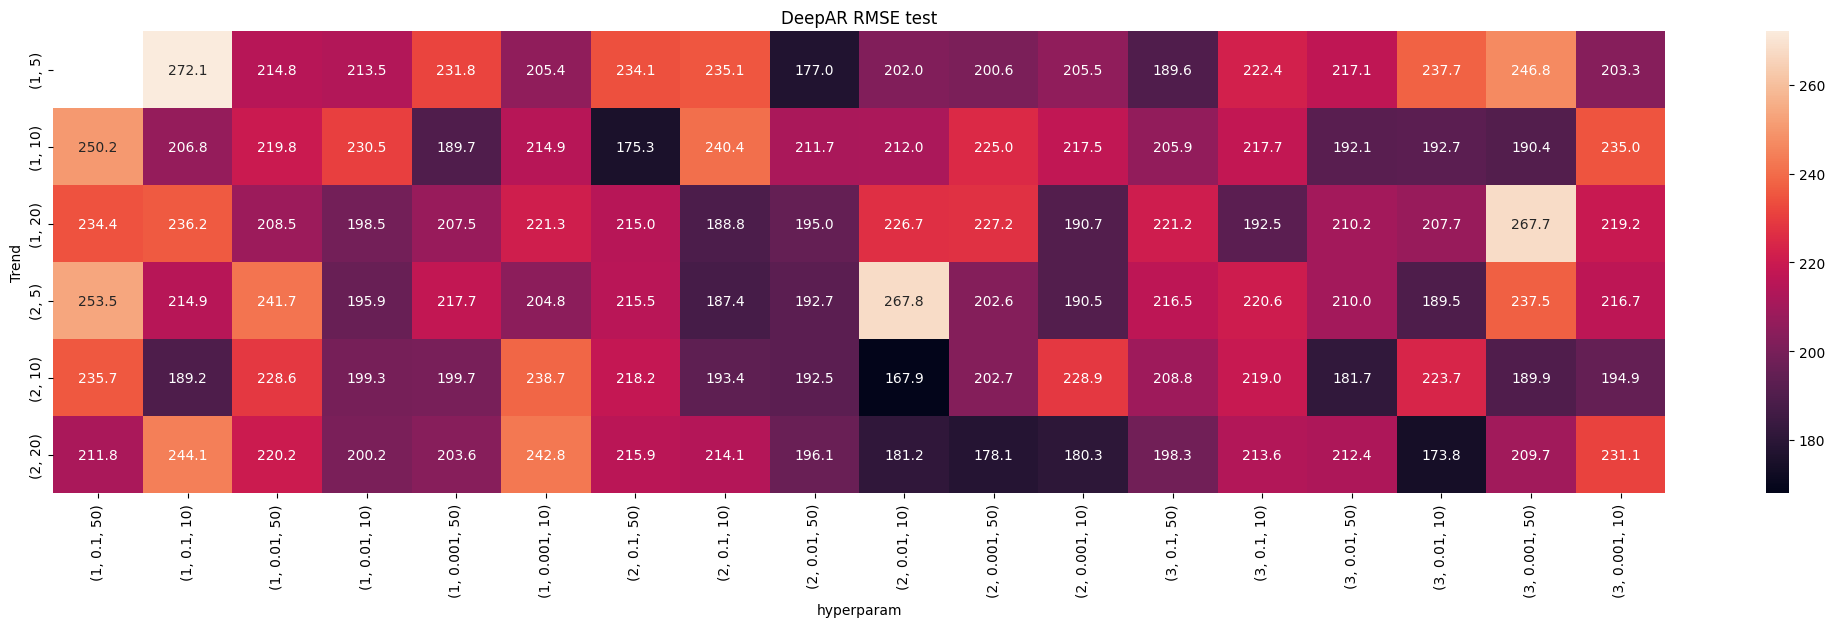

In [107]:
pl.figure(figsize=(26, 6))

data = deepar_test_rmse_df[deepar_test_rmse_df < 300]
# data = deepar_test_rmse_df


# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.1f')
pl.title('DeepAR RMSE test')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

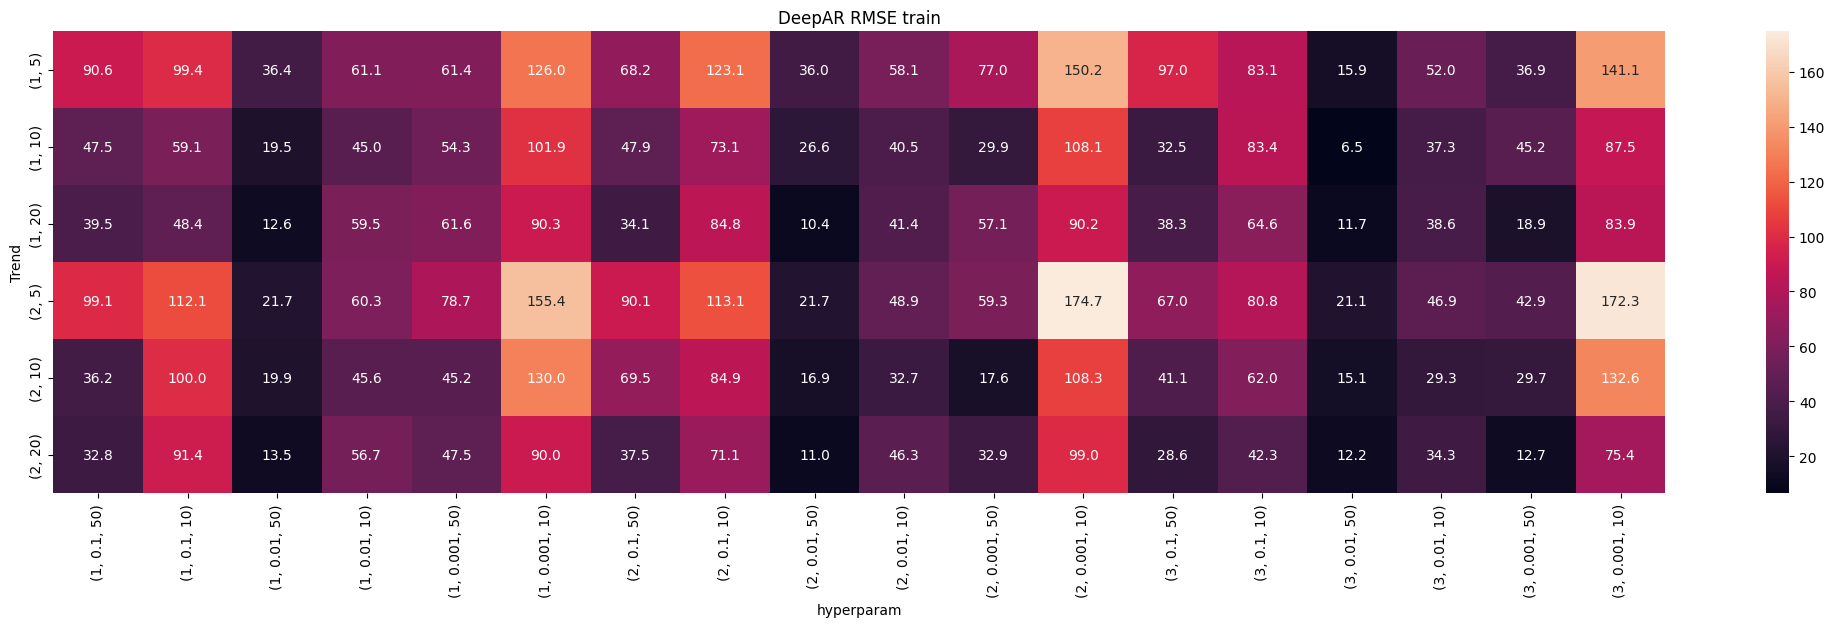

In [97]:
pl.figure(figsize=(26, 6))

# data = deepar_test_rmse_df[deepar_test_rmse_df < 20000]
data = deepar_train_rmse_df


# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.1f')
pl.title('DeepAR RMSE train')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

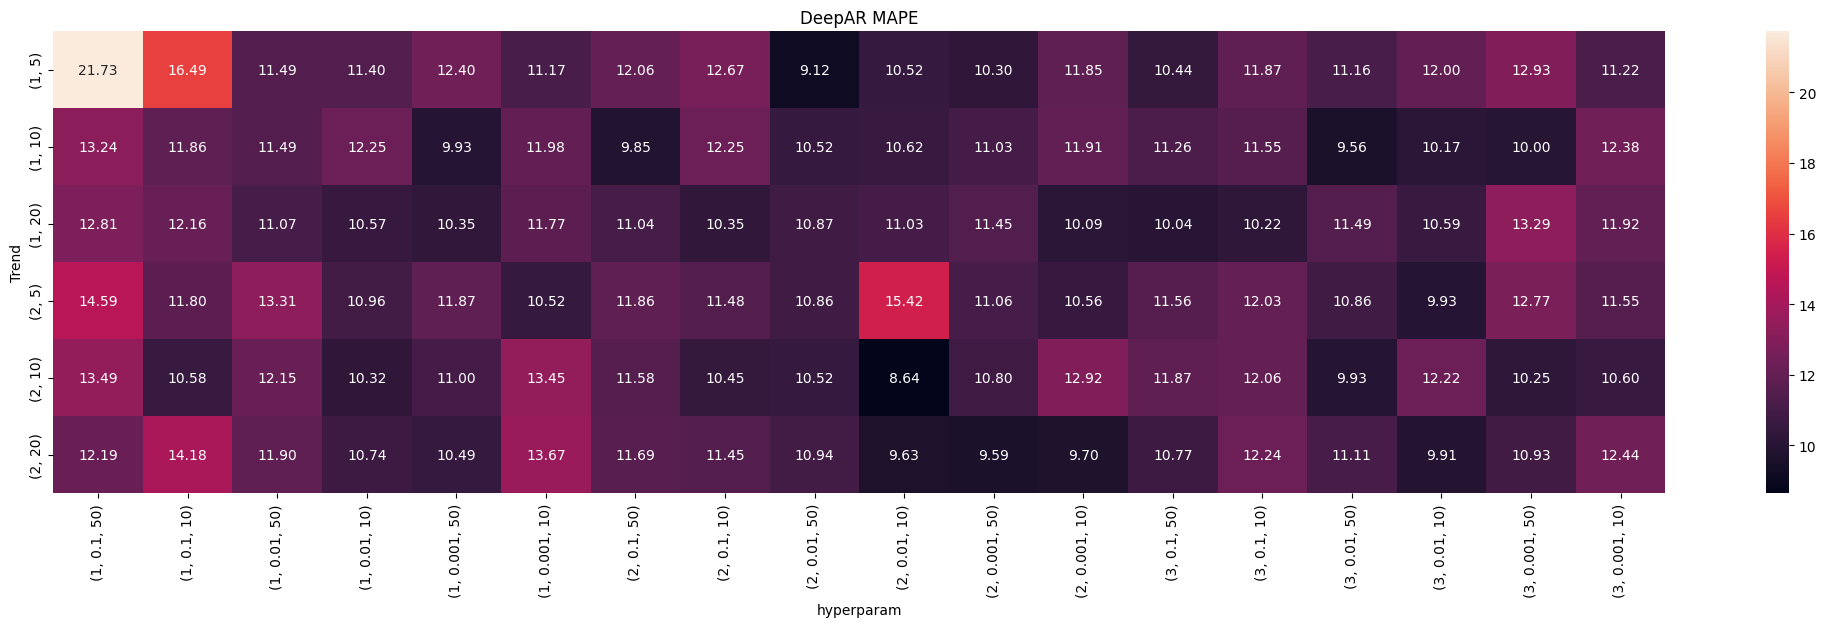

In [115]:
pl.figure(figsize=(26, 6))

# data = deepar_test_rmse_df[deepar_test_rmse_df < 20000]
data = deepar_test_mape_df


# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.2f')
pl.title('DeepAR MAPE')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

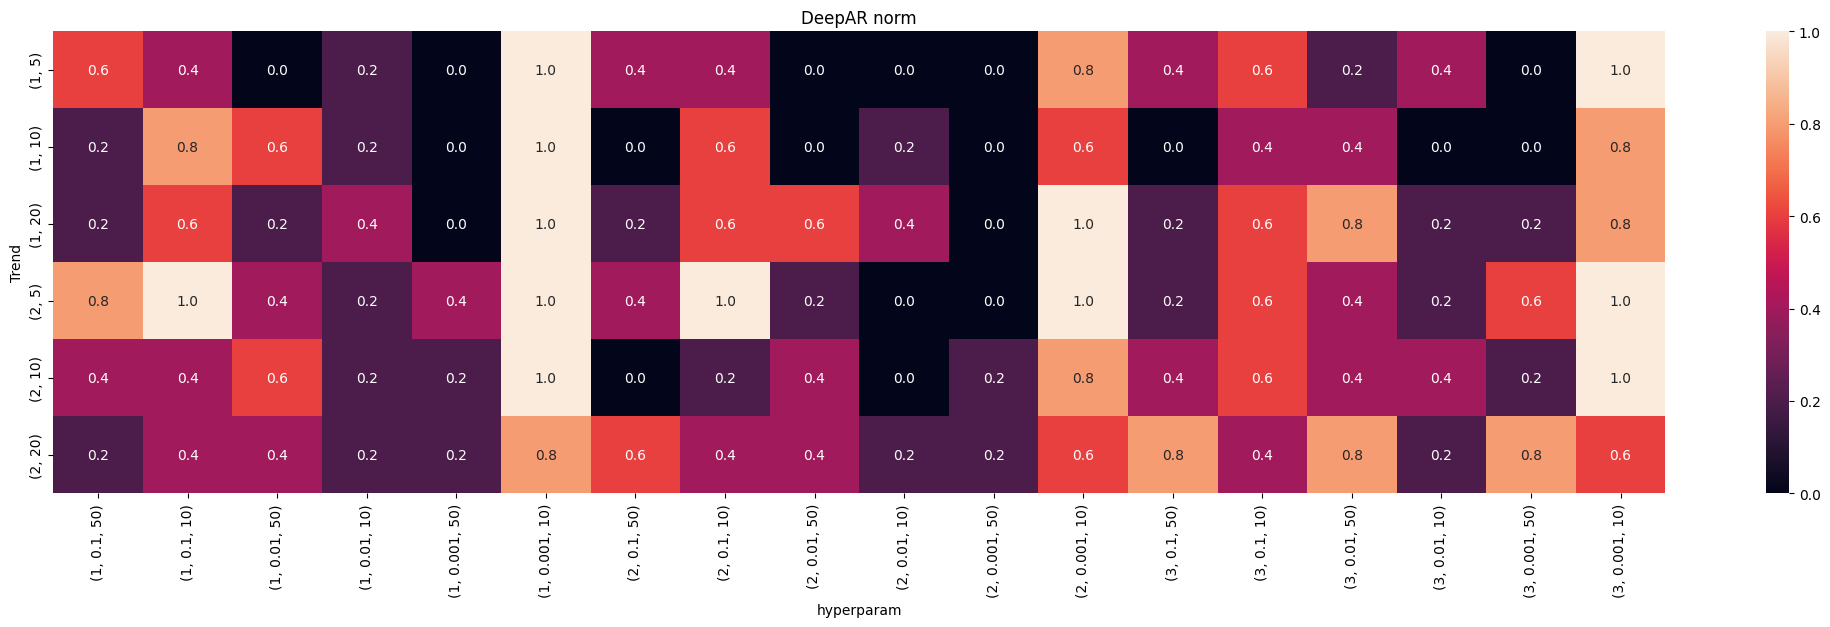

In [116]:
pl.figure(figsize=(26, 6))

# data = deepar_test_rmse_df[deepar_test_rmse_df < 20000]
data = deepar_norm_df


# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.1f')
pl.title('DeepAR norm')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

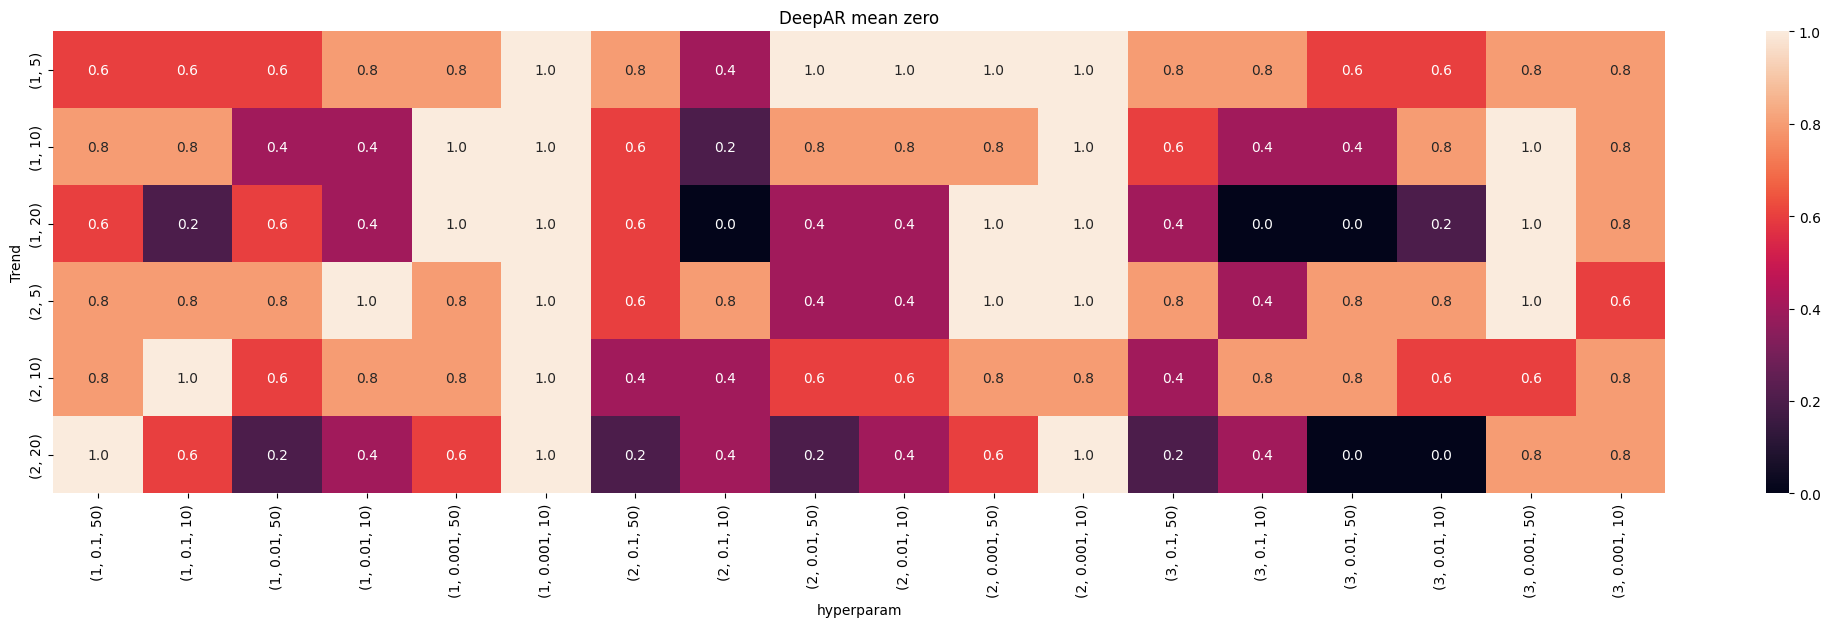

In [117]:
pl.figure(figsize=(26, 6))

# data = deepar_test_rmse_df[deepar_test_rmse_df < 20000]
data = deepar_mean_zero_df


# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.1f')
pl.title('DeepAR mean zero')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

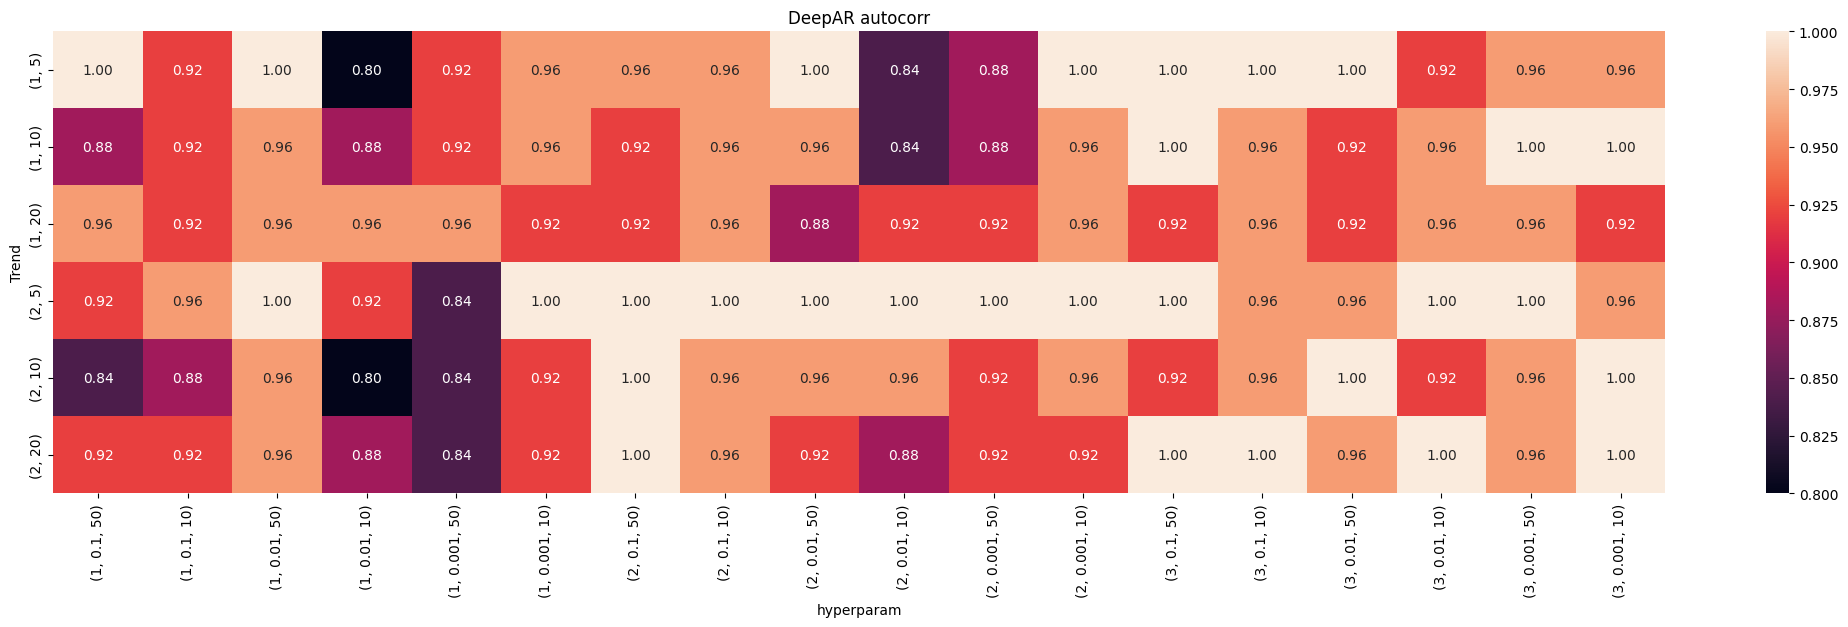

In [118]:
pl.figure(figsize=(26, 6))

# data = deepar_test_rmse_df[deepar_test_rmse_df < 20000]
data = deepar_autocorr_df


# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.2f')
pl.title('DeepAR autocorr')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

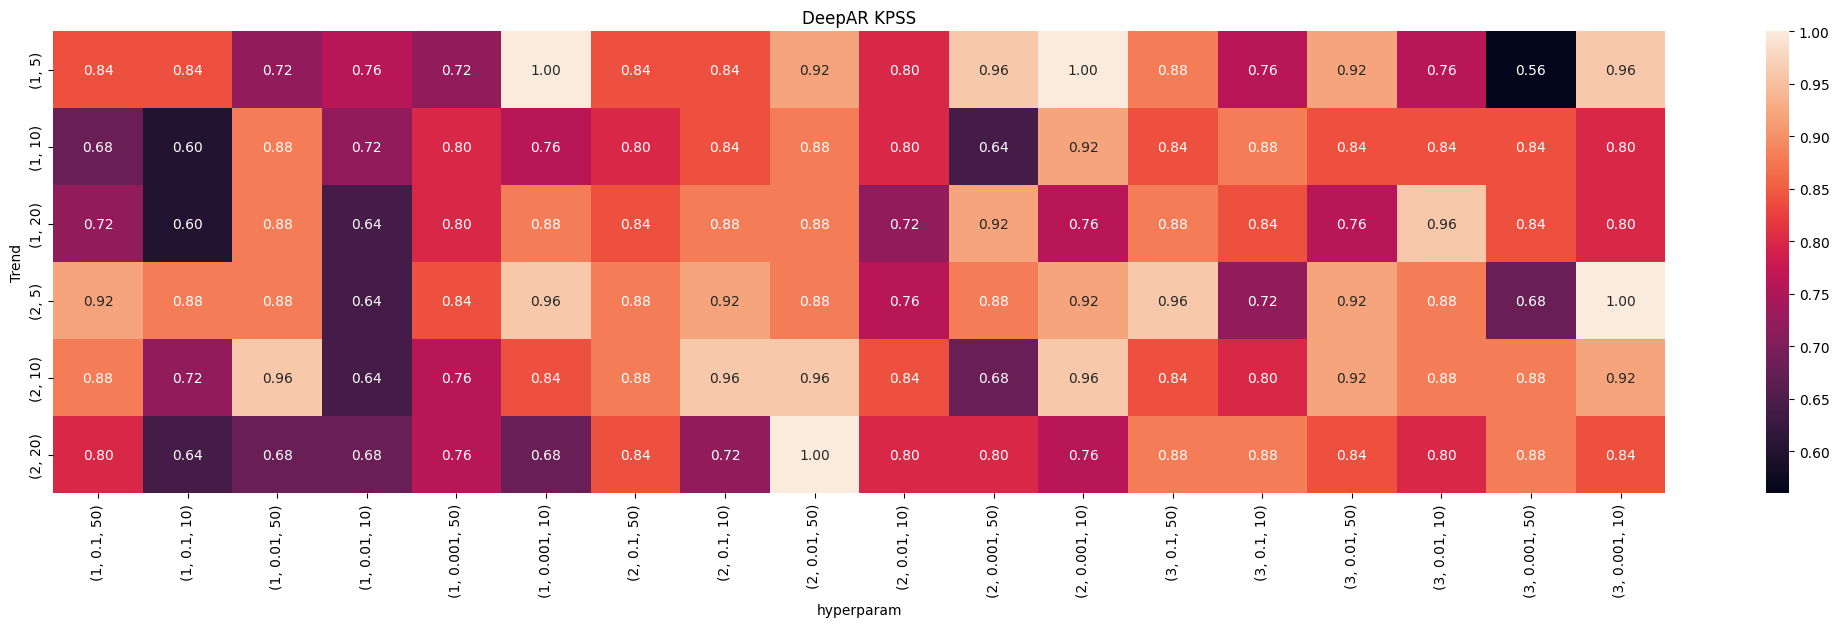

In [121]:
pl.figure(figsize=(26, 6))

# data = deepar_test_rmse_df[deepar_test_rmse_df < 20000]
data = deepar_kpss_df


# pl.subplot(1, 3, 1)
sns.heatmap(data = data.astype(np.float64), annot=True, fmt='.2f')
pl.title('DeepAR KPSS')
pl.xlabel('hyperparam')
pl.ylabel('Trend')
pl.show()

## Results

In [184]:
metrics = np.array([es_metrics[:6], ar_metrics[:6], arima_metrics[:6], prophet_metrics[:6], deepar_metrics[:6]]).round(3)
metrics_df = pd.DataFrame(data = metrics, columns=['RMSE_train', 'RMSE_test', 'AIC', 'MAPE', 'MAE_test', 'Confidence'], index=['Exponential Smooth', 'AutoRegression', 'ARIMA', 'Prophet', 'DeepAR'])
metrics_df

metrics2 = np.array([es_metrics[6:], ar_metrics[6:], arima_metrics[6:], prophet_metrics[6:], deepar_metrics[6:]])
metrics2_df = pd.DataFrame(data = metrics2, columns=['Autocorr', 'Equal_zero', 'Norm', 'ADF', 'Stationarity'], index=['Exponential Smooth', 'AutoRegression', 'ARIMA', 'Prophet', 'DeepAR'])
metrics_df



RMSE_train  RMSE_test      AIC    MAPE  MAE_test  \
Exponential Smooth     101.013    145.755   81.131   9.276   145.755   
AutoRegression         146.746    160.479   93.046  10.314   160.479   
ARIMA                   96.130    145.676  104.674   9.283   145.676   
Prophet                119.562    160.267      NaN  10.273   160.267   
DeepAR                 167.055    170.482      NaN   9.306   146.317   

                    Confidence  
Exponential Smooth      27.408  
AutoRegression          35.783  
ARIMA                   23.027  
Prophet                 23.544  
DeepAR                  82.376

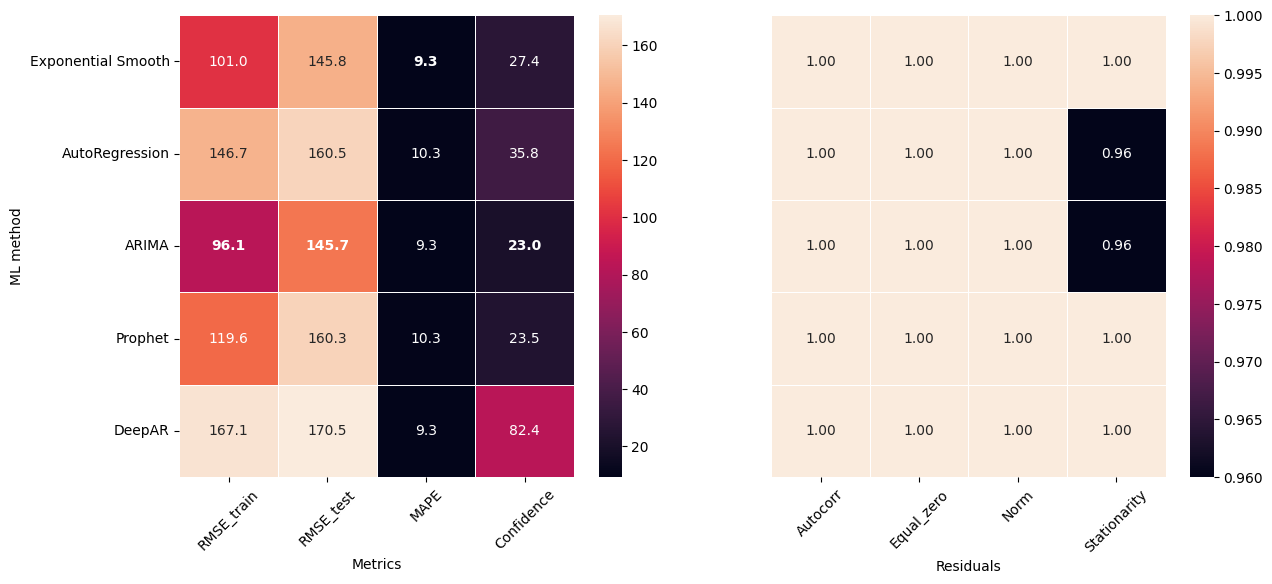

In [185]:
metrics_df = metrics_df.drop(['AIC', 'MAE_test'], axis=1)
min_in_column = np.min(metrics_df, axis=0)

pl.figure(figsize=(14, 6))
pl.subplot(1, 2, 1)
sns.heatmap(metrics_df, mask=metrics_df == min_in_column, annot=True, fmt='.1f', linewidth=0.5)
sns.heatmap(metrics_df, mask=metrics_df != min_in_column, annot=True, fmt='.1f', linewidth=0.5, annot_kws={"weight": "bold"}, cbar=False, vmin=10, vmax=200)

pl.xlabel('Metrics')
pl.ylabel('ML method')
pl.xticks(rotation=45)
# pl.show()

pl.subplot(1, 2, 2)
sns.heatmap(metrics2_df.drop('ADF', axis=1), annot=True, fmt='.2f', linewidth=0.5, yticklabels=False)

pl.xlabel('Residuals')
# pl.ylabel('ML method')
pl.xticks(rotation=45)
pl.show()